<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/tp1/7506R_TP1_GRUPO06_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as st
import scipy.linalg as la
import sklearn as sk
import scipy.stats as st
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Análisis Exploratorio y Preprocesamiento de Datos**
El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).
Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

#### **PREPRACION DE LOS DATOS**
Crear un nuevo dataset que contemplen los siguientes atributos :
- Tipos de vivienda: Casa, Ph Y Departamentos
- Moneda de transacción: Dólares (USD)
- Ubicacion : Capital Federal

##### **1.1 Mostrar informacion del dataset con los filtros requeridos del enunciado**

In [138]:
properties_argentina = pd.read_csv('/content/drive/MyDrive/Copia de properati_argentina_2021.csv')

attributes_list = ["property_type", "operation", "property_currency", "place_l2"]
conditions_list = [["Casa", "PH","Departamento"],["Venta"],["USD"],["Capital Federal"]]

def get_dataframe_by(data, attributes: list, conditions: list):
    housing_type = data[attributes[0]].isin(conditions[0])
    is_operation_sale = data[attributes[1]].isin(conditions[1])
    is_property_currency_usd = data[attributes[2]].isin(conditions[2])
    is_place_l2_capital_federal = data[attributes[3]].isin(conditions[3])
    return data[housing_type & is_operation_sale & is_property_currency_usd & is_place_l2_capital_federal]

properties_argentina_filtered = get_dataframe_by(properties_argentina, attributes_list, conditions_list)
print("Dataframe antes de filtrar : ", properties_argentina.shape)
print("Datafrema filtrado: ", properties_argentina_filtered.shape)

Dataframe antes de filtrar :  (460154, 20)
Datafrema filtrado:  (94249, 20)


#### 1.2 Separar el conjunto de prueba y de entranamiento
- Entranamiento 80%
- Prueba 20 %

In [139]:
properties_argentina_train_set, properties_argentina_test_set = train_test_split(properties_argentina_filtered, test_size=0.2, random_state=42)
print("Conjunto de Entranamiento: ", properties_argentina_train_set.shape)
print("Conjunto de Prueba: ", properties_argentina_test_set .shape)

Conjunto de Entranamiento:  (75399, 20)
Conjunto de Prueba:  (18850, 20)


Para el entrenamiento vamos a utilizar todos los datos, ya que tenemos un bug que aún no logramos resolver.

In [140]:
properties_argentina_filtered = properties_argentina_train_set

## **ENTENDER EL PROBLEMA**
El objetivo del tp es poder entrenar un modelo que pueda predecir el valor de venta de un inmueble en cualquier barrio de capital federal.
En esta primera parte vamos a limpiar los datos y además entender como los datos pueden influir en la prediction de nuestro modelo o rendimiento de nuestro modelo.

### COMPROBACIONES PLANTEADAS EN EL TP
Las comprobaciones nos daran un entendimiento más profundo sobre los datos. Con los conocimientos de los datos vamos a tener más criterios para poder limpiar los mismos y poder entrenar el modelo.
#### a) Exploración Inicial: analizar cada variable, considerando los siguientes aspectos


In [141]:
col_numericas = []
col_categoricas = []
for columna in properties_argentina_filtered.columns:
  if (properties_argentina_filtered[columna].dtype == 'float' or properties_argentina_filtered[columna].dtype == 'int'):
    col_numericas.append(columna);
  else:
    col_categoricas.append(columna);

In [142]:
print(col_numericas)
print(col_categoricas)

['latitud', 'longitud', 'place_l6', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price']
['id', 'start_date', 'end_date', 'created_on', 'place_l2', 'place_l3', 'place_l4', 'place_l5', 'operation', 'property_type', 'property_currency', 'property_title']


#### a.1)Variables Cuantitativas: calcular medidas de resumen: media, mediana,moda,etc

In [143]:
properties_argentina_filtered[col_numericas].describe()

latitud      longitud  place_l6  property_rooms  \
count  72420.000000  72420.000000       0.0    74555.000000   
mean     -34.591358    -58.449737       NaN        2.825015   
std        0.188601      0.289167       NaN        1.433820   
min      -53.788624    -71.471192       NaN        1.000000   
25%      -34.615996    -58.466550       NaN        2.000000   
50%      -34.595757    -58.439146       NaN        3.000000   
75%      -34.577367    -58.408917       NaN        4.000000   
max      -24.219827    -54.133330       NaN       40.000000   

       property_bedrooms  property_surface_total  property_surface_covered  \
count       66597.000000            71509.000000              72708.000000   
mean            2.017208              111.841013                 89.872806   
std             1.135236             1079.926643               1106.107524   
min            -1.000000               10.000000                  1.000000   
25%             1.000000               45.000000                 40.000000   
50%             2.000000               65.000000                 58.000000   
75%             3.000000              105.000000                 89.000000   
max            70.000000           137000.000000             217000.000000   

       property_price  
count    7.539900e+04  
mean     2.260926e+05  
std      3.183805e+05  
min      5.000000e+03  
25%      9.500000e+04  
50%      1.439000e+05  
75%      2.380000e+05  
max      2.140000e+07

#### a.2) Variables Cualitativas: mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [144]:
properties_argentina_filtered[col_categoricas].describe()

id  start_date    end_date  created_on  \
count                      75399       75399       75399       75399   
unique                     75399         365         600         365   
top     sH/yN2YdtUSSJepTsIXyjQ==  2021-12-16  2021-06-05  2021-12-16   
freq                           1        3732       10253        3732   

               place_l2 place_l3           place_l4 place_l5 operation  \
count             75399    75073               2870        0     75399   
unique                1       57                  4        0         1   
top     Capital Federal  Palermo  Palermo Hollywood      NaN     Venta   
freq              75399    11397               1232      NaN     75399   

       property_type property_currency          property_title  
count          75399             75399                   75399  
unique             3                 1                   46378  
top     Departamento               USD  Departamento - Palermo  
freq           64619             75399                    1184

#### a.3) Determinar variables irrelevantes en el análisis
Con la información del punto anterior podemos determinar algunas variables que no son relevantes para nuestro modelo, es decir no nos van a aportar información de calidad que sirva para el entranamiento del modelo.

##### **Analisis :**
c.1) Los atributos start_date, end_date y create_on hacen referencia a las fechas en las cuales se crearon los datos, por lo tanto, esto no es relevante para nuestro modelo de predicción

c.2) Los atributos place_l3 y place_l4 son atributos relevantes, ya que el barrio puede influir en el precio de un inmueble.

Loss atributos place_l2, place_l5 y place_l6 los dejamos afuera del análisis. El atributo place_l2 lo utilizamos para filtrar la información por capital federal y los atributos place_l6,place_5 directamente no tiene datos.



Los atributos irrelevantes para nuestro análisis son :
- start_date
- end_date
- create_on
- place_l5
- place_l6

Por lo tanto, estas variables se pueden eliminar de la data frame

Podemos concluir que son atributos relevantes ya que el barrio puede influir en el precio de un inmueble.
Los valore irrelevantes para nuestro análisis son :
- start_date
- end_date
- create_on
- place_l5
- place_l6

Por lo tanto, estas variables se pueden eliminar de la data frame

In [145]:
properties_argentina_filtered = properties_argentina_filtered.drop(columns=["start_date", "end_date", "created_on" ,"place_l5", "place_l6"])

#### a.4) Realizar un análisis gráfico de las distribuciones de las variables más relevantes

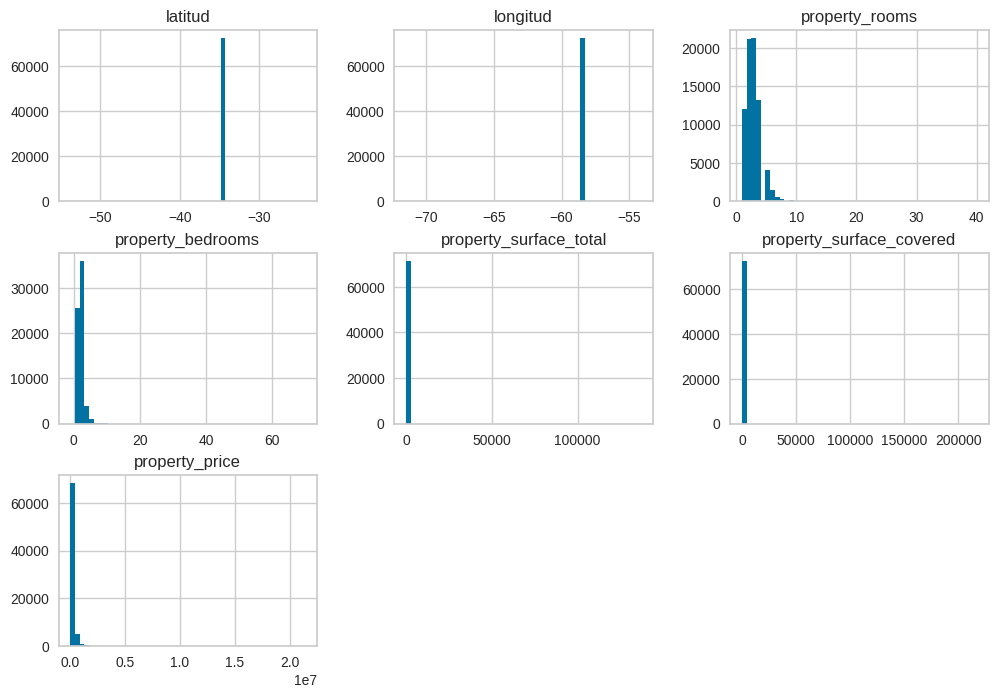

In [146]:
properties_argentina_filtered.hist(figsize=(12, 8), bins=50)
plt.show()

#### a.5) Analizar las correlaciones existentes entre las variables.
Para analizar la correlación entre las variables, hay que seleccionar aquellas variables del tipo float64

<Axes: >

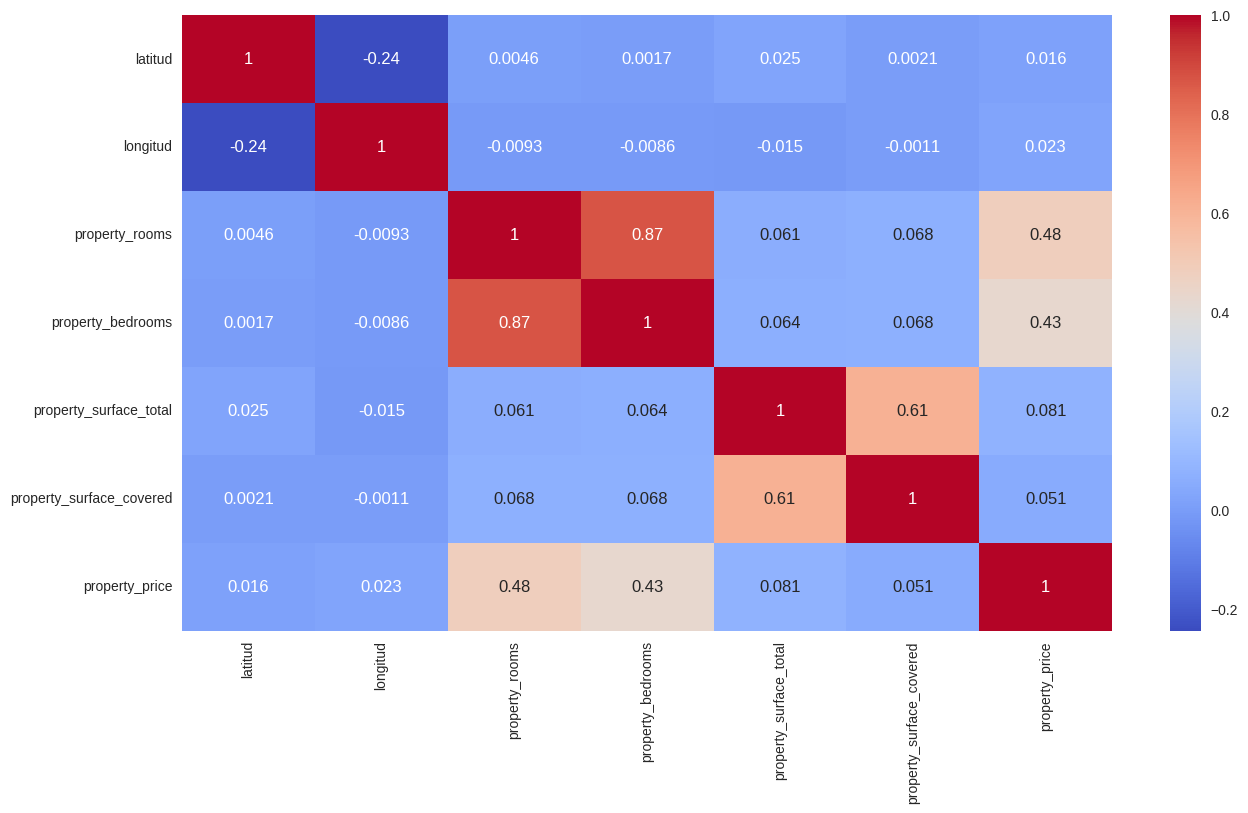

In [147]:
properties_argentina_filtered_copy = properties_argentina_filtered.copy()
properties_argentina_numeric = properties_argentina_filtered_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = properties_argentina_numeric.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

Se analiza la correlación de todos los atributos respecto al precio de la propiedad, podemos observar que el atributo rooms y bedrooms tiene correlaciones positivas, esto quiere decir que el precio de una vivienda puede aumentar si estos dos atributos aumentan.

Con esta información también nos podemos preguntar lo siguiente: ¿La proporción de habitaciones/ambientes por casa puede influir en el precio de una propiedad?, para contestar esta pregunta, se puede crear una nueva variable que represente el nuevo atributo


In [148]:
properties_argentina_filtered_copy = properties_argentina_filtered.copy()
properties_argentina_filtered_copy["property_bedrooms_ratio"] = properties_argentina_filtered_copy["property_bedrooms"] / properties_argentina_filtered_copy["property_rooms"]

properties_argentina_numeric = properties_argentina_filtered_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = properties_argentina_numeric.corr()
corr_property_price = corr_matrix["property_price"].sort_values(ascending=False)
print(corr_property_price)

property_price              1.000000
property_rooms              0.484365
property_bedrooms           0.426593
property_surface_total      0.080665
property_bedrooms_ratio     0.062126
property_surface_covered    0.050979
longitud                    0.022694
latitud                     0.016128
Name: property_price, dtype: float64


Si observamos el valor obtenido no tiene mucha influencia en sobre el valor de una propiedad.
También se puede hacer el mismo análisis con la proporción de la property_surface_covered/property_surface_total

In [149]:
properties_argentina_filtered_copy = properties_argentina_filtered.copy()
properties_argentina_filtered_copy["property_surface_ratio"] = properties_argentina_filtered_copy["property_surface_covered"] / properties_argentina_filtered_copy["property_surface_total"]

properties_argentina_numeric = properties_argentina_filtered_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = properties_argentina_numeric.corr()
corr_property_price = corr_matrix["property_price"].sort_values(ascending=False)
print(corr_property_price)

property_price              1.000000
property_rooms              0.484365
property_bedrooms           0.426593
property_surface_total      0.080665
property_surface_covered    0.050979
longitud                    0.022694
latitud                     0.016128
property_surface_ratio     -0.001285
Name: property_price, dtype: float64


Si bien es una correlación negativa, el valor no es muy representativo, por lo tanto, podemos concluir que no influye en la determinación del precio de una propiedad.
Concluimos que los dos atributos que pueden influir en el precio de una propiedad son: property_bedrooms y property_rooms.

Esta es un conclusion muy temprano, ya que nos falta limpiar los datos, mas adelante vamos a tener una conclusion de las correlaciones un poco más coherente.

### b) Visualización de los datos: en esta sección se espera que puedan realizar una primera
Aproximación a los datos apoyándose en visualizaciones, por ejemplo: gráficos de dispersión
entre variables, histogramas, heatmaps, exploración de las columnas y cualquier otro gráfico
adicional que se considere útil justificando su utilización.
Para visualizar los datos, vamos a utilizar un gráfico del tipo geográfico. Est nos ayudará a entender en que zonas de capital los precios de las propiedades pueden ser más caras o más baratas.

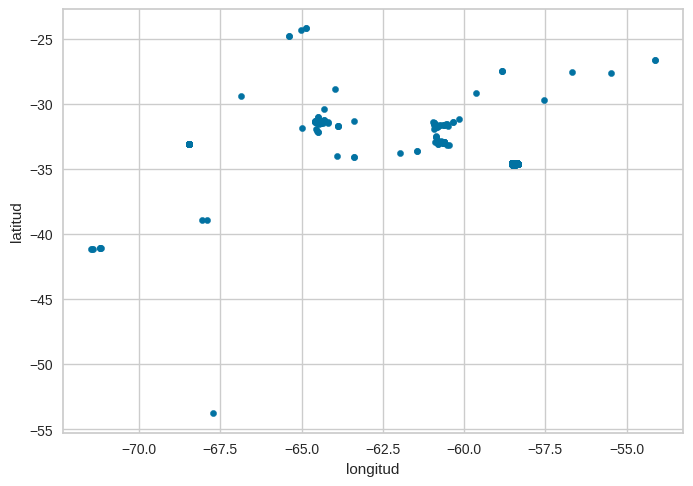

In [150]:
properties_argentina_filtered.plot(kind="scatter", x="longitud", y="latitud", grid=True)
plt.show()

Otra cosa que podemos hacer es ver la densidad de puntos en el mapa

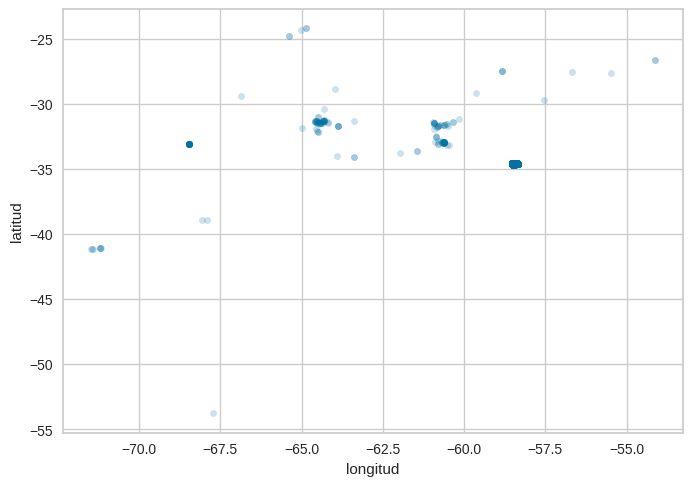

In [151]:
properties_argentina_filtered.plot(kind="scatter", x="longitud", y="latitud", grid=True, alpha=0.2)
plt.show()

Ahora vamos a observar con un mapa de calor las propiedades mas caras y en que parte se concentran las que tiene más metros cuadrados(totales)

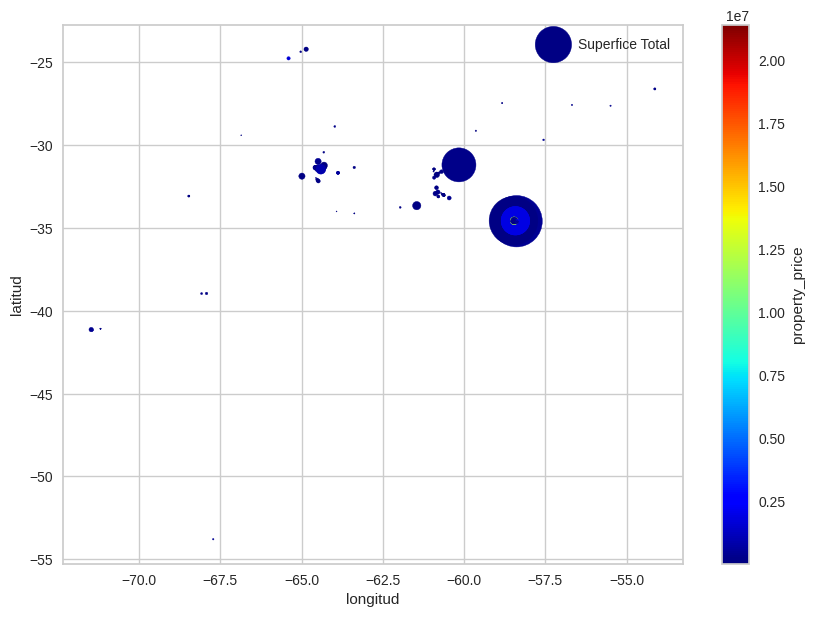

In [152]:
properties_argentina_filtered.plot(kind="scatter", x="longitud", y="latitud", grid=True,
s=properties_argentina_filtered["property_surface_total"] / 100 , label="Superfice Total",
c="property_price", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(10, 7))
plt.show()

#### Otros Gráficos que nos ayudara a entender a nivel de negocio como es el comportamiento de los inmuebles

#### b.2) Cantidad de Propiedades según El barrio

Text(0, 0.5, 'Cantidad de propiedades')

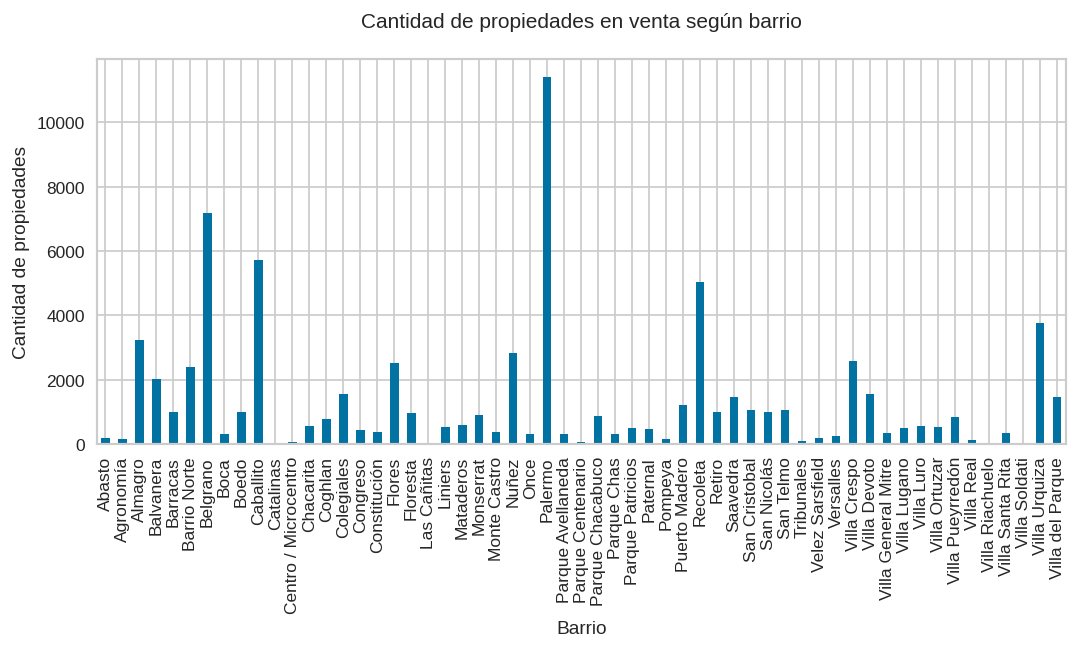

In [153]:
plt.figure(dpi=125,figsize=(10,4))

properties_argentina_filtered.groupby('place_l3')['id'].count().plot(kind='bar')
plt.title("Cantidad de propiedades en venta según barrio\n")
plt.xlabel("Barrio")
plt.ylabel("Cantidad de propiedades")

#### b.3) Cantidad de inmuebles según el tipo

Text(0, 0.5, 'Cantidad de propiedades')

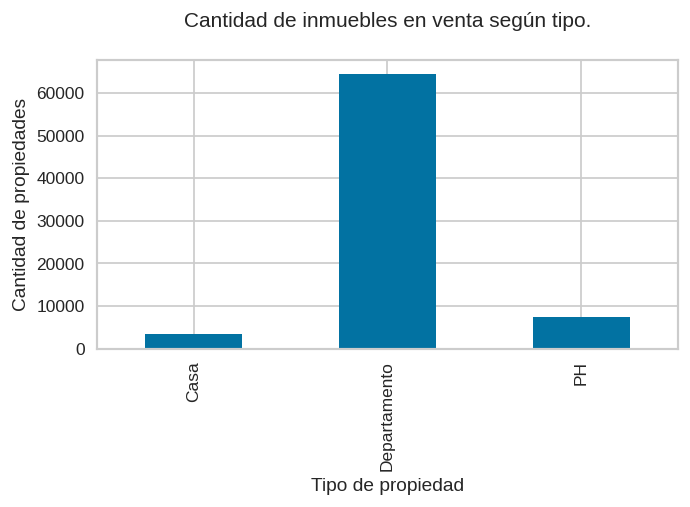

In [154]:
plt.figure(dpi=125,figsize=(6,3))

properties_argentina_filtered.groupby('property_type')['id'].count().plot(kind='bar')
plt.title("Cantidad de inmuebles en venta según tipo.\n")
plt.xlabel("Tipo de propiedad")
plt.ylabel("Cantidad de propiedades")

#### c.) Datos Faltantes

* Realizar análisis de datos faltantes en columna. Graficar para cada variable el
porcentaje de datos faltantes con respecto al total del dataset.

Antes de empezar voy a llamar "" a la columna place_l3 y "" a la columna place_l2

In [155]:
properties_argentina_filtered = properties_argentina_filtered.rename(columns={"place_l2":"city","place_l3":"zone"})

Primero busco caracteres raros como "NULL", "?", "-", como no hay ninguno sigo buscando valores faltantes:

In [156]:
filas_totales = properties_argentina_filtered.shape[0]
porcentaje_col_faltante = properties_argentina_filtered.isna().sum() / filas_totales * 100
print(porcentaje_col_faltante)

id                           0.000000
latitud                      3.950981
longitud                     3.950981
city                         0.000000
zone                         0.432366
place_l4                    96.193583
operation                    0.000000
property_type                0.000000
property_rooms               1.119378
property_bedrooms           11.673895
property_surface_total       5.159220
property_surface_covered     3.569013
property_price               0.000000
property_currency            0.000000
property_title               0.000000
dtype: float64


Veo que todos los valores son bajos y no deberia dropear ninguna exceptuando a place_l4, como su funcion es especificar en que parte de Palermo estan algunas propiedades, lo mas lógico sería reemplazar a Palermo por la zona especifica en estas zonas y evitar tener una columna con más de un 96% de datos NaN.

In [157]:
for i in range(1,properties_argentina_filtered.shape[0]):
    fila = properties_argentina_filtered.iloc[i]
    zona = fila["zone"]
    es_NaN = zona!=zona

    if not es_NaN and zona=="Palermo":
      zona_Palermo = fila["place_l4"]
      zona_Pal_NaN = zona_Palermo!=zona_Palermo
      if not zona_Pal_NaN:
        properties_argentina_filtered.iat[i, 4] = zona_Palermo

    i+=1

    properties_argentina_filtered=properties_argentina_filtered

Ahora vamos a eliminar la columna place_l4 y luego volvemos a ver los datos faltantes por columna pero en un grafico

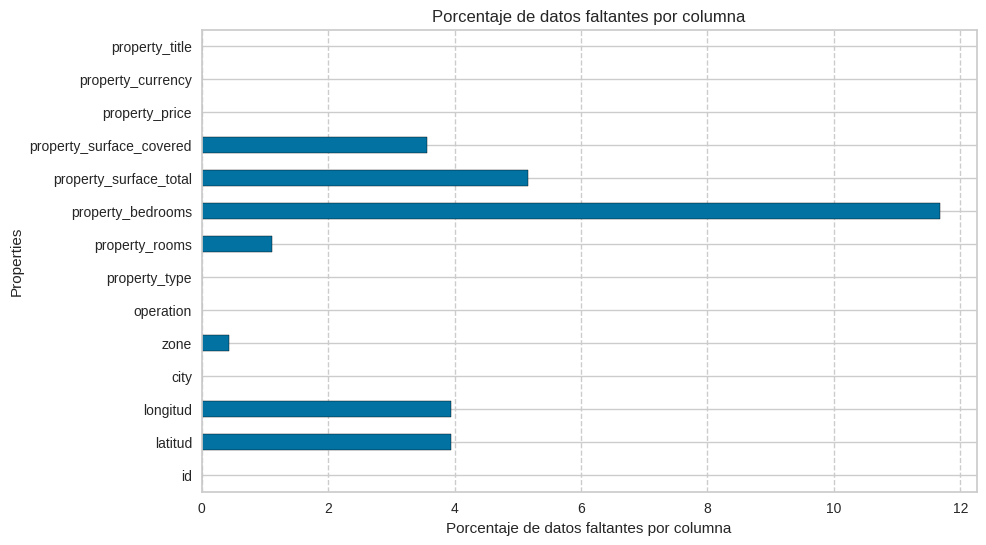

In [158]:
properties_argentina_filtered = properties_argentina_filtered.drop(columns=["place_l4"])
filas_totales = properties_argentina_filtered.shape[0]
porcentaje_col_faltante = properties_argentina_filtered.isna().sum() / filas_totales * 100


porcentaje_col_faltante.plot(kind='barh', figsize=(10, 6), edgecolor='black')
plt.title('Porcentaje de datos faltantes por columna')
plt.ylabel('Properties')
plt.xlabel('Porcentaje de datos faltantes por columna')
plt.grid(axis='x', linestyle='--')
plt.show()

Podemos observar que exceptuando a "property_bedrooms" todas las columnas tienen un porcentaje de datos faltantes menor o similar al 5%.


*  Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.



Primero calculo que porcentaje de cada fila falta:

*   Elemento de la lista

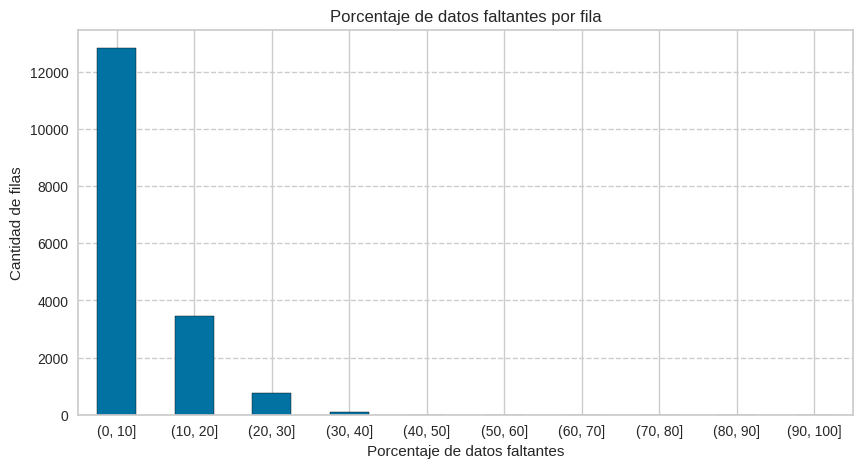

In [159]:
col_totales = len(properties_argentina_filtered.columns)
porcentaje_faltante_fila = properties_argentina_filtered.isna().sum(axis=1) / col_totales * 100

rangos = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
porcentaje_agrupado = pd.cut(porcentaje_faltante_fila, bins=rangos).value_counts().sort_index()
plt.figure(figsize=(10, 5))
porcentaje_agrupado.plot(kind='bar', edgecolor='black')
plt.title('Porcentaje de datos faltantes por fila')
plt.xlabel('Porcentaje de datos faltantes')
plt.ylabel('Cantidad de filas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

Se puede ver que las mayoría de las filas tienen entre un 0% y un 10% de datos faltantes, otros entre un 10% y un 20%, algunos pocos entre 20% y 30% y finalmente una porción muy menor entre el 30% y 40%.



*  Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.



**Primero** voy a asignarles la latitud y longitud a todas las filas que tengan una zona, les voy a asiganar la media de todos las filas de la misma zona.

In [160]:
reparado = properties_argentina_filtered

place_l3_copy = properties_argentina_filtered["zone"]
place_l3_drop = place_l3_copy.drop_duplicates()
zones = place_l3_drop.values

media_zones = {}    #Me guardo las medias de (latitud,longitud) de c/zona

for zone in zones:
      zone_act = reparado[reparado["zone"]==zone]
      lat_med = zone_act["latitud"].mean()
      lon_med = zone_act["longitud"].mean()
      media_zones[zone] = (lat_med,lon_med)
      zone_act = zone_act.fillna({"latitud":lat_med,"longitud":lon_med})
      reparado[reparado["zone"]==zone]=zone_act


Ahora los únicas filas que no tienen latitud o longitud son los que tampoco tienen zona y esos los dropeamos ya que asignarle una zona basandonos en datos como precios y superficie total/cubierta podría alterar las mediciones que se quieran hacer en el futuro

In [161]:
reparado.shape

(75399, 14)

Este es el número de filas antes de eliminar

In [162]:
import math

i = 0
while i < reparado.shape[0]:
  fila = reparado.iloc[i]
  lat = fila["latitud"]
  if math.isnan(lat):
    reparado.drop(reparado.index[i:i+1], inplace=True)
  else:
    i+=1


reparado.shape

(75267, 14)

Este es el nuevo número de filas.

Ahora voy a asignarle un barrio a aquellas filas que no tienen pero si tienen latitud y longitud, para eso voy a calcular la distancia entre la ubicacion y la media de cada zona. Voy a calcular la diferencia entre la latitud y la longitud de cada fila y la media, luego calculo un promedio (diferencia de latitud sumado la diferencia de longitud dividido 2) y el barrio que menor diferencia tenga sera el elegido.

In [163]:
for i in range(1,reparado.shape[0]):
    fila = reparado.iloc[i]
    zona = fila["zone"]
    bool = zona!=zona

    if bool:
      lat=fila["latitud"]
      lon=fila["longitud"]
      dist_menor = abs( abs(media_zones["Palermo"][0]) - abs(lat) ) + abs( abs( abs(media_zones["Palermo"][1] ) - abs(lon) ))
      barrio = "Palermo"

      for c in media_zones:

          tupla_dist = media_zones.get(c)
          nueva_dist = abs( abs(tupla_dist[0]) - abs(lat) ) + abs( abs( abs(tupla_dist[1] ) - abs(lon) ))
          es_menor = nueva_dist<dist_menor

          if es_menor:
            dist_menor=nueva_dist
            barrio = c

      reparado.iat[i, 4] = barrio


    i+=1

reparado = reparado


Vemos que no hay ningun NaN restante en la columna zone:

In [164]:
reparado["zone"].isna().value_counts()

zone
False    75267
Name: count, dtype: int64

Ahora vamos a completar la columna "property_surface_total" la cual se podría calcular teniendo en cuenta el precio medio por m2 de cada zona.

In [165]:
prec_m2 = {}

for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  prec_tot = 0
  sup_tot = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    prec = fila["property_price"]
    sup = fila["property_surface_total"]

    if not sup!=sup:    #es decir si la columna property_surface_total no es NaN
      prec_tot+=prec
      sup_tot+=sup

  if sup_tot!=0:
    prec_prom = prec_tot/sup_tot

    prec_m2[zona]= prec_prom





Ahora que ya sabemos los precios del m2 podriamos hacer una regla de 3 y sabiendo el precio de la propiedad obtener un estimado realista de la superficie total de esta.

In [166]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  sup = fila["property_surface_total"]
  if sup!=sup:
      prec = fila["property_price"]
      sup_calc = prec/prec_m2.get(zona)
      reparado.iat[i, 9] = sup_calc


Ahora buscamos el porcentaje de superficie cubierta por zona, este sera un porcentaje de la superficie total y sera: (sup_cub * 100)/sup_tot.
Ahora calculamos ese porcentaje por zona:

In [167]:
porc_sup_cub = {}

for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  sup_tot = 0
  sup_cub = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    s_tot = fila["property_surface_total"]
    s_cub = fila["property_surface_covered"]

    if not s_cub!=s_cub:    #es decir si la columna property_surface_covered no es NaN
      sup_tot+=s_tot
      sup_cub+=s_cub

  if sup_tot!=0:
    porc_cub = (sup_cub * 100)/sup_tot
    porc_sup_cub[zona]= porc_cub

Ahora que ya sabemos los porcentajes de superficie cubierta con respecto a la superficie total hay que imputar la superficie cubierta de aquellas filas que no posean ese dato:

In [168]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  sup_cub = fila["property_surface_covered"]
  if sup_cub!=sup_cub:
      sup_tot = fila["property_surface_total"]
      nueva_sup_cub = sup_tot * porc_sup_cub.get(zona)
      reparado.iat[i, 10] = nueva_sup_cub

Ahora voy a calcular el promedio de superficie cubierta por habitación que hay en cada zona para luego poder estimar cuantas habitaciones (rooms) tiene cada propiedades a las que le falte el dato.

In [169]:
met_por_hab = {}

for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  s_mediana = zona_act["property_surface_total"].median()
  met_por_hab[zona]=s_mediana/r_mediana


Teniendo el promedio de metros por habitación de cada zona, calculo e imputo los datos de property_rooms faltantes

In [170]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  rooms = fila["property_rooms"]
  if rooms!=rooms:
      sup_cub = fila["property_surface_covered"]
      nuevo_rooms = sup_cub / met_por_hab.get(zona)
      reparado.iat[i, 7] = round(nuevo_rooms)

Finalmente solo queda completar la columna property_beedrooms, para la cual primero calcularemos por zona el porcentaje de rooms que son bedrooms, esto para luego poder estimar cuantos bedrooms hay utilizando el dato property_rooms

In [171]:
por_bedrooms = {}

rooms=reparado["property_rooms"].median()
bedrooms=reparado["property_bedrooms"].median()
porcentaje_mediana_gral = (bedrooms*100)/rooms


for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  b_mediana = zona_act["property_bedrooms"].median()
  porcentaje = (b_mediana * 100)/r_mediana
  if porcentaje==100.0:
    porcentaje=porcentaje_mediana_gral
  por_bedrooms[zona] = porcentaje


Ahora queda imputar el dato en aquillas filas donde no esta:

In [172]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  bedrooms = fila["property_bedrooms"]
  if bedrooms!=bedrooms:
      rooms = fila["property_rooms"]
      calc_bedrooms = (rooms*por_bedrooms.get(zona)/100)
      reparado.iat[i, 8] = round(calc_bedrooms)

Para poder ver la nueva en la nueva distribución de datos faltantes de las variables.

Primero vemos el nuevo porcentaje de datos faltantes por columna:

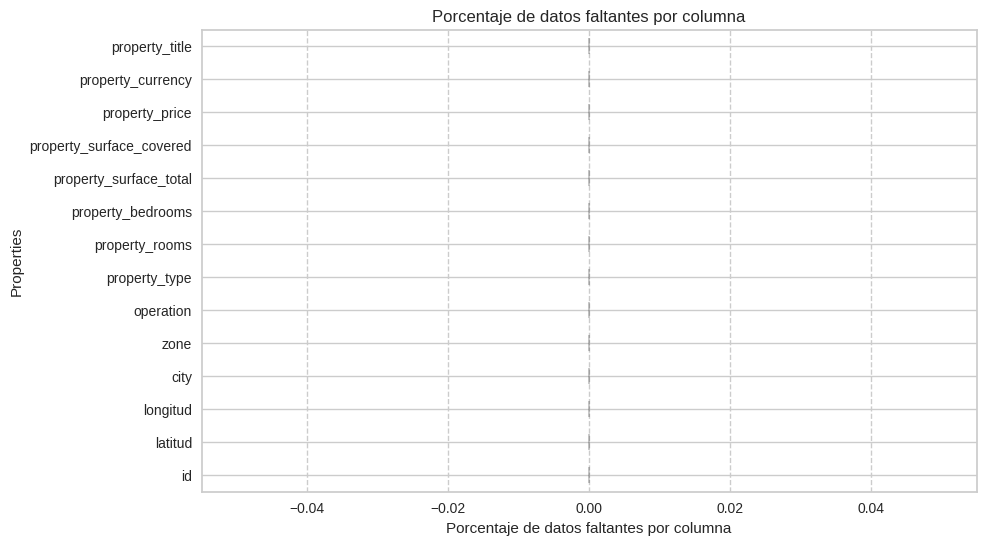

In [173]:
filas_totales = reparado.shape[0]
porcentaje_col_faltante = reparado.isna().sum() / filas_totales * 100


porcentaje_col_faltante.plot(kind='barh', figsize=(10, 6), edgecolor='black')
plt.title('Porcentaje de datos faltantes por columna')
plt.ylabel('Properties')
plt.xlabel('Porcentaje de datos faltantes por columna')
plt.grid(axis='x', linestyle='--')
plt.show()

Ahora vemos el nuevo grafico del porcentaje de datos faltantes por fila:

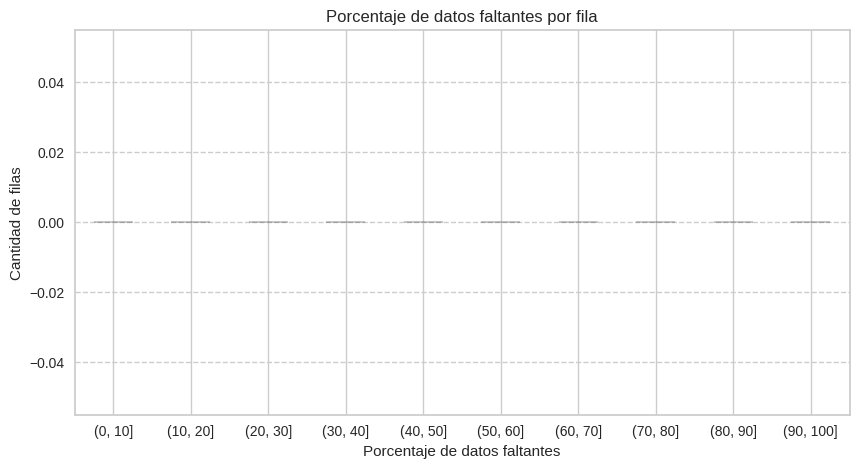

In [174]:
col_totales = len(reparado.columns)
porcentaje_faltante_fila = reparado.isna().sum(axis=1) / col_totales * 100

rangos = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
porcentaje_agrupado = pd.cut(porcentaje_faltante_fila, bins=rangos).value_counts().sort_index()
plt.figure(figsize=(10, 5))
porcentaje_agrupado.plot(kind='bar', edgecolor='black')
plt.title('Porcentaje de datos faltantes por fila')
plt.xlabel('Porcentaje de datos faltantes')
plt.ylabel('Cantidad de filas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

Podemos ver que no quedan datos faltantes:

In [175]:
reparado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75267 entries, 285884 to 75496
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        75267 non-null  object 
 1   latitud                   75267 non-null  float64
 2   longitud                  75267 non-null  float64
 3   city                      75267 non-null  object 
 4   zone                      75267 non-null  object 
 5   operation                 75267 non-null  object 
 6   property_type             75267 non-null  object 
 7   property_rooms            75267 non-null  float64
 8   property_bedrooms         75267 non-null  float64
 9   property_surface_total    75267 non-null  float64
 10  property_surface_covered  75267 non-null  float64
 11  property_price            75267 non-null  float64
 12  property_currency         75267 non-null  object 
 13  property_title            75267 non-null  object 
dtypes: flo

Finalmente se podrían quitar las columnas "property_currency" ya que todas estan en USD y la columna "id" ya que todos los id son únicos y no aportan informacion

In [176]:
reparado = reparado.drop(columns=["id", "property_currency"])

Y ahora la estructura es la siguiente:

In [177]:
reparado.head(1)

latitud   longitud             city          zone operation  \
285884 -34.62139 -58.506366  Capital Federal  Monte Castro     Venta   

       property_type  property_rooms  property_bedrooms  \
285884  Departamento             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
285884                    51.0                      44.0        112000.0   

                                           property_title  
285884  Venta tres ambientes chico cochera y amplio ba...

#### d.) Análisis de valores atípicos.

Primero comenzamos buscando valores que no sean lógicos del problema a tratar.

In [178]:
reparado[(reparado['property_bedrooms'] < 0) | (reparado['property_rooms'] < 0)]

latitud   longitud             city           zone operation  \
406880 -34.577595 -58.495185  Capital Federal  Villa Urquiza     Venta   

       property_type  property_rooms  property_bedrooms  \
406880  Departamento             2.0               -1.0   

        property_surface_total  property_surface_covered  property_price  \
406880                    61.0                      43.0        125000.0   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

No es probable que un inmueble, en este caso un departamento, -1 habitaciones. Puede tratarse de un dato mal cargado o de un registro incorrecto. Consideraremos que se trata de un error de tipeo por el título del anuncio haciendo referencia que se trata de un tres ambientes

In [179]:
reparado.loc[reparado[reparado['property_bedrooms'] < 0].index,'property_bedrooms'] = 1

Realizamos los mismos para otras variables y no nos encontramos registros que cumplan con la condición.

In [180]:
reparado[(reparado['property_price'] <= 0) | (reparado['property_surface_total'] <= 0) | (reparado['property_surface_covered'] <= 0)]

Empty DataFrame
Columns: [latitud, longitud, city, zone, operation, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, property_title]
Index: []

#### d.2) Análisis univariado

Para encontrar otros valores atípicos comenzaremos con un análisis univariado. Decidimos comenzar graficando diferentes boxplot para poder reconocer los valores que se alejan de manera visual y así tener un primer acercamiento.

In [181]:
columnas = ['property_rooms', 'property_bedrooms']

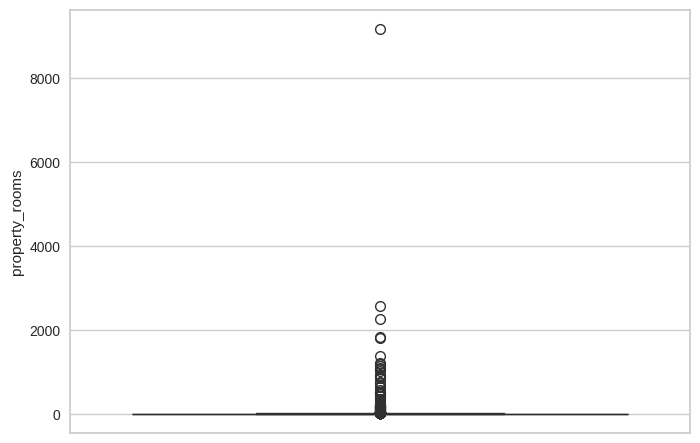

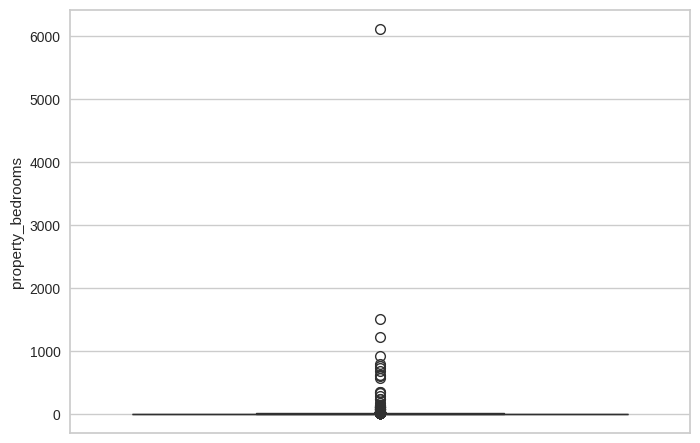

In [182]:
for col in columnas:
  sns.boxplot(y=reparado[col])
  plt.show()
  print('\n\n')

Podemos notar que tenemos registros que se alejan del común de los datos. Se puede ver a simple vista que son outliers

#### property_bedrooms

In [183]:
reparado['property_bedrooms'].describe()

count    75267.000000
mean         2.156124
std         24.736009
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       6113.000000
Name: property_bedrooms, dtype: float64

Calcularemos la métrica Z-score y Z-score modificado para luego tomar decisiones al respecto.

In [184]:
def z_calculation(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

def z_mod_calculation(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

In [185]:
reparado["z_bedrooms"] = z_calculation(reparado['property_bedrooms'])

In [186]:
reparado["z_mod_bedrooms"] = z_mod_calculation(reparado['property_bedrooms'])

Observaremos los inmuebles que cumplen con la "regla de oro" de ambas métricas.

In [187]:
print(reparado[(reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3)].shape)
reparado[(reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3)]

(34, 14)


latitud   longitud             city              zone operation  \
333910 -34.651286 -58.508025  Capital Federal           Liniers     Venta   
21244  -34.625605 -58.397219  Capital Federal      Constitución     Venta   
169009 -34.628589 -58.463167  Capital Federal            Flores     Venta   
4275   -34.638494 -58.468998  Capital Federal            Flores     Venta   
375559 -34.558574 -58.446057  Capital Federal          Belgrano     Venta   
403550 -34.631721 -58.478355  Capital Federal          Floresta     Venta   
209150 -34.597522 -58.374412  Capital Federal            Retiro     Venta   
32624  -34.641866 -58.402643  Capital Federal  Parque Patricios     Venta   
169752 -34.628589 -58.463167  Capital Federal            Flores     Venta   
24893  -34.603877 -58.493163  Capital Federal  Villa del Parque     Venta   
169062 -34.593408 -58.402171  Capital Federal      Barrio Norte     Venta   
191486 -34.607558 -58.421838  Capital Federal           Almagro     Venta   
200643 -34.594331 -58.428606  Capital Federal           Palermo     Venta   
97301  -34.622152 -58.473098  Capital Federal            Flores     Venta   
1140   -34.605781 -58.376705  Capital Federal       San Nicolás     Venta   
1932   -34.637026 -58.426283  Capital Federal  Parque Chacabuco     Venta   
59738  -34.585364 -58.441430  Capital Federal           Palermo     Venta   
290761 -34.597712 -58.401618  Capital Federal          Recoleta     Venta   
105866 -34.607558 -58.421838  Capital Federal           Almagro     Venta   
169901 -34.581800 -58.424777  Capital Federal           Palermo     Venta   
452175 -34.589510 -58.387251  Capital Federal          Recoleta     Venta   
169006 -34.606069 -58.404089  Capital Federal              Once     Venta   
53719  -34.559873 -58.449254  Capital Federal          Belgrano     Venta   
24821  -34.640361 -58.488192  Capital Federal           Liniers     Venta   
170422 -34.593408 -58.402171  Capital Federal      Barrio Norte     Venta   
93193  -34.683171 -58.467786  Capital Federal      Villa Lugano     Venta   
169028 -34.562512 -58.453917  Capital Federal          Belgrano     Venta   
194619 -34.559472 -58.465642  Capital Federal          Belgrano     Venta   
50334  -34.615152 -58.512313  Capital Federal      Villa Devoto     Venta   
344555 -34.621475 -58.481799  Capital Federal  Villa del Parque     Venta   
287445 -34.579524 -58.407947  Capital Federal          Recoleta     Venta   
169716 -34.606069 -58.404089  Capital Federal              Once     Venta   
194167 -34.603474 -58.409496  Capital Federal            Abasto     Venta   
115862 -34.559873 -58.449254  Capital Federal          Belgrano     Venta   

       property_type  property_rooms  property_bedrooms  \
333910  Departamento          2257.0             1505.0   
21244           Casa          1182.0              788.0   
169009            PH           184.0              123.0   
4275            Casa           856.0              571.0   
375559  Departamento           123.0               82.0   
403550            PH          1101.0              734.0   
209150  Departamento           128.0               85.0   
32624           Casa           523.0              349.0   
169752  Departamento           184.0              123.0   
24893             PH           341.0              227.0   
169062            PH           165.0              110.0   
191486  Departamento           117.0               78.0   
200643  Departamento           433.0              289.0   
97301           Casa           918.0              612.0   
1140    Departamento           467.0              234.0   
1932            Casa          9169.0             6113.0   
59738   Departamento           124.0               83.0   
290761  Departamento           523.0              349.0   
105866  Departamento           162.0              108.0   
169901  Departamento           151.0              101.0   
452175  Departamento           254.0              169.0   
169006          

In [188]:
print(reparado[(reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)].shape)
reparado[(reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)]

(216, 14)


latitud   longitud             city         zone operation  \
328872 -34.583469 -58.450238  Capital Federal    Chacarita     Venta   
129078 -34.597318 -58.389639  Capital Federal     Recoleta     Venta   
147972 -34.605473 -58.387790  Capital Federal  San Nicolás     Venta   
396876 -34.604062 -58.405112  Capital Federal         Once     Venta   
212637 -34.559873 -58.449254  Capital Federal     Belgrano     Venta   
...           ...        ...              ...          ...       ...   
33028  -34.642399 -58.445755  Capital Federal       Flores     Venta   
309970 -34.617148 -58.463260  Capital Federal       Flores     Venta   
312668 -34.655732 -58.409439  Capital Federal      Pompeya     Venta   
94998  -34.646632 -58.497902  Capital Federal   Villa Luro     Venta   
244028 -34.603597 -58.462264  Capital Federal    Caballito     Venta   

       property_type  property_rooms  property_bedrooms  \
328872          Casa            13.0                9.0   
129078  Departamento             9.0                8.0   
147972  Departamento             9.0                8.0   
396876  Departamento            14.0               12.0   
212637  Departamento            12.0                8.0   
...              ...             ...                ...   
33028           Casa             9.0                8.0   
309970  Departamento            17.0               11.0   
312668            PH            14.0               10.0   
94998   Departamento             3.0               70.0   
244028            PH            12.0                8.0   

        property_surface_total  property_surface_covered  property_price  \
328872              530.000000                     360.0        560000.0   
129078              160.000000                     160.0        315000.0   
147972              180.000000                     156.0        175000.0   
396876              301.000000                     179.0        220000.0   
212637              470.000000                     300.0       1150000.0   
...                        ...                       ...             ...   
33028               375.000000                     350.0        250000.0   
309970              547.000000                     396.0       1100000.0   
312668              270.000000                     217.0        190000.0   
94998                82.745773                      70.0        135000.0   
244028              300.000000                     260.0        250000.0   

                                           property_title  z_bedrooms  \
328872                                   Casa - Chacarita    0.276678   
129078  Piso 8 dormitorios en venta - Recoleta - Marce...    0.236251   
147972                         Departamento - San Nicolas    0.236251   
396876                    Venta Departamento 12 Ambientes    0.397960   
212637                         Local - Belgrano Barrancas    0.236251   
...                                                   ...         ...   
33028              CASA TALLER DEPOSITO VENTA BAJO FLORES    0.236251   
309970  EDIFICIO EN BLOQUE A ESTRENAR - 8 UNIDADES - 1...    0.357533   
312668  PH 5 DEPARTAMENTOS  OPORTUNIDAD VENTA POMPEYA ...    0.317106   
94998                           Departamento - Villa Luro    2.742735   
244028                                     PH - Caballito    0.236251   

        z_mod_bedrooms  
328872          4.7215  
129078          4.0470  
147972          4.0470  
396876          6.7450  
212637          4.0470  
...                ...  
33028           4.0470  
309970          6.0705  
312668          5.3960  
94998          45.8660  
244028          4.0470  

[216 rows x 14 columns]

In [189]:
print(reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))].shape)
reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))]

(34, 14)


latitud   longitud             city              zone operation  \
333910 -34.651286 -58.508025  Capital Federal           Liniers     Venta   
21244  -34.625605 -58.397219  Capital Federal      Constitución     Venta   
169009 -34.628589 -58.463167  Capital Federal            Flores     Venta   
4275   -34.638494 -58.468998  Capital Federal            Flores     Venta   
375559 -34.558574 -58.446057  Capital Federal          Belgrano     Venta   
403550 -34.631721 -58.478355  Capital Federal          Floresta     Venta   
209150 -34.597522 -58.374412  Capital Federal            Retiro     Venta   
32624  -34.641866 -58.402643  Capital Federal  Parque Patricios     Venta   
169752 -34.628589 -58.463167  Capital Federal            Flores     Venta   
24893  -34.603877 -58.493163  Capital Federal  Villa del Parque     Venta   
169062 -34.593408 -58.402171  Capital Federal      Barrio Norte     Venta   
191486 -34.607558 -58.421838  Capital Federal           Almagro     Venta   
200643 -34.594331 -58.428606  Capital Federal           Palermo     Venta   
97301  -34.622152 -58.473098  Capital Federal            Flores     Venta   
1140   -34.605781 -58.376705  Capital Federal       San Nicolás     Venta   
1932   -34.637026 -58.426283  Capital Federal  Parque Chacabuco     Venta   
59738  -34.585364 -58.441430  Capital Federal           Palermo     Venta   
290761 -34.597712 -58.401618  Capital Federal          Recoleta     Venta   
105866 -34.607558 -58.421838  Capital Federal           Almagro     Venta   
169901 -34.581800 -58.424777  Capital Federal           Palermo     Venta   
452175 -34.589510 -58.387251  Capital Federal          Recoleta     Venta   
169006 -34.606069 -58.404089  Capital Federal              Once     Venta   
53719  -34.559873 -58.449254  Capital Federal          Belgrano     Venta   
24821  -34.640361 -58.488192  Capital Federal           Liniers     Venta   
170422 -34.593408 -58.402171  Capital Federal      Barrio Norte     Venta   
93193  -34.683171 -58.467786  Capital Federal      Villa Lugano     Venta   
169028 -34.562512 -58.453917  Capital Federal          Belgrano     Venta   
194619 -34.559472 -58.465642  Capital Federal          Belgrano     Venta   
50334  -34.615152 -58.512313  Capital Federal      Villa Devoto     Venta   
344555 -34.621475 -58.481799  Capital Federal  Villa del Parque     Venta   
287445 -34.579524 -58.407947  Capital Federal          Recoleta     Venta   
169716 -34.606069 -58.404089  Capital Federal              Once     Venta   
194167 -34.603474 -58.409496  Capital Federal            Abasto     Venta   
115862 -34.559873 -58.449254  Capital Federal          Belgrano     Venta   

       property_type  property_rooms  property_bedrooms  \
333910  Departamento          2257.0             1505.0   
21244           Casa          1182.0              788.0   
169009            PH           184.0              123.0   
4275            Casa           856.0              571.0   
375559  Departamento           123.0               82.0   
403550            PH          1101.0              734.0   
209150  Departamento           128.0               85.0   
32624           Casa           523.0              349.0   
169752  Departamento           184.0              123.0   
24893             PH           341.0              227.0   
169062            PH           165.0              110.0   
191486  Departamento           117.0               78.0   
200643  Departamento           433.0              289.0   
97301           Casa           918.0              612.0   
1140    Departamento           467.0              234.0   
1932            Casa          9169.0             6113.0   
59738   Departamento           124.0               83.0   
290761  Departamento           523.0              349.0   
105866  Departamento           162.0              108.0   
169901  Departamento           151.0              101.0   
452175  Departamento           254.0              169.0   
169006          

In [190]:
reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))]['property_bedrooms'].describe()

count      34.000000
mean      534.441176
std      1048.550376
min        78.000000
25%       110.250000
50%       198.000000
75%       609.750000
max      6113.000000
Name: property_bedrooms, dtype: float64

Podemos ver que este rango se centra en inmuebles con más de 75 bedrooms. Decidimos eliminar las filas de los registros con estos valores porque no pudimos encontrarle una razón lógica a los datos y resultaban estar muy alejados a la realidad y que, al final, a la hora de entrenar un modelo para obtener la predicción que buscamos va a causar resultados erróneos.

In [191]:
index = reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))].index
reparado.drop(index, inplace=True)

In [192]:
reparado[(reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3)]

Empty DataFrame
Columns: [latitud, longitud, city, zone, operation, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, property_title, z_bedrooms, z_mod_bedrooms]
Index: []

In [193]:
reparado[(reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)]

latitud   longitud             city         zone operation  \
328872 -34.583469 -58.450238  Capital Federal    Chacarita     Venta   
129078 -34.597318 -58.389639  Capital Federal     Recoleta     Venta   
147972 -34.605473 -58.387790  Capital Federal  San Nicolás     Venta   
396876 -34.604062 -58.405112  Capital Federal         Once     Venta   
212637 -34.559873 -58.449254  Capital Federal     Belgrano     Venta   
...           ...        ...              ...          ...       ...   
33028  -34.642399 -58.445755  Capital Federal       Flores     Venta   
309970 -34.617148 -58.463260  Capital Federal       Flores     Venta   
312668 -34.655732 -58.409439  Capital Federal      Pompeya     Venta   
94998  -34.646632 -58.497902  Capital Federal   Villa Luro     Venta   
244028 -34.603597 -58.462264  Capital Federal    Caballito     Venta   

       property_type  property_rooms  property_bedrooms  \
328872          Casa            13.0                9.0   
129078  Departamento             9.0                8.0   
147972  Departamento             9.0                8.0   
396876  Departamento            14.0               12.0   
212637  Departamento            12.0                8.0   
...              ...             ...                ...   
33028           Casa             9.0                8.0   
309970  Departamento            17.0               11.0   
312668            PH            14.0               10.0   
94998   Departamento             3.0               70.0   
244028            PH            12.0                8.0   

        property_surface_total  property_surface_covered  property_price  \
328872              530.000000                     360.0        560000.0   
129078              160.000000                     160.0        315000.0   
147972              180.000000                     156.0        175000.0   
396876              301.000000                     179.0        220000.0   
212637              470.000000                     300.0       1150000.0   
...                        ...                       ...             ...   
33028               375.000000                     350.0        250000.0   
309970              547.000000                     396.0       1100000.0   
312668              270.000000                     217.0        190000.0   
94998                82.745773                      70.0        135000.0   
244028              300.000000                     260.0        250000.0   

                                           property_title  z_bedrooms  \
328872                                   Casa - Chacarita    0.276678   
129078  Piso 8 dormitorios en venta - Recoleta - Marce...    0.236251   
147972                         Departamento - San Nicolas    0.236251   
396876                    Venta Departamento 12 Ambientes    0.397960   
212637                         Local - Belgrano Barrancas    0.236251   
...                                                   ...         ...   
33028              CASA TALLER DEPOSITO VENTA BAJO FLORES    0.236251   
309970  EDIFICIO EN BLOQUE A ESTRENAR - 8 UNIDADES - 1...    0.357533   
312668  PH 5 DEPARTAMENTOS  OPORTUNIDAD VENTA POMPEYA ...    0.317106   
94998                           Departamento - Villa Luro    2.742735   
244028                                     PH - Caballito    0.236251   

        z_mod_bedrooms  
328872          4.7215  
129078          4.0470  
147972          4.0470  
396876          6.7450  
212637          4.0470  
...                ...  
33028           4.0470  
309970          6.0705  
312668          5.3960  
94998          45.8660  
244028          4.0470  

[182 rows x 14 columns]

In [194]:
reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5))]['property_bedrooms'].describe()

count    182.000000
mean      14.280220
std       12.461811
min        8.000000
25%        8.000000
50%       10.000000
75%       14.750000
max       76.000000
Name: property_bedrooms, dtype: float64

Existen registros que cumplen con la regla de oro del z-score modificado, pero que coinciden con la descripción de la publicación y no resultan tan alejados a la realidad como para decidir eliminarlos.

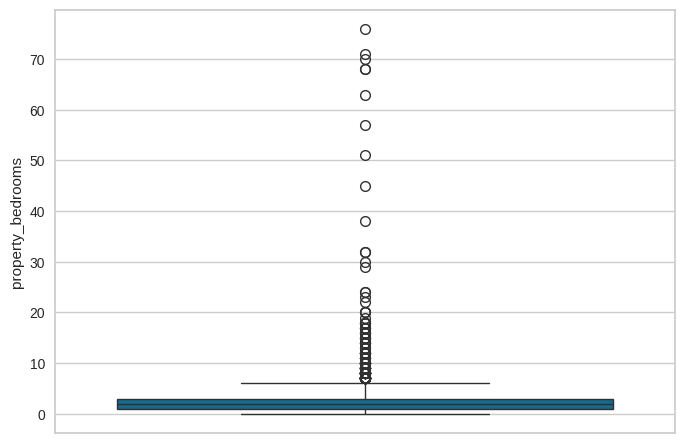

In [195]:
sns.boxplot(y=reparado['property_bedrooms'])
plt.show()

Se puede corroborar en el siguiente gráfico que todavía existen outliers, pero que consideramos no sacarlos.





#### property_rooms

In [196]:
reparado['property_rooms'].describe()

count    75233.000000
mean         3.115893
std         16.201402
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       2558.000000
Name: property_rooms, dtype: float64

Apreciamos que también tenemos un valor altísimo de ambientes que no resultan lógicos, volveremos a analizar con más detenimiento estos casos y calcularemos las métricas.

<Axes: ylabel='property_rooms'>

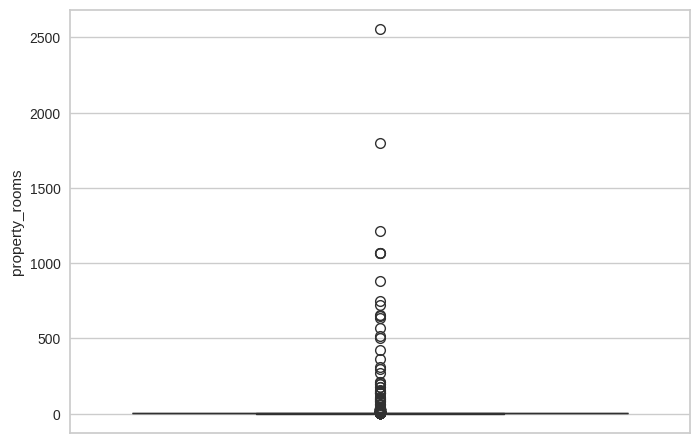

In [197]:
sns.boxplot(y=reparado['property_rooms'])

In [198]:
reparado["z_rooms"] = z_calculation(reparado['property_rooms'])
reparado["z_mod_rooms"] = z_mod_calculation(reparado['property_rooms'])

43 filas del dataset cumplen con la regla de oro del z-score

In [199]:
reparado[(reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3)].shape

(43, 16)

Mientras que 530 filas con el z-score modificado.

In [200]:
reparado[(reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5)].shape

(530, 16)

Al igual que antes, decidimos observar los registros que cumplen con ambos antes.

In [201]:
print(reparado[((reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3)) & ((reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5))].shape)
reparado[((reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3)) & ((reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5))]

(43, 16)


latitud   longitud             city               zone operation  \
356600 -34.582228 -58.406415  Capital Federal            Palermo     Venta   
192561 -34.623793 -58.402256  Capital Federal      San Cristobal     Venta   
161979 -34.593729 -58.379936  Capital Federal             Retiro     Venta   
434544 -34.620429 -58.361087  Capital Federal      Puerto Madero     Venta   
105126 -34.576741 -58.404830  Capital Federal      Palermo Chico     Venta   
248089 -34.575048 -58.420743  Capital Federal            Palermo     Venta   
306004 -34.628711 -58.458227  Capital Federal             Flores     Venta   
2790   -34.606366 -58.383480  Capital Federal        San Nicolás     Venta   
60841  -34.609896 -58.476014  Capital Federal           Paternal     Venta   
389059 -34.577332 -58.445887  Capital Federal         Colegiales     Venta   
363730 -34.636570 -58.401427  Capital Federal   Parque Patricios     Venta   
332190 -34.593634 -58.377164  Capital Federal             Retiro     Venta   
345135 -34.667556 -58.475632  Capital Federal       Villa Lugano     Venta   
411    -34.576741 -58.404830  Capital Federal      Palermo Chico     Venta   
26377  -34.593631 -58.435969  Capital Federal       Villa Crespo     Venta   
175931 -34.593004 -58.377001  Capital Federal             Retiro     Venta   
409283 -34.599678 -58.436474  Capital Federal            Palermo     Venta   
147353 -34.572620 -58.429993  Capital Federal            Palermo     Venta   
354859 -34.594061 -58.421465  Capital Federal            Palermo     Venta   
59751  -34.579383 -58.408007  Capital Federal      Palermo Chico     Venta   
169063 -34.595299 -58.429721  Capital Federal       Villa Crespo     Venta   
246537 -34.582086 -58.405248  Capital Federal      Palermo Chico     Venta   
173890 -34.578168 -58.407893  Capital Federal      Palermo Chico     Venta   
341898 -34.592656 -58.476247  Capital Federal          Agronomía     Venta   
30044  -34.580933 -58.407410  Capital Federal            Palermo     Venta   
165965 -34.557754 -58.471497  Capital Federal            Coghlan     Venta   
377495 -34.581103 -58.432997  Capital Federal  Palermo Hollywood     Venta   
177140 -34.627279 -58.373637  Capital Federal           Barracas     Venta   
204258 -34.601074 -58.397168  Capital Federal       Barrio Norte     Venta   
77664  -34.593178 -58.391664  Capital Federal           Recoleta     Venta   
31964  -34.575931 -58.407348  Capital Federal            Palermo     Venta   
219705 -34.609771 -58.444119  Capital Federal          Caballito     Venta   
320419 -34.581435 -58.415360  Capital Federal            Palermo     Venta   
410    -34.576741 -58.404830  Capital Federal      Palermo Chico     Venta   
32128  -34.596161 -58.394826  Capital Federal           Recoleta     Venta   
420901 -34.611181 -58.361018  Capital Federal      Puerto Madero     Venta   
248087 -34.581103 -58.432997  Capital Federal  Palermo Hollywood     Venta   
158788 -34.594043 -58.403605  Capital Federal           Recoleta     Venta   
357158 -34.627164 -58.405943  Capital Federal        San Nicolás     Venta   
101719 -34.651465 -58.424129  Capital Federal            Pompeya     Venta   
177181 -34.626697 -58.373873  Capital Federal          San Telmo     Venta   
11647  -34.620927 -58.376493  Capital Federal          San Telmo     Venta   
341707 -34.565059 -58.461620  Capital Federal           Belgrano     Venta   

       property_type  property_rooms  property_bedrooms  \
356600  Departamento           106.0               71.0   
192561          Casa          1801.0               13.0   
161979  Departamento           502.0                2.0   
434544  Departamento           298.0                2.0   
105126  Departamento          1070.0                4.0   
248089  Departamento          1212.0                4.0   
306004  Departamento           268.0                2.0   
2790    Departamento           750.0                6.0   
60841             PH           647.0          

In [202]:
reparado['property_rooms'].describe()

count    75233.000000
mean         3.115893
std         16.201402
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       2558.000000
Name: property_rooms, dtype: float64

También resultan valores bastante alejados de la realidad que, si los dejamos, puede que entrene en un futuro a nuestro modelo de forma incorrecta y de valores alejados a la realidad. Al igual que antes, tomamos la decisión de dropearlos.

In [203]:
index = reparado[((reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5)) & ((reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3))].index
reparado.drop(index, inplace=True)

In [204]:
reparado[(reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5)]

latitud   longitud             city           zone operation  \
328872 -34.583469 -58.450238  Capital Federal      Chacarita     Venta   
269052 -34.575012 -58.457444  Capital Federal     Colegiales     Venta   
129078 -34.597318 -58.389639  Capital Federal       Recoleta     Venta   
147972 -34.605473 -58.387790  Capital Federal    San Nicolás     Venta   
6279   -34.593211 -58.390512  Capital Federal       Recoleta     Venta   
...           ...        ...              ...            ...       ...   
350829 -34.600688 -58.514393  Capital Federal   Villa Devoto     Venta   
229851 -34.577553 -58.400657  Capital Federal  Palermo Chico     Venta   
244028 -34.603597 -58.462264  Capital Federal      Caballito     Venta   
146689 -34.573243 -58.467891  Capital Federal       Belgrano     Venta   
357524 -34.629218 -58.493361  Capital Federal       Floresta     Venta   

       property_type  property_rooms  property_bedrooms  \
328872          Casa            13.0                9.0   
269052          Casa            10.0                4.0   
129078  Departamento             9.0                8.0   
147972  Departamento             9.0                8.0   
6279    Departamento            10.0                5.0   
...              ...             ...                ...   
350829          Casa            20.0                4.0   
229851          Casa            11.0                4.0   
244028            PH            12.0                8.0   
146689          Casa            16.0                5.0   
357524          Casa            10.0                6.0   

        property_surface_total  property_surface_covered  property_price  \
328872              530.000000                     360.0        560000.0   
269052              690.492360                     600.0        650000.0   
129078              160.000000                     160.0        315000.0   
147972              180.000000                     156.0        175000.0   
6279                600.000000                     600.0       2000000.0   
...                        ...                       ...             ...   
350829              549.801987                     550.0        950000.0   
229851              580.000000                     380.0       2900000.0   
244028              300.000000                     260.0        250000.0   
146689              420.000000                     420.0        960000.0   
357524              379.000000                     222.0        299000.0   

                                           property_title  z_bedrooms  \
328872                                   Casa - Chacarita    0.276678   
269052                                  Casa - Colegiales    0.074543   
129078  Piso 8 dormitorios en venta - Recoleta - Marce...    0.236251   
147972                         Departamento - San Nicolas    0.236251   
6279    PISO VIVIENDA  APTO PROF EN RECOLETA LAS HERAS...    0.114970   
...                                                   ...         ...   
350829                                Casa - Villa Devoto    0.074543   
229851  EXCLUSIVA CASA EN BARRIO PARQUE  - 380M2 - AMP...    0.074543   
244028                                     PH - Caballito    0.236251   
146689          Chalet en Venta, ubicado en Belgrano "R".    0.114970   
357524                               Casa de 6 ambientes     0.155397   

        z_mod_bedrooms   z_rooms  z_mod_rooms  
328872          4.7215  0.610081       6.7450  
269052          1.3490  0.424911       4.7215  
129078          4.0470  0.363187       4.0470  
147972          4.0470  0.363187       4.0470  
6279            2.0235  0.424911       4.7215  
...                ...       ...          ...  
350829          1.3490  1.042146      11.4665  
229851          1.3490  0.486634       5.3960  
244028          4.0470  0.548358       6.0705  
146689          2.0235  0.795252       8.7685  
357524          2.6980  0.424911       4.7215  

[487 rows x 16 columns]

Seguimos teniendo registros que cumplen con la regla de oro del z-score modificado pero, nuevamente, consideramos que podrían ser valores más cercanos a la realidad por ende, por el momento, decidimos mantenerlos.

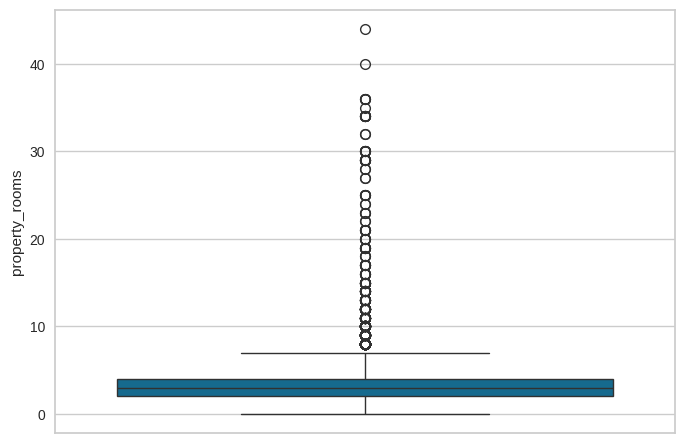

In [205]:
sns.boxplot(y=reparado['property_rooms'])
plt.show()

In [206]:
reparado.drop(['z_bedrooms', 'z_mod_bedrooms',
       'z_rooms', 'z_mod_rooms'], axis=1, inplace=True)

#### Análisis multivariado.

#### Mahalanobis

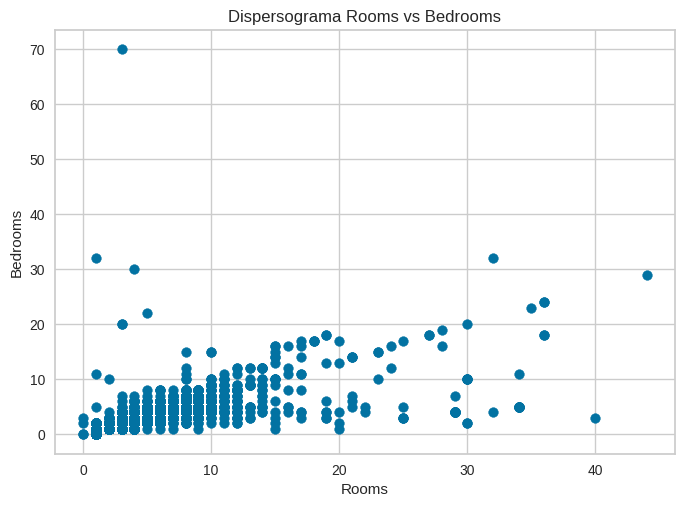

In [207]:
plt.scatter(reparado['property_rooms'], reparado['property_bedrooms'])
plt.title("Dispersograma Rooms vs Bedrooms")
plt.xlabel("Rooms")
plt.ylabel("Bedrooms")
plt.show()

Podemos notar que existen observacions anómalas, pero no son demasiadas. El valor notoriamente más alejado resulta ser una propiedad, en principio, con más de 70 habitaciones y pocos ambientes. Igualmente, calcularemos la distancia de mahalanobis para cada observación.

In [208]:
columnas = ["property_rooms", "property_bedrooms"]

In [209]:
def calculate_mahalanobis_distance(dataset, col1, col2, frac=1):
    X = dataset[[f'{col1}', f'{col2}']].copy()
    sample_X = X.sample(frac=frac)

    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T

    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = la.sqrtm(inv_cov)

    Wx = np.matmul(W, X_diff)
    X['mahalanobis'] = [np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])]

    return X

In [210]:
reparado['mahalanobis'] = calculate_mahalanobis_distance(reparado, 'property_bedrooms', 'property_rooms')['mahalanobis']

<Axes: ylabel='mahalanobis'>

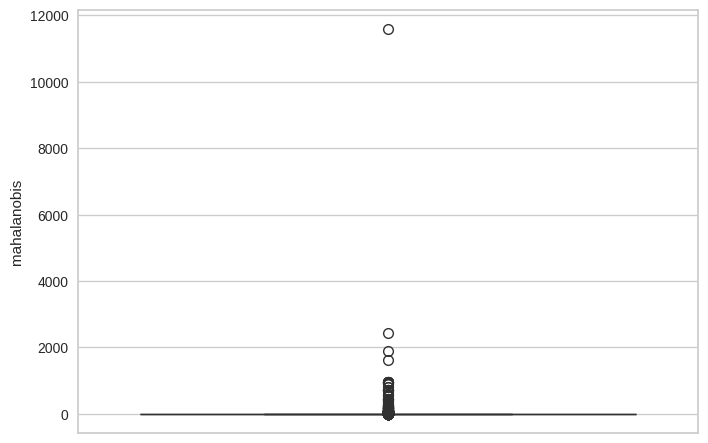

In [211]:
sns.boxplot(y=reparado.mahalanobis)

In [212]:
# Cuartiles
Q1 = np.quantile(reparado['mahalanobis'], 0.25)
Q3 = np.quantile(reparado['mahalanobis'], 0.75)

# Rango intercuartil
IQR = Q3 - Q1

# Limite inferior Outliers
out_inf = Q3 - 1.5 * IQR

# Limite superior Outliers
out_sup = Q3 + 1.5 * IQR

out_inf, out_sup

(-0.687499564109082, 3.4822508384139885)

In [213]:
umbral = 1100
reparado[reparado["mahalanobis"] > umbral]

latitud   longitud             city              zone operation  \
49960  -34.630186 -58.389156  Capital Federal  Parque Patricios     Venta   
356618 -34.588742 -58.422459  Capital Federal           Palermo     Venta   
86014  -34.591110 -58.400685  Capital Federal          Recoleta     Venta   
94998  -34.646632 -58.497902  Capital Federal        Villa Luro     Venta   

       property_type  property_rooms  property_bedrooms  \
49960   Departamento             1.0               32.0   
356618  Departamento            40.0                3.0   
86014   Departamento             4.0               30.0   
94998   Departamento             3.0               70.0   

        property_surface_total  property_surface_covered  property_price  \
49960                32.000000                      32.0         52000.0   
356618               75.000000                      68.0        145000.0   
86014               148.000000                     138.0        380000.0   
94998                82.745773                      70.0        135000.0   

                                           property_title   mahalanobis  
49960            Depto 1 ambiente amplio apto profesional   2441.786298  
356618  SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...   1627.971880  
86014   Departamento. Recoleta. Balcón terraza. Silenc...   1884.157845  
94998                           Departamento - Villa Luro  11594.189741

Nos encontramos con el registro de 70 habitaciones y 3 ambientes que resulta totalmente ilógico, además también de aquellos que tienen más habitaciones que ambientes. El último, en cambio, se trata de un error de tipeo a la hora de cargar el dataset por la descripción de la publicación en la columna title, se trataría de 4 ambientes y no 40. A pesar de que con el boxplot pudimos detectar un solo outliers, analizarlo nos brindó otros.

In [214]:
umbral_max = 1100
umbral_min = 500
reparado[(reparado["mahalanobis"] > umbral_min) & (reparado['mahalanobis'] < umbral_max)]

latitud   longitud             city               zone operation  \
278256 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
21009  -34.616391 -58.456038  Capital Federal          Caballito     Venta   
376658 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
137283 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
357450 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
22023  -34.620757 -58.374913  Capital Federal          San Telmo     Venta   
134312 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
168118 -34.606525 -58.430740  Capital Federal          Caballito     Venta   
132367 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
368773 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
101708 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
274845 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
138434 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
387998 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
320518 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
323448 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
108086 -34.609444 -58.501056  Capital Federal       Villa Devoto     Venta   
140832 -34.588454 -58.385257  Capital Federal           Recoleta     Venta   
146687 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
296634 -34.579205 -58.398950  Capital Federal      Palermo Chico     Venta   
52157  -34.649872 -58.483012  Capital Federal  Parque Avellaneda     Venta   
312877 -34.574989 -58.466076  Capital Federal           Belgrano     Venta   
8550   -34.574989 -58.466076  Capital Federal           Belgrano     Venta   
260621 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   
36421  -34.576061 -58.421289  Capital Federal            Palermo     Venta   
90004  -34.633236 -58.480313  Capital Federal           Floresta     Venta   
337831 -34.618698 -58.442041  Capital Federal          Caballito     Venta   
115342 -34.645539 -58.509067  Capital Federal         Villa Luro     Venta   
46800  -34.574989 -58.466076  Capital Federal           Belgrano     Venta   
163494 -34.562512 -58.453917  Capital Federal           Belgrano     Venta   

       property_type  property_rooms  property_bedrooms  \
278256          Casa            34.0                5.0   
21009   Departamento            30.0                2.0   
376658          Casa            34.0                5.0   
137283          Casa            29.0                4.0   
357450          Casa            29.0                4.0   
22023           Casa            29.0                7.0   
134312          Casa            29.0                4.0   
168118  Departamento            44.0               29.0   
132367          Casa            29.0                4.0   
368773          Casa            34.0                5.0   
101708          Casa            29.0                4.0   
274845          Casa            34.0                5.0   
138434          Casa            34.0                5.0   
387998          Casa            29.0                4.0   
320518          Casa            29.0                4.0   
323448          Casa            29.0                4.0   
108086          Casa            32.0                4.0   
140832  Departamento             5.0               22.0   
146687          Casa            34.0                5.0   
296634          Casa            29.0                4.0   
52157             PH            30.0                2.0   
312877          Casa            25.0                3.0   
8550            Casa            25.0                3.0   
260621          Casa            34.0                5.0   
36421   Departamento             3.0               20.0   
90004             PH            32.0               32.0  

Algunos valores pueden ser correctos porque existen registros catalogados como departamentos cuando en realidad están vendiendo edificios, otros también tienen un error de tipeo detectado a la hora de comparar con el título del anuncio. En algunos casos podría haber registros con valores correctos.

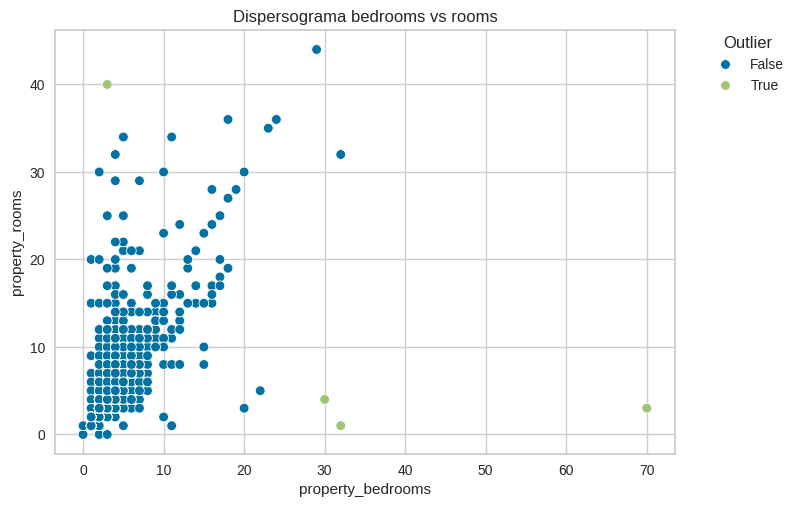

In [215]:
# Grafico scatter
es_outlier = reparado["mahalanobis"] > umbral

sns.scatterplot(x=reparado['property_bedrooms'], y=reparado['property_rooms'], hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma bedrooms vs rooms")
plt.show()

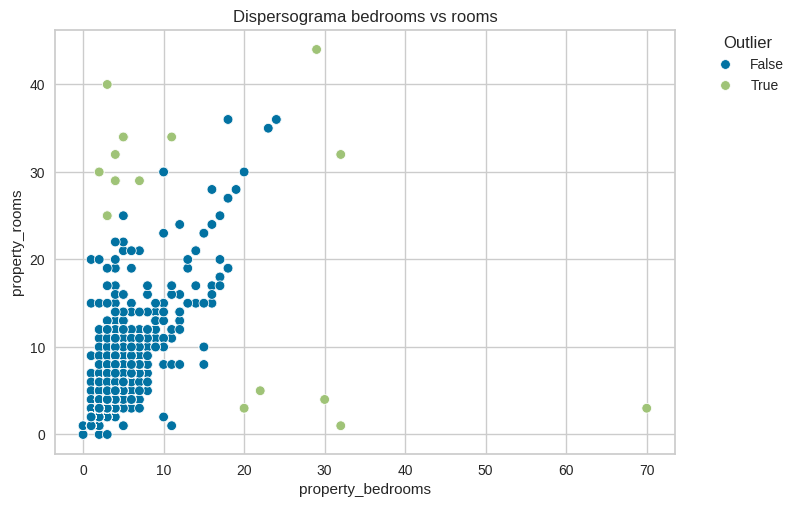

In [216]:
# Grafico scatter
es_outlier = reparado["mahalanobis"] > umbral_min

sns.scatterplot(x=reparado['property_bedrooms'], y=reparado['property_rooms'], hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma bedrooms vs rooms")
plt.show()

Gráficamente, tomando un umbral de 1100, podemos ver que se detectan outliers que realmente estan alejados a la nube de puntos. En cambio bajando más el mismo también considera outliers a puntos que están un poco más cerca de los valores que consideramos lógicos, pero que siguen siendo atípicos. Por lo tanto vamos a eliminar aquellos registros cuya distancia sea mayor a 500.

In [217]:
reparado.drop(reparado[reparado["mahalanobis"] > umbral_min].index, inplace=True)

### Relación entre price vs superfice_total

El trabajo práctico propone también analizar la relación entre precio de venta y los métros de superficie en busca de valores anómalos.

In [218]:
reparado['mahalanobis'] = calculate_mahalanobis_distance(reparado, 'property_price', 'property_surface_total')['mahalanobis']

<Axes: ylabel='mahalanobis'>

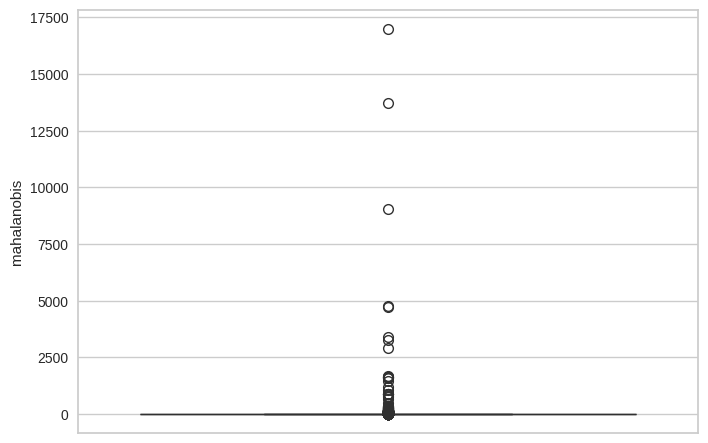

In [219]:
sns.boxplot(y=reparado.mahalanobis)

Como se puede apreciar, también existen valores anómalos que no detectamos anteriormente. Haremos el mismo trabajo de análisis, definiremos un umbral y veremos, de a partes, cómo son y qué proponemos realizar con estos registros.

In [220]:
umbral = 1000
reparado[reparado["mahalanobis"] > umbral]

latitud   longitud             city           zone operation  \
370932 -34.571747 -58.422612  Capital Federal        Palermo     Venta   
72521  -34.600113 -58.403649  Capital Federal      Balvanera     Venta   
60073  -34.616044 -58.458621  Capital Federal      Caballito     Venta   
370922 -34.571747 -58.422612  Capital Federal        Palermo     Venta   
370921 -34.571747 -58.422612  Capital Federal        Palermo     Venta   
84073  -34.588175 -58.396261  Capital Federal       Recoleta     Venta   
356064 -31.198907 -60.159719  Capital Federal       Saavedra     Venta   
370919 -34.571747 -58.422612  Capital Federal        Palermo     Venta   
72316  -34.578917 -58.429373  Capital Federal        Palermo     Venta   
129214 -34.599421 -58.386867  Capital Federal   Barrio Norte     Venta   
106598 -34.587320 -58.401556  Capital Federal   Barrio Norte     Venta   
219021 -34.636532 -58.376406  Capital Federal       Barracas     Venta   
372779 -34.555278 -58.459786  Capital Federal       Belgrano     Venta   
405324 -34.569963 -58.481658  Capital Federal  Villa Urquiza     Venta   
117835 -34.550093 -58.483034  Capital Federal       Saavedra     Venta   
370920 -34.571747 -58.422612  Capital Federal        Palermo     Venta   
370917 -34.571747 -58.422612  Capital Federal        Palermo     Venta   
85725  -34.572494 -58.462433  Capital Federal       Belgrano     Venta   

       property_type  property_rooms  property_bedrooms  \
370932  Departamento             4.0                3.0   
72521   Departamento             2.0                1.0   
60073   Departamento             3.0                2.0   
370922  Departamento             5.0                4.0   
370921  Departamento             5.0                4.0   
84073   Departamento             1.0                1.0   
356064          Casa            15.0                2.0   
370919  Departamento             5.0                4.0   
72316   Departamento             2.0                1.0   
129214  Departamento             5.0                3.0   
106598  Departamento             2.0                1.0   
219021  Departamento             4.0                3.0   
372779  Departamento             4.0                3.0   
405324            PH             4.0                3.0   
117835  Departamento             2.0                1.0   
370920  Departamento             5.0                4.0   
370917  Departamento             4.0                3.0   
85725           Casa             5.0                4.0   

        property_surface_total  property_surface_covered  property_price  \
370932                 42110.0                     307.0       1691800.0   
72521                  33800.0                   31670.0         66000.0   
60073                     68.0                      64.0      21400000.0   
370922                 42110.0                     307.0       2829000.0   
370921                 42110.0                     307.0       2890500.0   
84073                  36000.0                      30.0         90000.0   
356064                 60000.0                     350.0        186000.0   
370919                 42110.0                     307.0       3044250.0   
72316                  61130.0                   53030.0        225000.0   
129214                137000.0                     135.0        390000.0   
106598                 56740.0                   52540.0        175000.0   
219021                 72060.0                      90.0        210000.0   
372779                100068.0                  100051.0        420000.0   
405324                123000.0                  123000.0        165000.0   
117835                 43086.0                   40038.0        114000.0   
370920                 42110.0                     307.0       2890500.0   
370917                 42110.0                     222.0       1910920.0   
85725                   3197.0                    3367.0      12000000.0   

                                    

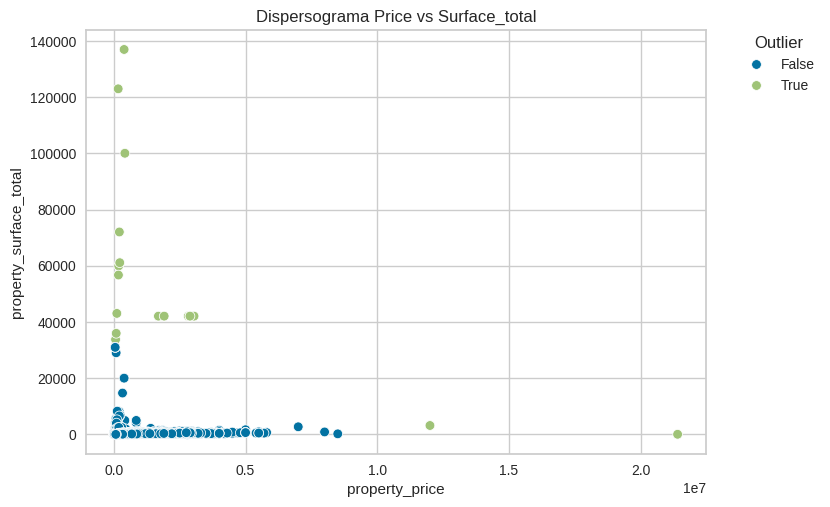

In [221]:
# Grafico scatter
es_outlier = reparado["mahalanobis"] > 1000

sns.scatterplot(x=reparado['property_price'], y=reparado['property_surface_total'], hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma Price vs Surface_total")
plt.show()

Son registros que difieren mucho con respecto a otros. Pueden tratarse de errores de tipeo o simplemente propiedades que se encuentren en diferentes zonas que influyen en el precio del inmueble a pesar de que tengan la misma superficie. En este caso tomamos la decisión de dejar estos puntos dentro del dataset.

# **2. Agrupamiento**

## a)Analizar la tendencia al clustering del dataset.
Primero instalo la libreria pyclustertend:


In [222]:
!pip install pyclustertend==1.4.9

Ahora calculo hopkins:

In [223]:
from pyclustertend import hopkins
from sklearn.preprocessing import scale, MinMaxScaler

In [224]:
reparado

latitud   longitud             city              zone operation  \
285884 -34.621390 -58.506366  Capital Federal      Monte Castro     Venta   
120762 -34.563005 -58.453674  Capital Federal          Belgrano     Venta   
419659 -34.612349 -58.491906  Capital Federal  Villa del Parque     Venta   
21443  -34.620806 -58.397336  Capital Federal             Boedo     Venta   
103677 -34.558229 -58.446708  Capital Federal          Belgrano     Venta   
...           ...        ...              ...               ...       ...   
30514  -34.569953 -58.488393  Capital Federal     Villa Urquiza     Venta   
268902 -34.555575 -58.438803  Capital Federal          Belgrano     Venta   
379634 -34.638700 -58.374163  Capital Federal          Barracas     Venta   
4766   -34.607558 -58.421838  Capital Federal           Almagro     Venta   
75496  -34.595472 -58.403536  Capital Federal          Recoleta     Venta   

       property_type  property_rooms  property_bedrooms  \
285884  Departamento             3.0                2.0   
120762  Departamento             3.0                2.0   
419659  Departamento             3.0                2.0   
21443             PH             3.0                2.0   
103677  Departamento             3.0                2.0   
...              ...             ...                ...   
30514   Departamento             3.0                2.0   
268902  Departamento             3.0                2.0   
379634  Departamento             1.0                1.0   
4766    Departamento             2.0                1.0   
75496   Departamento             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
285884                    51.0                      44.0        112000.0   
120762                    79.0                      66.0        299900.0   
419659                   110.0                      80.0        249000.0   
21443                     97.0                      67.0        135000.0   
103677                    89.0                      89.0        300000.0   
...                        ...                       ...             ...   
30514                    100.0                      75.0        199000.0   
268902                    91.0                      81.0        333000.0   
379634                    43.0                      36.0         99800.0   
4766                      34.0                      34.0         76120.0   
75496                     34.0                      33.0         74900.0   

                                           property_title  mahalanobis  
285884  Venta tres ambientes chico cochera y amplio ba...     0.134248  
120762         VENTA DEPARTAMENTO 3 AMB COCHERA  BELGRANO     0.062156  
419659  VENTA | DEPARTAMENTO |3 AMBIENTES | V. DEL PARQUE     0.006317  
21443                                        Casa - Boedo     0.084562  
103677                            Departamento - Belgrano     0.061451  
...                                                   ...          ...  
30514           DEPARTAMENTO 3 AMBIENTES - VILLA URQUIZA      0.006920  
268902           Adelanto y 12 cuotas en pesos - Belgrano     0.125829  
379634      Departamento premium - mejor zona de Barracas     0.165003  
4766                               Departamento - Almagro     0.233266  
75496                 DEPTO 2 AMB VENTA LAVADERO RECOLETA     0.237071  

[75156 rows x 13 columns]

In [225]:
df_clust = reparado.drop(columns=["city","zone","operation","property_type","property_title"])
scaler = MinMaxScaler()
df_escalado = scaler.fit_transform(df_clust)
x = df_clust.iloc[:,2:4]
x_norm = (x-x.min())/(x.max()-x.min())
x_norm.describe()

hopkins(x,x.shape[0])

0.00040710193206310724

Como el valor de hopkins tiende al 0 y teniendo en cuenta la hipótesis nula se puede deducir que no hay cluster significativos.

## b) Estimar la cantidad apropiada de grupos que se deben formar.

Para este punto usaremos el Elbow Method:

In [226]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=UserWarning)

Text(0, 0.5, 'Distancia promedio al centroide')

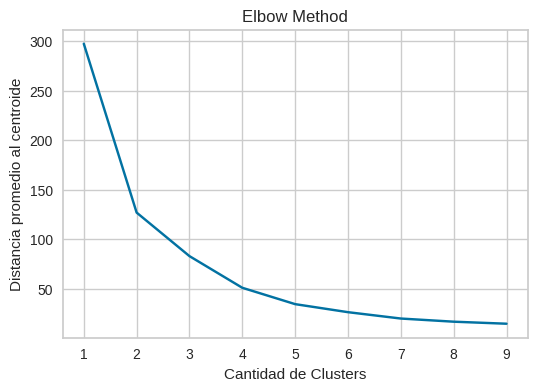

In [227]:
distancias_prom = []
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(x_norm)
  iner = kmeans.inertia_
  distancias_prom.append(iner)

cant_clust = range(1,10)
plt.figure(figsize=(6,4))
plt.plot(cant_clust,distancias_prom)
plt.title('Elbow Method')
plt.xlabel('Cantidad de Clusters')
plt.ylabel('Distancia promedio al centroide')

En base al gráfico podemos deducir que utilizar 3 o 4 clusters sería lo ideal:

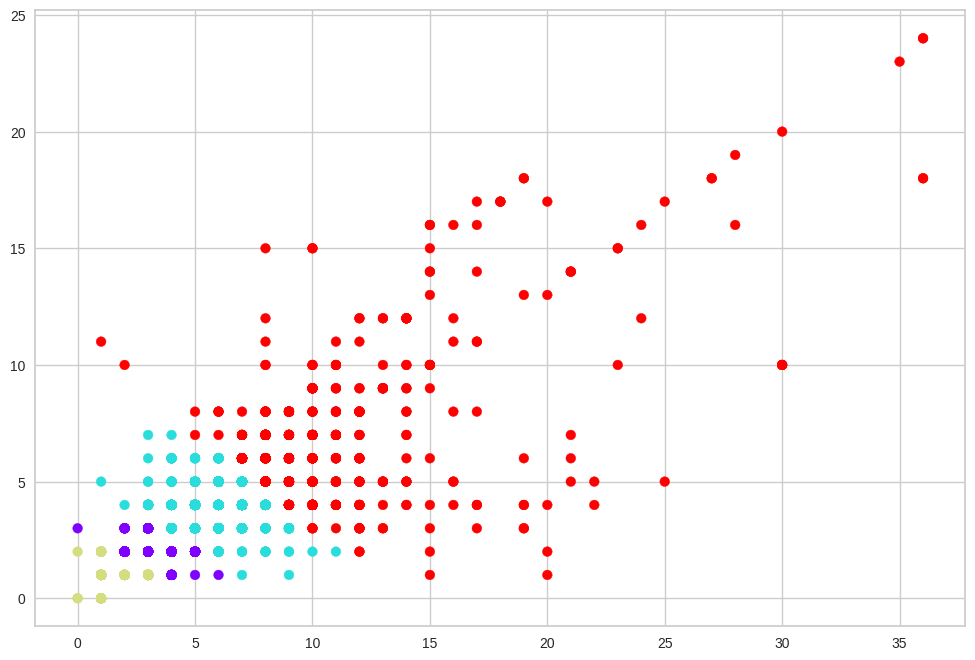

In [228]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_norm)
identified_clusters = kmeans.fit_predict(x_norm)
data_with_clusters = df_clust.copy()
data_with_clusters['cluster'] = identified_clusters
plt.figure(figsize=(12,8))
plt.scatter(data_with_clusters["property_rooms"], data_with_clusters["property_bedrooms"], c=data_with_clusters["cluster"], cmap='rainbow')
plt.show()

## c) Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.

In [229]:
from sklearn.metrics import silhouette_score

list_k = list(range(3,7))

for n in list_k:
  clusterer = KMeans(n_clusters=n)
  preds = clusterer.fit_predict(x_norm)

  score = silhouette_score(x_norm,preds)
  print('For n = ' + str(n) + ' silhouette score is ' + str(score))

For n = 3 silhouette score is 0.6758891736467029
For n = 4 silhouette score is 0.7514454226124341
For n = 5 silhouette score is 0.771281844990221
For n = 6 silhouette score is 0.7942618227464839


Viendo estos resultados notamos que al haber 4 clusters aumenta el score notablemente y que la diferencia entre 4 y 7 no es tan grande.

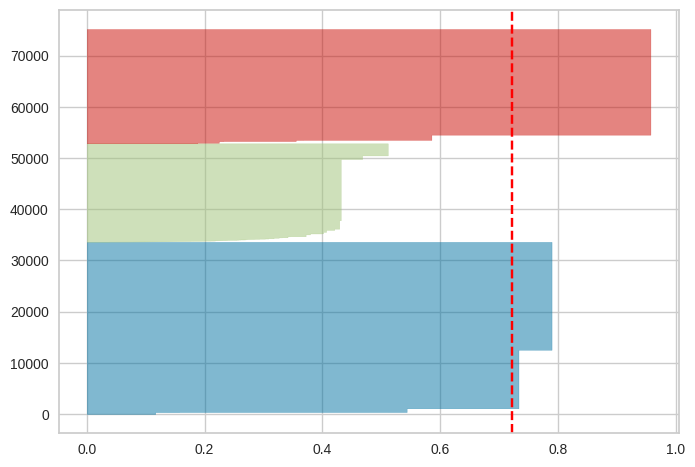

In [230]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=3,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

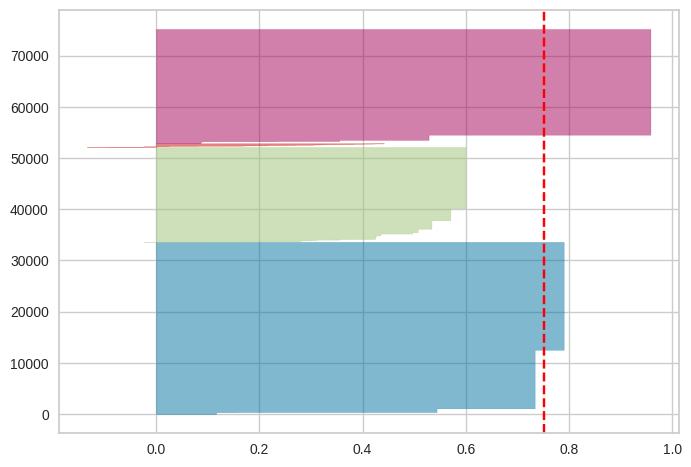

In [231]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=4,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

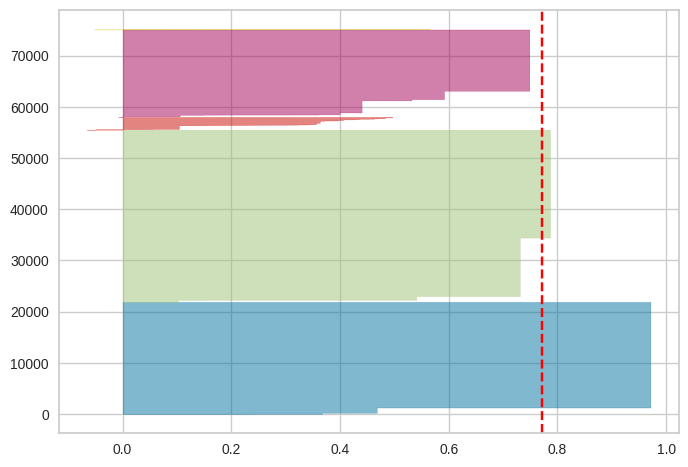

In [232]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

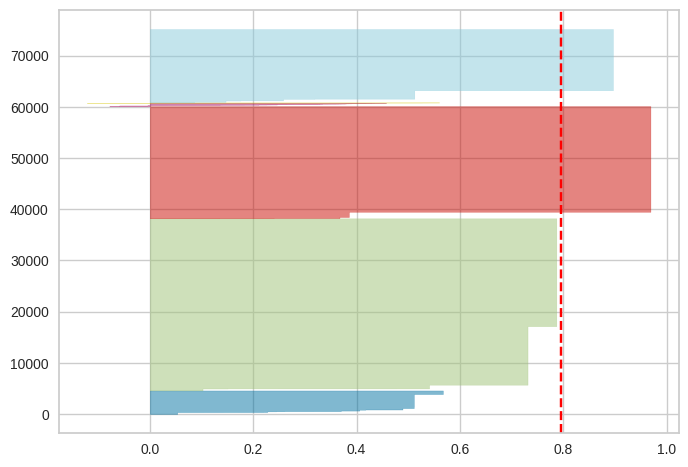

In [233]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=6,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

Tomando en cuenta los gráficos parece que elegir 3 clusters es lo correcto, tanto por los outliers como por el tamaño de los clusters.

## d) Analizar los grupos formados.

Tomamos como ejemplo armar cuatro clusters, más adelante analizaremos lo que sucede si elegimos tres.

In [234]:
data_with_clusters['cluster'].unique()

array([0, 2, 1, 3], dtype=int32)

In [235]:
df = reparado.copy()

In [236]:
df['cluster'] = data_with_clusters['cluster']

In [237]:
df[df['cluster'] == 3]['zone'].unique()

array(['Chacarita', 'Colegiales', 'Parque Chacabuco', 'Recoleta',
       'San Nicolás', 'Boedo', 'Palermo Chico', 'Villa del Parque',
       'Once', 'Belgrano', 'Barracas', 'Caballito', 'Balvanera',
       'Congreso', 'San Telmo', 'Parque Avellaneda', 'Boca',
       'Barrio Norte', 'Retiro', 'Villa Pueyrredón', 'Villa Urquiza',
       'Palermo Soho', 'Villa Real', 'Palermo', 'Mataderos',
       'San Cristobal', 'Velez Sarsfield', 'Flores', 'Parque Patricios',
       'Tribunales', 'Monserrat', 'Palermo Hollywood', 'Nuñez', 'Liniers',
       'Almagro', 'Constitución', 'Villa Luro', 'Villa Devoto',
       'Saavedra', 'Villa Crespo', 'Versalles', 'Villa Ortuzar',
       'Villa Lugano', 'Puerto Madero', 'Paternal', 'Pompeya',
       'Villa Santa Rita', 'Villa Riachuelo', 'Monte Castro', 'Floresta',
       'Villa General Mitre', 'Coghlan', 'Catalinas', 'Villa Soldati',
       'Abasto'], dtype=object)

Verificando los barrios de las propiedades que pertenecen dentro del cluster 3, no encontramos que tenga una relacion directa con la formación del mismo.

In [238]:
df.groupby(['cluster','property_type'])['operation'].count()

cluster  property_type
0        Casa               429
         Departamento     18787
         PH                3090
1        Casa              2432
         Departamento     13388
         PH                2708
2        Casa                59
         Departamento     32077
         PH                1477
3        Casa               370
         Departamento       229
         PH                 110
Name: operation, dtype: int64

Todos los grupos poseen propiedades de diferentes tipos. No parece ser la razón por para agruparlos y no se mantiene una relación entre los grupos con respecto a la cantidad de propiedades de cada tipo.

In [239]:
aux = df.groupby(['cluster', 'property_rooms','property_bedrooms'])['property_type'].count().reset_index()

In [240]:
aux[aux['cluster'] == 0]

cluster  property_rooms  property_bedrooms  property_type
0        0             0.0                3.0              1
1        0             2.0                2.0            211
2        0             2.0                3.0             11
3        0             3.0                2.0          20629
4        0             3.0                3.0            293
5        0             4.0                1.0             30
6        0             4.0                2.0           1019
7        0             5.0                1.0              1
8        0             5.0                2.0            110
9        0             6.0                1.0              1

In [241]:
aux[aux['cluster'] == 1]

cluster  property_rooms  property_bedrooms  property_type
10        1             1.0                5.0              1
11        1             2.0                4.0              1
12        1             3.0                4.0             40
13        1             3.0                5.0              2
14        1             3.0                6.0              1
15        1             3.0                7.0              1
16        1             4.0                3.0          11959
17        1             4.0                4.0            241
18        1             4.0                5.0             11
19        1             4.0                6.0              9
20        1             4.0                7.0              1
21        1             5.0                3.0           1646
22        1             5.0                4.0           2361
23        1             5.0                5.0             36
24        1             5.0                6.0              5
25        1             6.0                2.0             34
26        1             6.0                3.0            369
27        1             6.0                4.0            701
28        1             6.0                5.0            382
29        1             6.0                6.0             19
30        1             7.0                1.0              1
31        1             7.0                2.0              3
32        1             7.0                3.0            101
33        1             7.0                4.0            277
34        1             7.0                5.0            175
35        1             8.0                2.0              5
36        1             8.0                3.0             18
37        1             8.0                4.0            106
38        1             9.0                1.0              1
39        1             9.0                2.0              2
40        1             9.0                3.0             17
41        1            10.0                2.0              1
42        1            11.0                2.0              1

In [242]:
aux[aux['cluster'] == 2]

cluster  property_rooms  property_bedrooms  property_type
43        2             0.0                0.0              2
44        2             0.0                2.0              1
45        2             1.0                0.0            727
46        2             1.0                1.0          11430
47        2             1.0                2.0             20
48        2             2.0                1.0          21062
49        2             3.0                1.0            371

A pesar de que tomamos la relación entre bedrooms y rooms, no notamos en los datos una relación fuerte, adjuntamos el gráfico realizado para visualizarlo con mayor claridad.

<Figure size 1200x800 with 0 Axes>

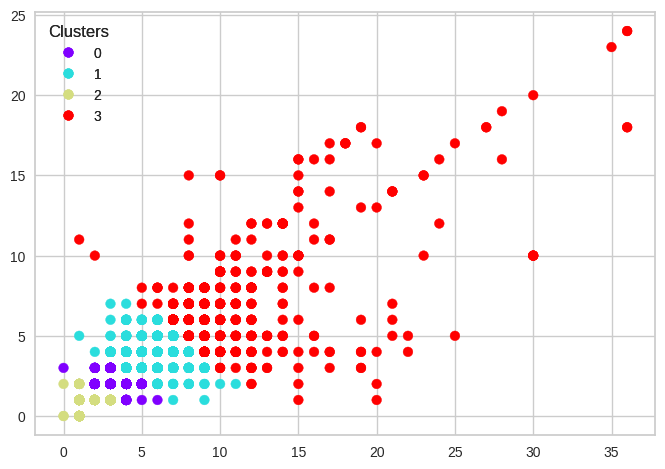

In [243]:
plt.figure(figsize=(12,8))

fig, ax = plt.subplots()
scatter = plt.scatter(data_with_clusters["property_rooms"], data_with_clusters["property_bedrooms"], c=data_with_clusters["cluster"], cmap='rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)


plt.show()

Gráficamente podemos notar que tiene más sentido que fueran agrupados, finalmente, según la relación de cantidad de habitaciones y ambientes. Podemos notar que el grupo 2 posee más catidad de propiedades que el resto, siendo el más chico el 1, tiene sentido por lo analizado por Silhouette en el punto anterior para un grupo de cuatro.

<Axes: xlabel='cluster', ylabel='property_bedrooms'>

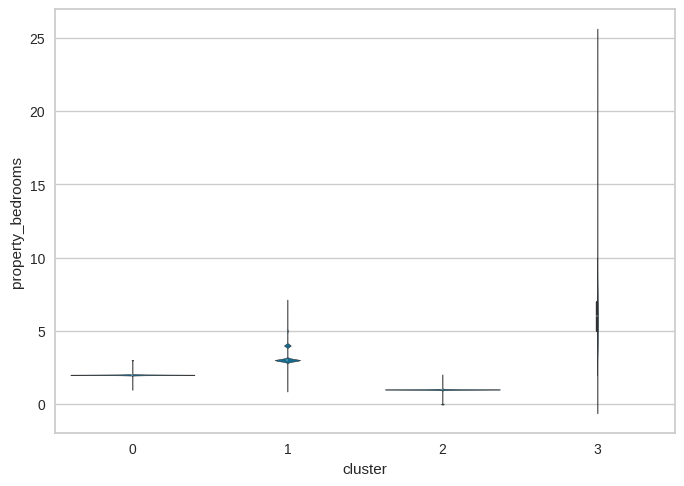

In [244]:
sns.violinplot(data=df, x="cluster", y="property_bedrooms")

Al graficar un violin plot podemos notar que, al tener todavía outliers que decidimos no eliminar, el gráfico no nos aporta mucha información. Tan solo para verlo con mayor claridad, eliminamos el outlier en el cluster 2.

In [245]:
aux=df[df['property_bedrooms'] < 8]

<Axes: xlabel='cluster', ylabel='property_bedrooms'>

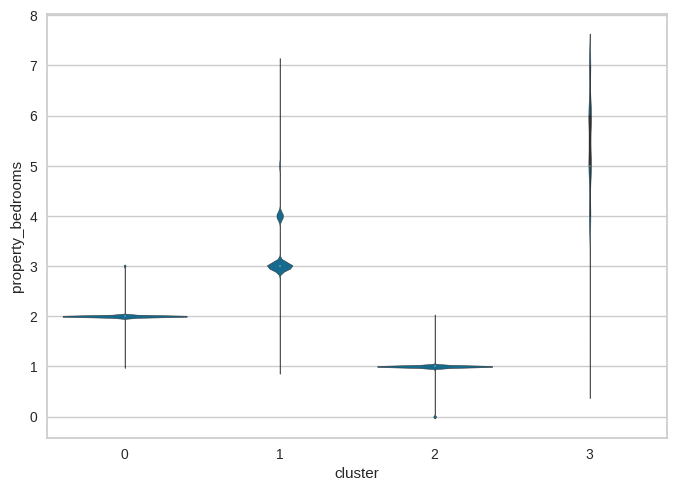

In [246]:
sns.violinplot(data= aux, x="cluster", y="property_bedrooms")

El violin plot nos indica la densidad de registros en cada cluster según la cantidad de habitaciones, en este caso. Podemos ver que el cluster 1 reune más registros de propiedades con una sola habitación, mientras que el 0 de propiedades entre 3 y 2 habitaciones y, el último cluster 2, a pesar de que también parece tener registros de tres habitaciones, reune a los que poseen más de 3 habitaciones.

<Axes: xlabel='cluster', ylabel='property_rooms'>

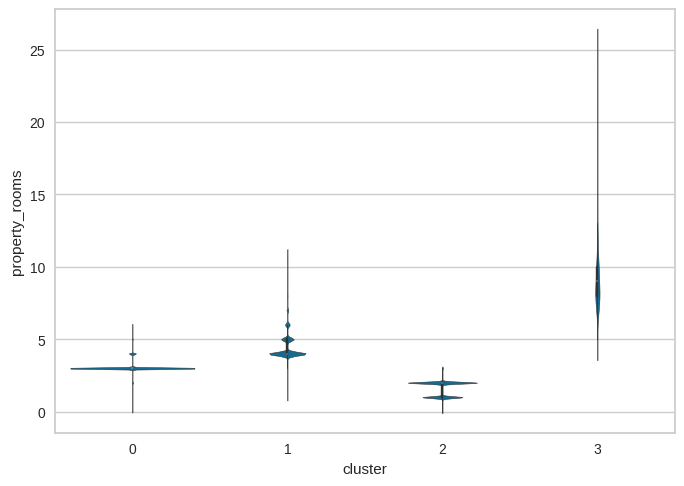

In [247]:
sns.violinplot(data=aux, x="cluster", y="property_rooms")

Para una visualización mejor volvemos a quitar el outlier en el gráfico.

<Axes: xlabel='cluster', ylabel='property_rooms'>

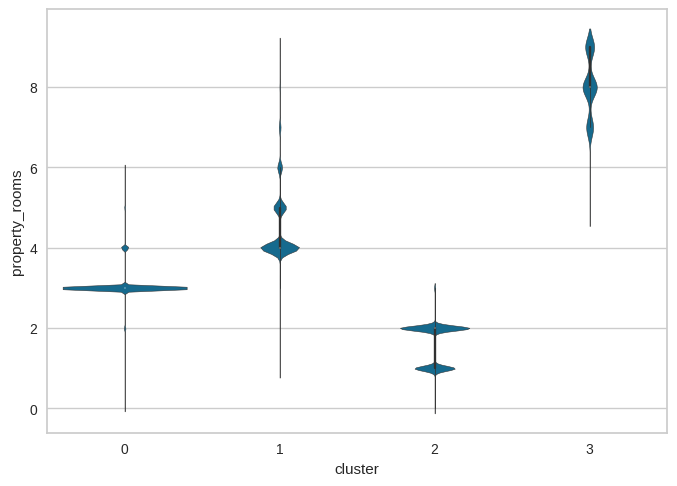

In [248]:
sns.violinplot(data= aux[aux['property_rooms'] < 10], x="cluster", y="property_rooms")

Vemos que para el caso de los ambientes sigue teniendo relación la división de clusters. Las propiedades con menor cantidad de ambientes están agrupados en 1, de 3 a 5 en el cluster 0 y, por último, los que poseen más en el cluster 2.

## e) Graficar sobre un mapa de CABA los avisos coloreados según el grupo al que pertenecen.

In [249]:
data_with_clusters = data_with_clusters[data_with_clusters["latitud"]>-34.69]
data_with_clusters = data_with_clusters[data_with_clusters["latitud"]<-34.525]


data_with_clusters = data_with_clusters[data_with_clusters["longitud"]>-58.53]
data_with_clusters = data_with_clusters[data_with_clusters["longitud"]<-58.34]

In [250]:
caba_gdf = gpd.read_file("/content/drive/MyDrive/comunas_wgs84.shp")

In [251]:
data_with_clusters

latitud   longitud  property_rooms  property_bedrooms  \
285884 -34.621390 -58.506366             3.0                2.0   
120762 -34.563005 -58.453674             3.0                2.0   
419659 -34.612349 -58.491906             3.0                2.0   
21443  -34.620806 -58.397336             3.0                2.0   
103677 -34.558229 -58.446708             3.0                2.0   
...           ...        ...             ...                ...   
30514  -34.569953 -58.488393             3.0                2.0   
268902 -34.555575 -58.438803             3.0                2.0   
379634 -34.638700 -58.374163             1.0                1.0   
4766   -34.607558 -58.421838             2.0                1.0   
75496  -34.595472 -58.403536             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
285884                    51.0                      44.0        112000.0   
120762                    79.0                      66.0        299900.0   
419659                   110.0                      80.0        249000.0   
21443                     97.0                      67.0        135000.0   
103677                    89.0                      89.0        300000.0   
...                        ...                       ...             ...   
30514                    100.0                      75.0        199000.0   
268902                    91.0                      81.0        333000.0   
379634                    43.0                      36.0         99800.0   
4766                      34.0                      34.0         76120.0   
75496                     34.0                      33.0         74900.0   

        mahalanobis  cluster  
285884     0.134248        0  
120762     0.062156        0  
419659     0.006317        0  
21443      0.084562        0  
103677     0.061451        0  
...             ...      ...  
30514      0.006920        0  
268902     0.125829        0  
379634     0.165003        2  
4766       0.233266        2  
75496      0.237071        2  

[74955 rows x 9 columns]

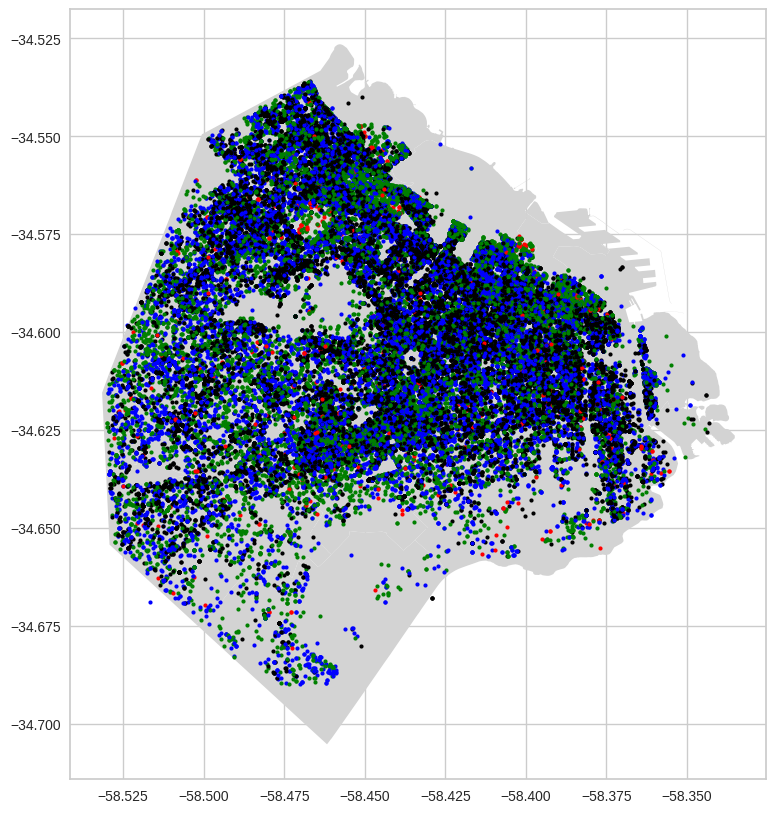

In [252]:
fig, ax = plt.subplots(figsize=(10, 10))
caba_gdf.plot(ax=ax, color='lightgray')

for i in range(0,data_with_clusters.shape[0]):
  prop = data_with_clusters.iloc[i]
  lon = prop['longitud']
  lat = prop['latitud']
  col = 'red'
  if prop['cluster'] == 0:
    col = 'blue'
  if prop['cluster'] == 1:
    col = 'green'
  if prop['cluster'] == 2:
    col = 'black'

  plt.plot(lon,lat, marker="o", color=col, markersize=3)


### 2f) Realizar nuevamente el análisis utilizando solamente 3 grupos.

In [253]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(x_norm)
identified_clusters = kmeans.fit_predict(x_norm)

data_with_clusters = df_clust.copy()
data_with_clusters['cluster'] = identified_clusters

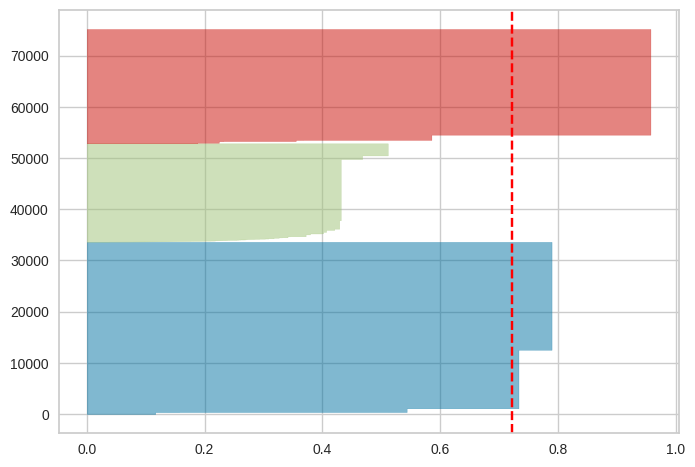

In [254]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=3,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

El tamaño de los clusters son similares para los tres grupos, al menos resulta mucho mejor que los analizados con otras cantidades de grupos. El agrupamiento igual sigue siendo malo ya que el grupo verde no llega a pasar la puntuación media de la silueta y nos indica que estas instancias están demasiado cerca de otros grupos.

<Figure size 1200x800 with 0 Axes>

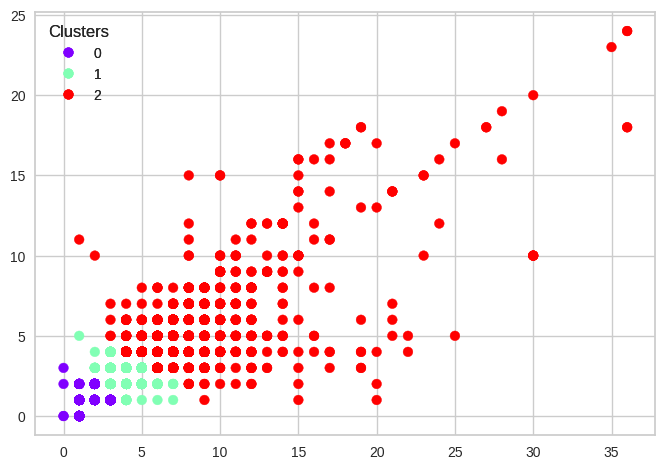

In [255]:
plt.figure(figsize=(12,8))

fig, ax = plt.subplots()
scatter = plt.scatter(data_with_clusters["property_rooms"], data_with_clusters["property_bedrooms"], c=data_with_clusters["cluster"], cmap='rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)


plt.show()

Se puede apreciar que el grupo 2 sigue teniendo un mayor volumen de registros que los otros grupos y visualmente agrupa los registros de propiedades con más habitaciones.

In [256]:
df = reparado.copy()
df['cluster'] = data_with_clusters['cluster']

In [257]:
df.groupby(['cluster', 'property_type'])['zone'].count()

cluster  property_type
0        Casa                61
         Departamento     32263
         PH                1501
1        Casa              1587
         Departamento     29160
         PH                5032
2        Casa              1642
         Departamento      3058
         PH                 852
Name: zone, dtype: int64

No parece tener una relación clara el tipo de propiedad con los agrupamientos, pero en los tres grupos la cantidad de departamentos es mucho mayor que el resto.

In [258]:
data_with_clusters = data_with_clusters[data_with_clusters["latitud"]>-34.69]
data_with_clusters = data_with_clusters[data_with_clusters["latitud"]<-34.525]


data_with_clusters = data_with_clusters[data_with_clusters["longitud"]>-58.53]
data_with_clusters = data_with_clusters[data_with_clusters["longitud"]<-58.34]

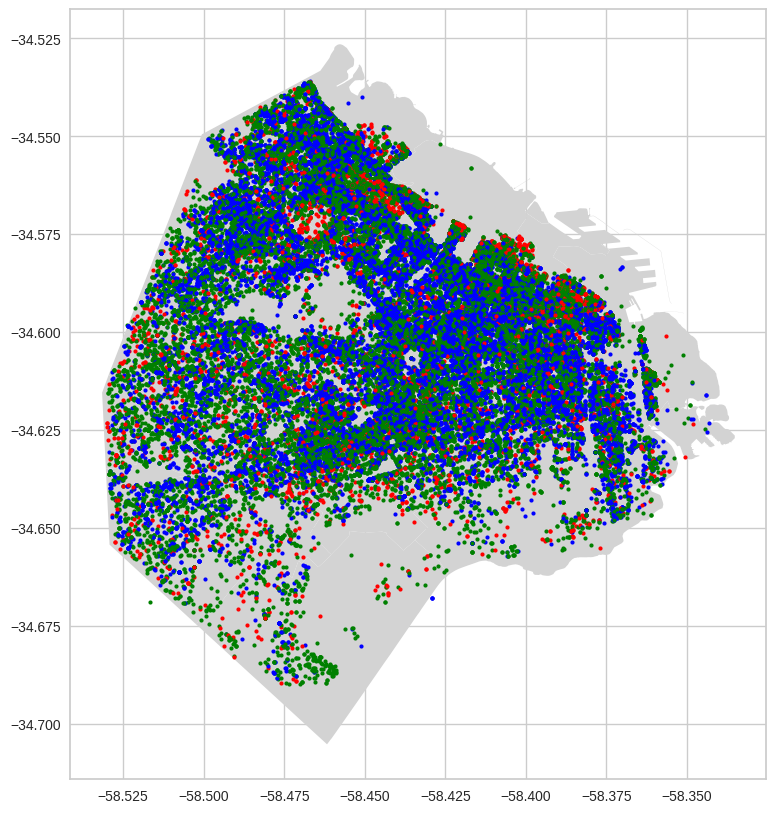

In [259]:
fig, ax = plt.subplots(figsize=(10, 10))
caba_gdf.plot(ax=ax, color='lightgray')

for i in range(0,data_with_clusters.shape[0]):
  prop = data_with_clusters.iloc[i]
  lon = prop['longitud']
  lat = prop['latitud']
  col = 'red'
  if prop['cluster'] == 0:
    col = 'blue'
  if prop['cluster'] == 1:
    col = 'green'

  plt.plot(lon,lat, marker="o", color=col, markersize=3)


Observando el mapa tampoco vemos una distinción clara de los agrupamientos según su dirección en el mapa, salvo que el grupo 1, los puntos verdes, no se encuentran concentrados en el sector sur de la ciudad.

Al igual que en el punto anterior visualizamos en un violin plot la densidad de registros en cada cluster según cantidad de habitaciones y ambientes. Al tener outliers que decidimos no eliminar, para la visualización decidimos cortarlos para poder analizar el gráfico con más claridad en ambos casos.

<Axes: xlabel='cluster', ylabel='property_bedrooms'>

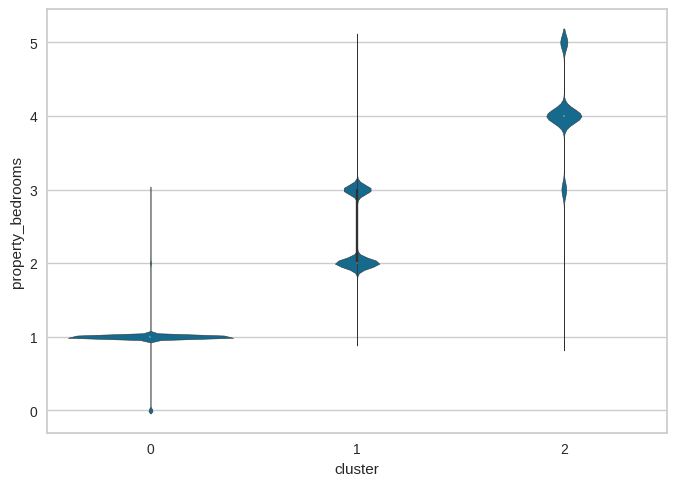

In [260]:
sns.violinplot(data= df[df['property_bedrooms'] < 6], x="cluster", y="property_bedrooms")

En este último gráfico podemos observar que, nuevamente, el cluster 1 agrupa las propiedades con menos habitaciones, y el 2 con más. También encontramos propiedades con 4 habitaciones, por ejemplo, dentro del grupo 1 como también del 2.

<Axes: xlabel='cluster', ylabel='property_rooms'>

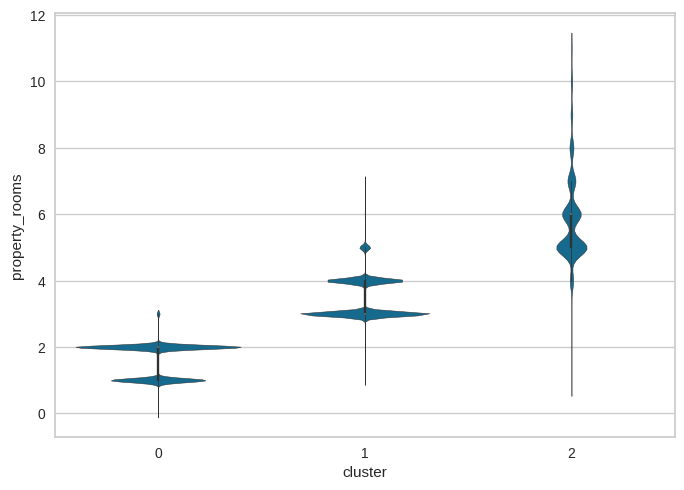

In [261]:
sns.violinplot(data= df[df['property_rooms'] < 12], x="cluster", y="property_rooms")

El análisis anterior es similar al de ambientes. El grupo 0 contiene propiedades con pocos ambientes y el 2 con más, observando también que podemos encontrar propiedades con 3 ambientes, por ejemplo, en el grupo 4, en menor medida, y en el grupo 1 también.

# **3. Clasificación**

**a) Construcción del target**

Primero agregamos la columna "pxm2" y por cada propiedad calculamos su valor.

In [262]:
reparado.drop(['mahalanobis'], axis=1, inplace=True)

In [263]:
reparado.insert(12, "pxm2", "NaN", allow_duplicates=False)

In [264]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  precio = fila["property_price"]
  sup_tot = fila["property_surface_total"]
  pxm2 = precio/sup_tot
  reparado.iat[i, 12] = pxm2

Ahora tenemos la columna pxm2:

In [265]:
reparado = reparado[reparado['pxm2']<25000] #Elimino outliers
reparado

latitud   longitud             city              zone operation  \
285884 -34.621390 -58.506366  Capital Federal      Monte Castro     Venta   
120762 -34.563005 -58.453674  Capital Federal          Belgrano     Venta   
419659 -34.612349 -58.491906  Capital Federal  Villa del Parque     Venta   
21443  -34.620806 -58.397336  Capital Federal             Boedo     Venta   
103677 -34.558229 -58.446708  Capital Federal          Belgrano     Venta   
...           ...        ...              ...               ...       ...   
30514  -34.569953 -58.488393  Capital Federal     Villa Urquiza     Venta   
268902 -34.555575 -58.438803  Capital Federal          Belgrano     Venta   
379634 -34.638700 -58.374163  Capital Federal          Barracas     Venta   
4766   -34.607558 -58.421838  Capital Federal           Almagro     Venta   
75496  -34.595472 -58.403536  Capital Federal          Recoleta     Venta   

       property_type  property_rooms  property_bedrooms  \
285884  Departamento             3.0                2.0   
120762  Departamento             3.0                2.0   
419659  Departamento             3.0                2.0   
21443             PH             3.0                2.0   
103677  Departamento             3.0                2.0   
...              ...             ...                ...   
30514   Departamento             3.0                2.0   
268902  Departamento             3.0                2.0   
379634  Departamento             1.0                1.0   
4766    Departamento             2.0                1.0   
75496   Departamento             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
285884                    51.0                      44.0        112000.0   
120762                    79.0                      66.0        299900.0   
419659                   110.0                      80.0        249000.0   
21443                     97.0                      67.0        135000.0   
103677                    89.0                      89.0        300000.0   
...                        ...                       ...             ...   
30514                    100.0                      75.0        199000.0   
268902                    91.0                      81.0        333000.0   
379634                    43.0                      36.0         99800.0   
4766                      34.0                      34.0         76120.0   
75496                     34.0                      33.0         74900.0   

                                           property_title         pxm2  
285884  Venta tres ambientes chico cochera y amplio ba...  2196.078431  
120762         VENTA DEPARTAMENTO 3 AMB COCHERA  BELGRANO  3796.202532  
419659  VENTA | DEPARTAMENTO |3 AMBIENTES | V. DEL PARQUE  2263.636364  
21443                                        Casa - Boedo  1391.752577  
103677                            Departamento - Belgrano  3370.786517  
...                                                   ...          ...  
30514           DEPARTAMENTO 3 AMBIENTES - VILLA URQUIZA        1990.0  
268902           Adelanto y 12 cuotas en pesos - Belgrano  3659.340659  
379634      Departamento premium - mejor zona de Barracas  2320.930233  
4766                               Departamento - Almagro  2238.823529  
75496                 DEPTO 2 AMB VENTA LAVADERO RECOLETA  2202.941176  

[75153 rows x 13 columns]

Primero divido en igual cantidad de observaciones:

In [266]:
alt_1 = reparado.copy()

cuantiles = alt_1['pxm2'].quantile([0.33, 0.66])

alt_1['tipo_precio'] = pd.cut(alt_1['pxm2'], bins=[float('-inf'), cuantiles.iloc[0], cuantiles.iloc[1], float('inf')], labels=['bajo', 'medio', 'alto'])

cant_tipos = alt_1['tipo_precio'].value_counts()
elem_por_categoria = cant_tipos.min()
alt_1 = alt_1.groupby('tipo_precio').apply(lambda x: x.sample(elem_por_categoria)).reset_index(drop=True)

alt_1['tipo_precio'].value_counts()


tipo_precio
bajo     24769
medio    24769
alto     24769
Name: count, dtype: int64

Luego la 2da alternativa:

In [267]:
alt_2 = reparado.copy()
percentiles = [0, 0.25, 0.75, 1]
labels = ['bajo', 'medio', 'alto']
alt_2["tipo_precio"] = pd.cut(alt_2["pxm2"], bins=alt_2["pxm2"].quantile(percentiles), labels=labels)
alt_2['tipo_precio'].value_counts()

tipo_precio
medio    37584
bajo     18788
alto     18780
Name: count, dtype: int64

Para la 3er alternativa hay que volver a calcular el pxm2 para poder dividir por el tipo de propiedad:

Para esta alternativa voy a dividirlo en 2:

*   alt_3_dptos
*   alt_3_ph



In [268]:
alt_3_dptos = reparado[reparado.copy()['property_type']=='Departamento']

percentiles = [0, 0.25, 0.75, 1]

labels = ['bajo', 'medio', 'alto']
alt_3_dptos["tipo_precio"] = pd.cut(alt_3_dptos["pxm2"], bins=alt_3_dptos["pxm2"].quantile(percentiles), labels=labels)
print('alt_3_dptos:')
alt_3_dptos['tipo_precio'].value_counts()



alt_3_dptos:


<ipython-input-268-d4a86b60470a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alt_3_dptos["tipo_precio"] = pd.cut(alt_3_dptos["pxm2"], bins=alt_3_dptos["pxm2"].quantile(percentiles), labels=labels)


tipo_precio
medio    32248
bajo     16114
alto     16111
Name: count, dtype: int64

In [269]:
alt_3_ph = reparado[reparado.copy()['property_type']=='PH']

labels = ['bajo', 'medio', 'alto']
alt_3_ph["tipo_precio"] = pd.cut(alt_3_ph["pxm2"], bins=alt_3_ph["pxm2"].quantile(percentiles), labels=labels)
print('alt_3_PH:')
alt_3_ph['tipo_precio'].value_counts()

alt_3_PH:


<ipython-input-269-d5645a40d04a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alt_3_ph["tipo_precio"] = pd.cut(alt_3_ph["pxm2"], bins=alt_3_ph["pxm2"].quantile(percentiles), labels=labels)


tipo_precio
medio    3692
bajo     1846
alto     1846
Name: count, dtype: int64

a. Mostrar la distribución del precio por metro cuadrado

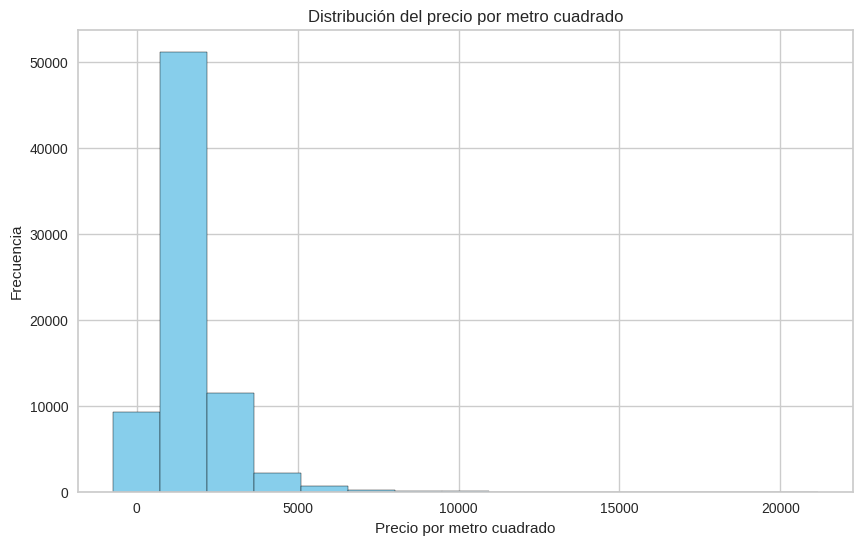

In [270]:
import numpy as np
import matplotlib.pyplot as plt

num_intervalos = 15

intervalos = np.linspace(reparado['pxm2'].min(), reparado['pxm2'].max(), num_intervalos+1)
frecuencia_por_intervalo, _ = np.histogram(reparado['pxm2'], bins=intervalos)

plt.figure(figsize=(10, 6))
plt.bar(intervalos[:-1], frecuencia_por_intervalo, width=np.diff(intervalos), color='skyblue', edgecolor='black')
plt.title('Distribución del precio por metro cuadrado')
plt.xlabel('Precio por metro cuadrado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Podemos ver que la mayoria de las propiedades tienen un pxm2 de aproximadamente 2000 a 3000 dolares

b. Mostrar la distribución del precio por metro cuadrado por tipo de propiedad

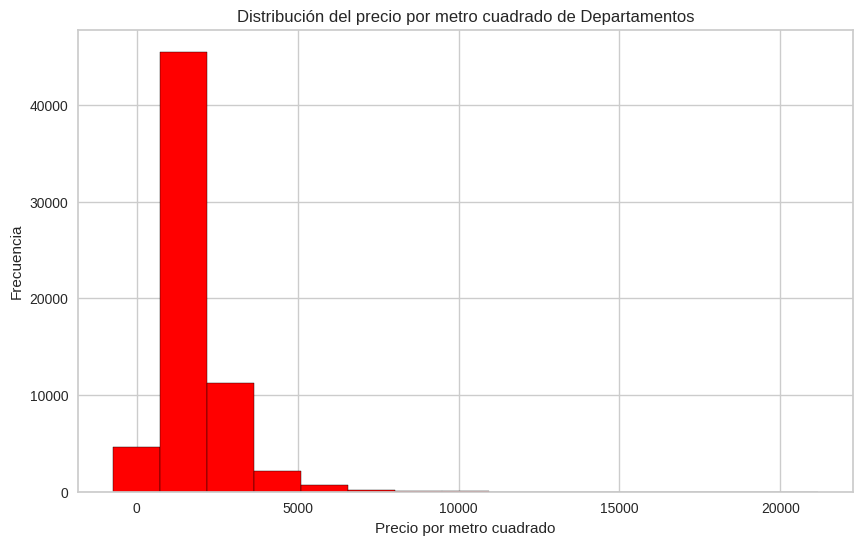

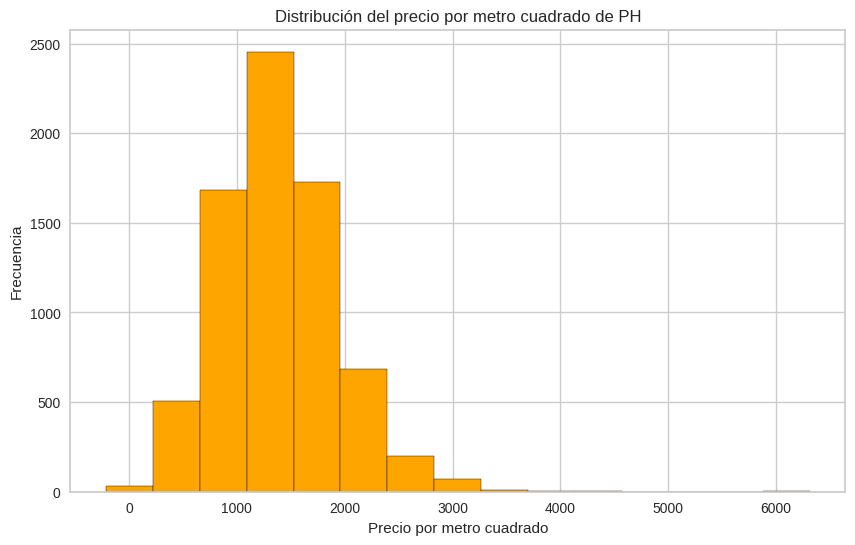

In [271]:
departamentos = reparado.copy()
departamentos = departamentos[departamentos["property_type"]=="Departamento"]
num_intervalos = 15

intervalos = np.linspace(departamentos['pxm2'].min(), departamentos['pxm2'].max(), num_intervalos+1)
frecuencia_por_intervalo, _ = np.histogram(departamentos['pxm2'], bins=intervalos)

plt.figure(figsize=(10, 6))
plt.bar(intervalos[:-1], frecuencia_por_intervalo, width=np.diff(intervalos), color='red', edgecolor='black')
plt.title('Distribución del precio por metro cuadrado de Departamentos')
plt.xlabel('Precio por metro cuadrado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

ph = reparado.copy()
ph = ph[ph["property_type"]=="PH"]
num_intervalos = 15

intervalos = np.linspace(ph['pxm2'].min(), ph['pxm2'].max(), num_intervalos+1)
frecuencia_por_intervalo, _ = np.histogram(ph['pxm2'], bins=intervalos)

plt.figure(figsize=(10, 6))
plt.bar(intervalos[:-1], frecuencia_por_intervalo, width=np.diff(intervalos), color='orange', edgecolor='black')
plt.title('Distribución del precio por metro cuadrado de PH')
plt.xlabel('Precio por metro cuadrado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Lo primero que podemos observar es la diferencia en las frecuencias, esto se debe a que hay menos ph que departamentos y que en el caso de los ph los pxm2 varían más que en el caso de los departamentos. Además se puede observar que el mxp2 de los ph es por lo general más caro que el pxm2 de los departamentos.

c. Para cada una de las tres alternativas mostrar gráficamente la distribución de la
nueva variable creada tipo_precio.

Primero vemos la alternativa 1:

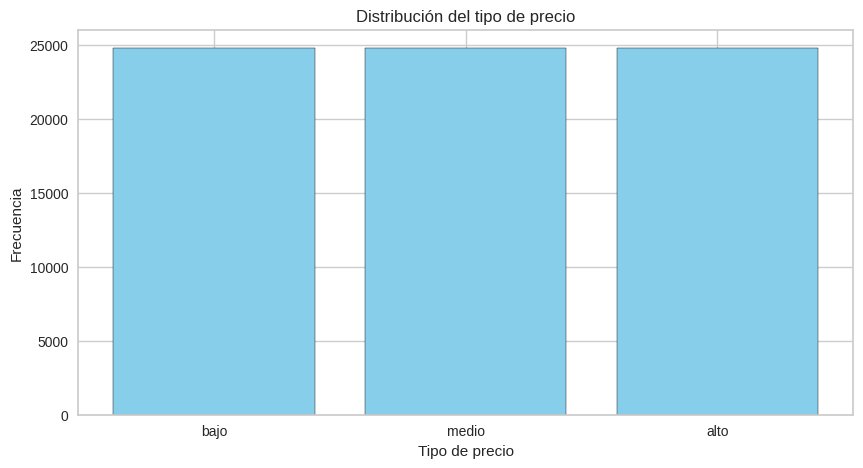

In [272]:
plt.figure(figsize=(10, 5))

frecuencia_por_tipo = alt_1['tipo_precio'].value_counts()

plt.bar(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución del tipo de precio')
plt.xlabel('Tipo de precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Ahora puedo ver la relación entre el tipo de precio y las zonas:  

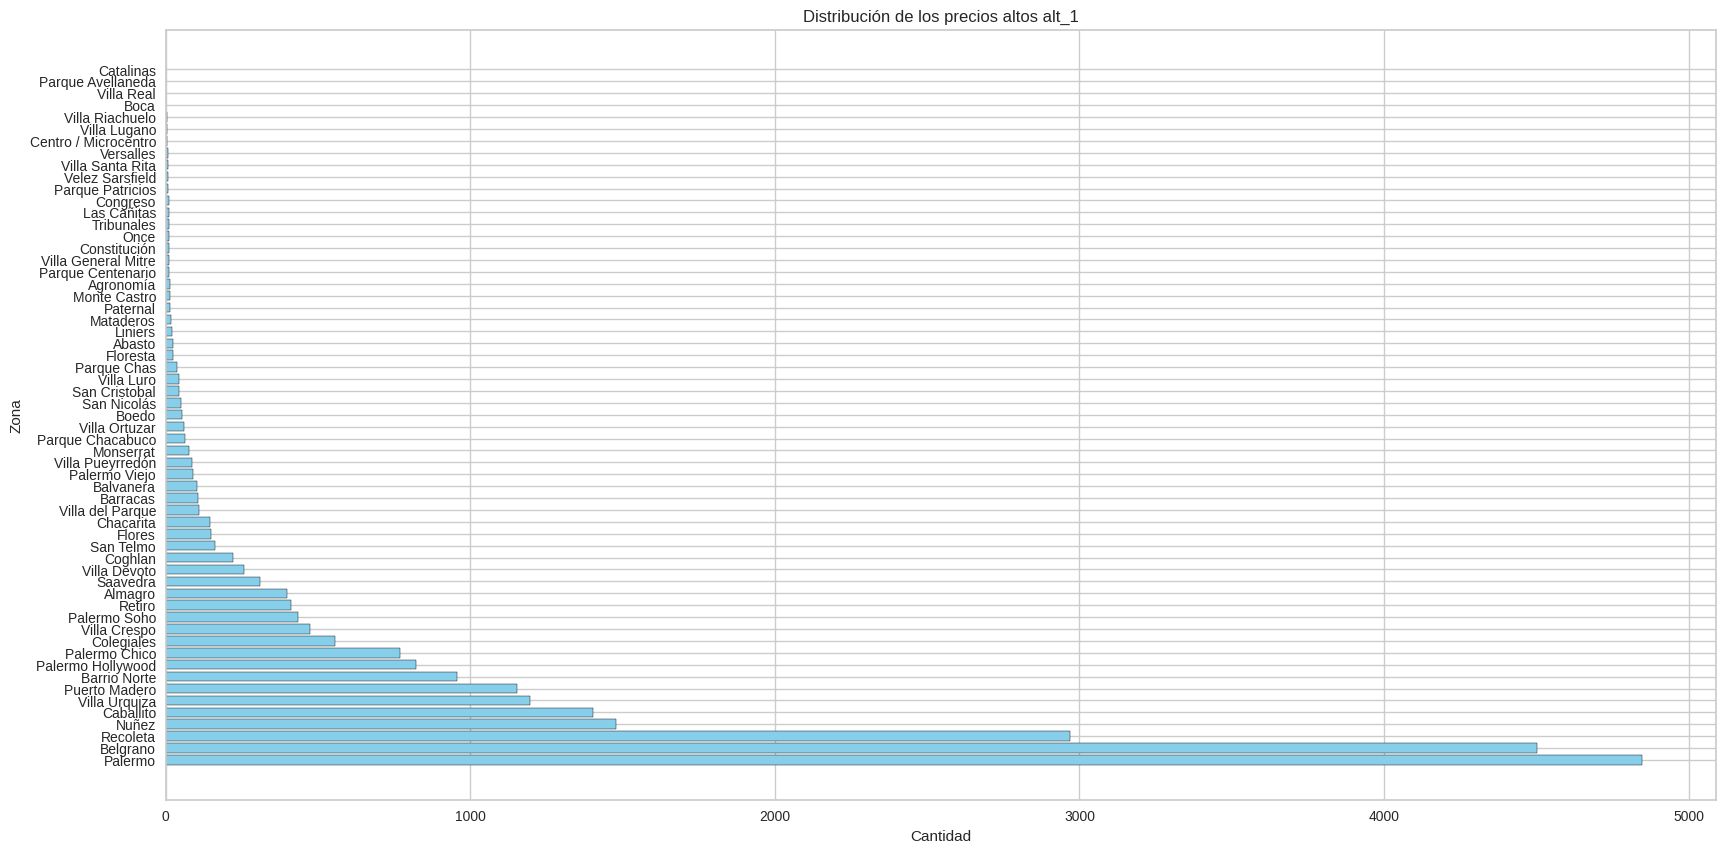

In [273]:
alto = alt_1[alt_1.copy()['tipo_precio']=='alto']


plt.figure(figsize=(20, 10))
frecuencia_por_tipo = alto['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios altos alt_1')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

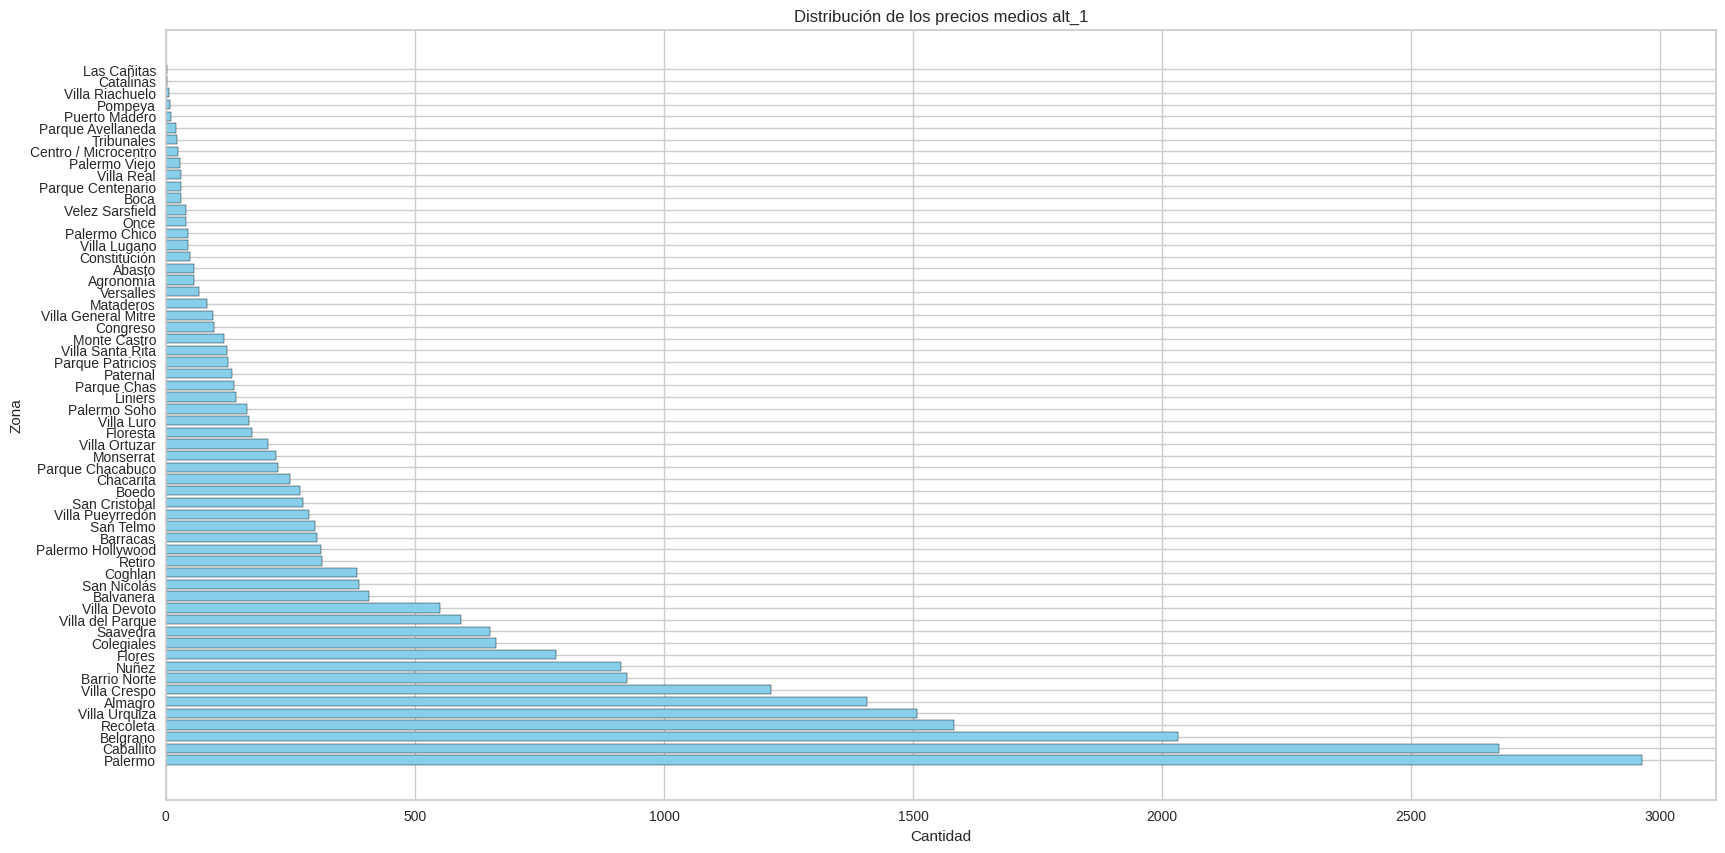

In [274]:
medio = alt_1[alt_1.copy()['tipo_precio']=='medio']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = medio['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios medios alt_1')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

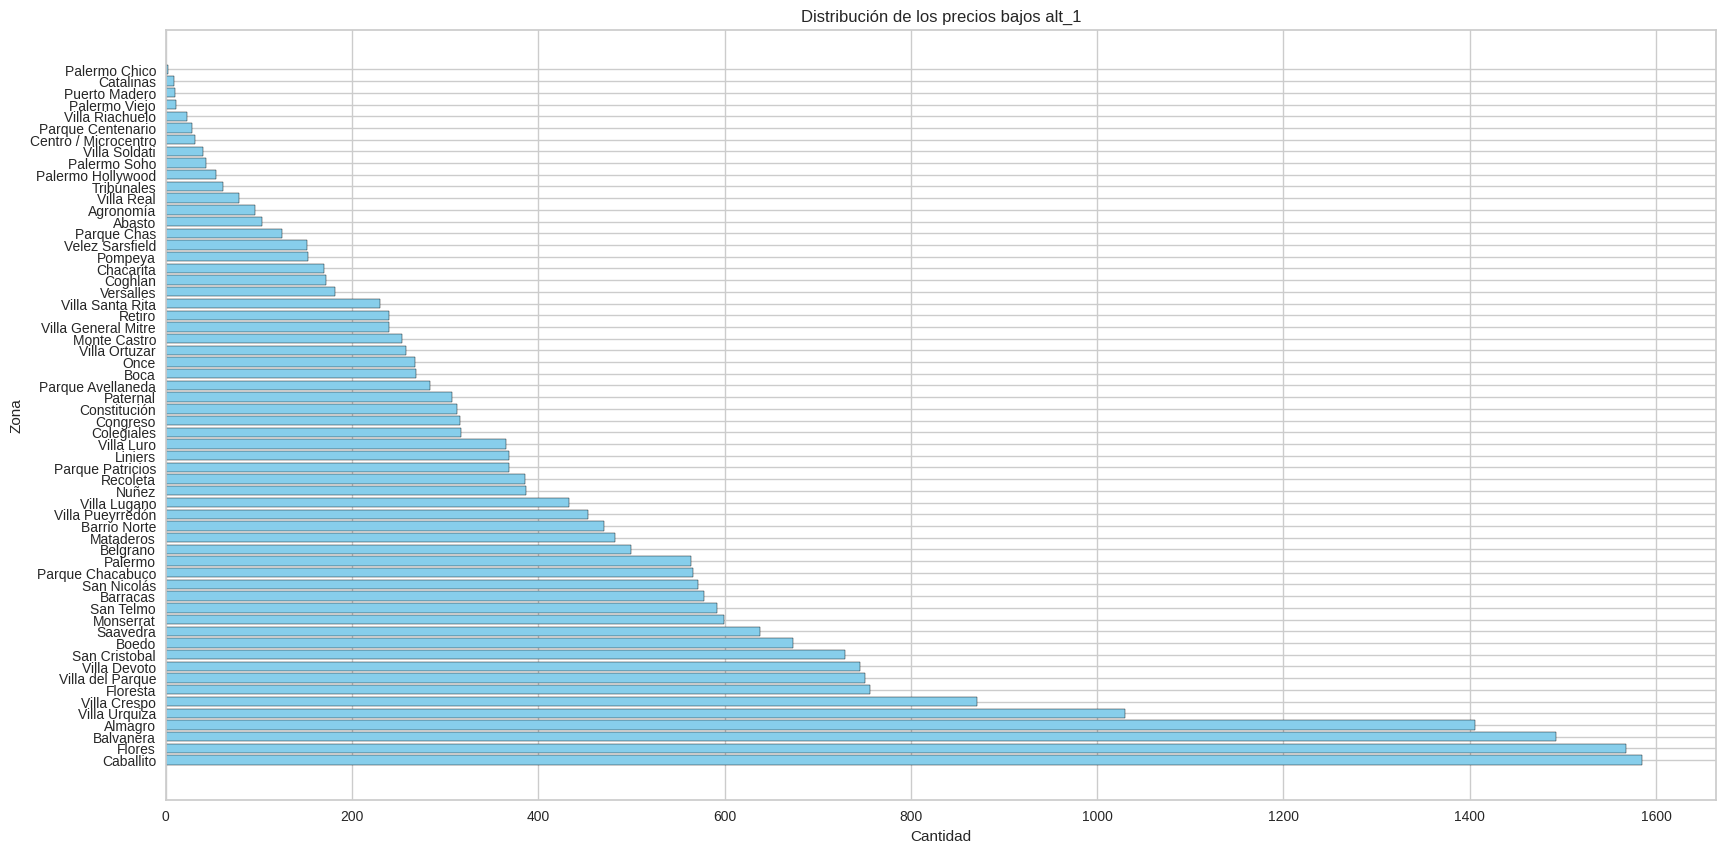

In [275]:
bajo = alt_1[alt_1.copy()['tipo_precio']=='bajo']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = bajo['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios bajos alt_1')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

Ahora lo vemos en la alternativa 2:

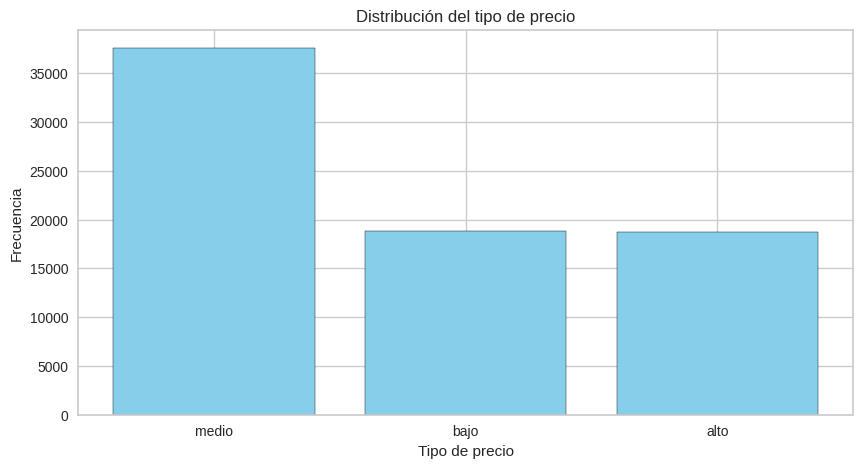

In [276]:
plt.figure(figsize=(10, 5))

frecuencia_por_tipo = alt_2['tipo_precio'].value_counts()

plt.bar(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución del tipo de precio')
plt.xlabel('Tipo de precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

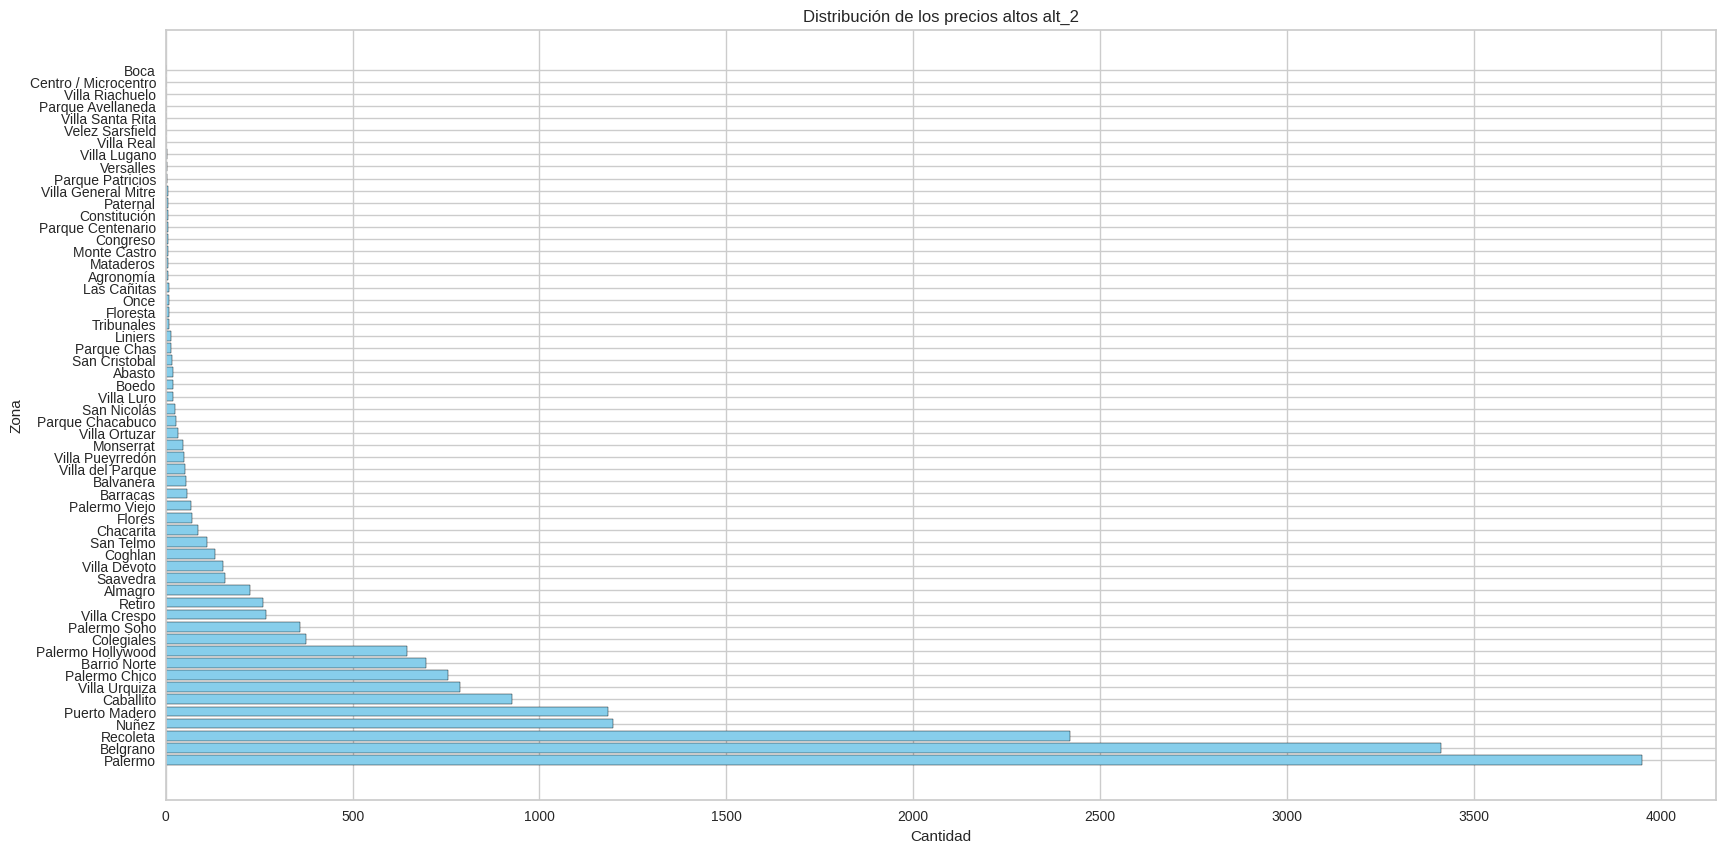

In [277]:
alto = alt_2[alt_2.copy()['tipo_precio']=='alto']


plt.figure(figsize=(20, 10))
frecuencia_por_tipo = alto['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios altos alt_2')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

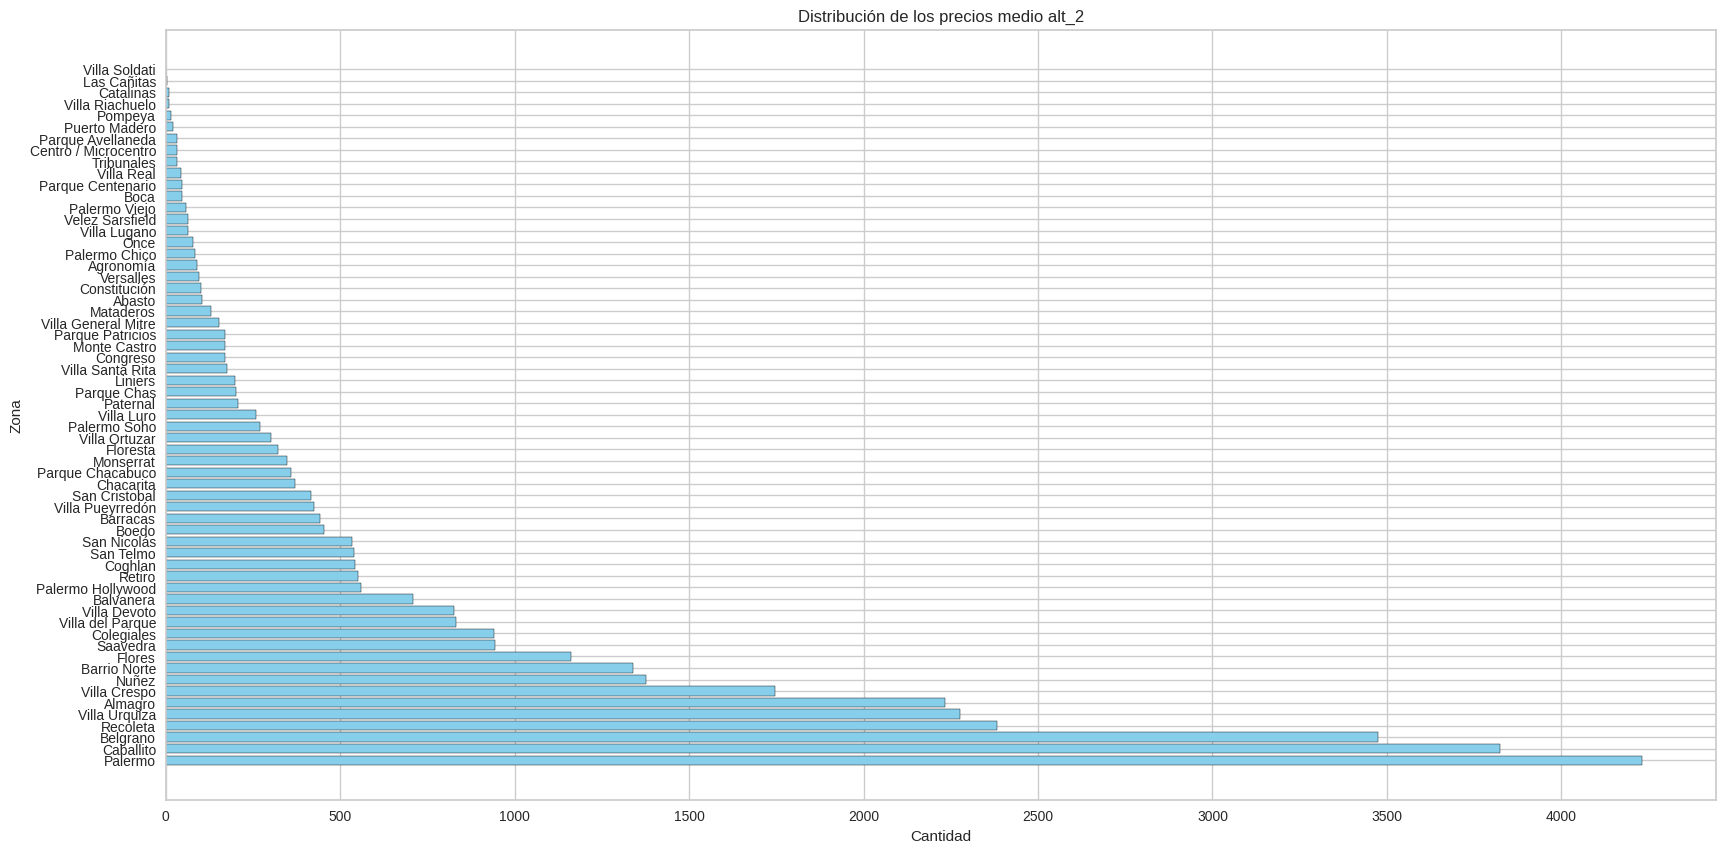

In [278]:
medio = alt_2[alt_2.copy()['tipo_precio']=='medio']


plt.figure(figsize=(20, 10))
frecuencia_por_tipo = medio['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios medio alt_2')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

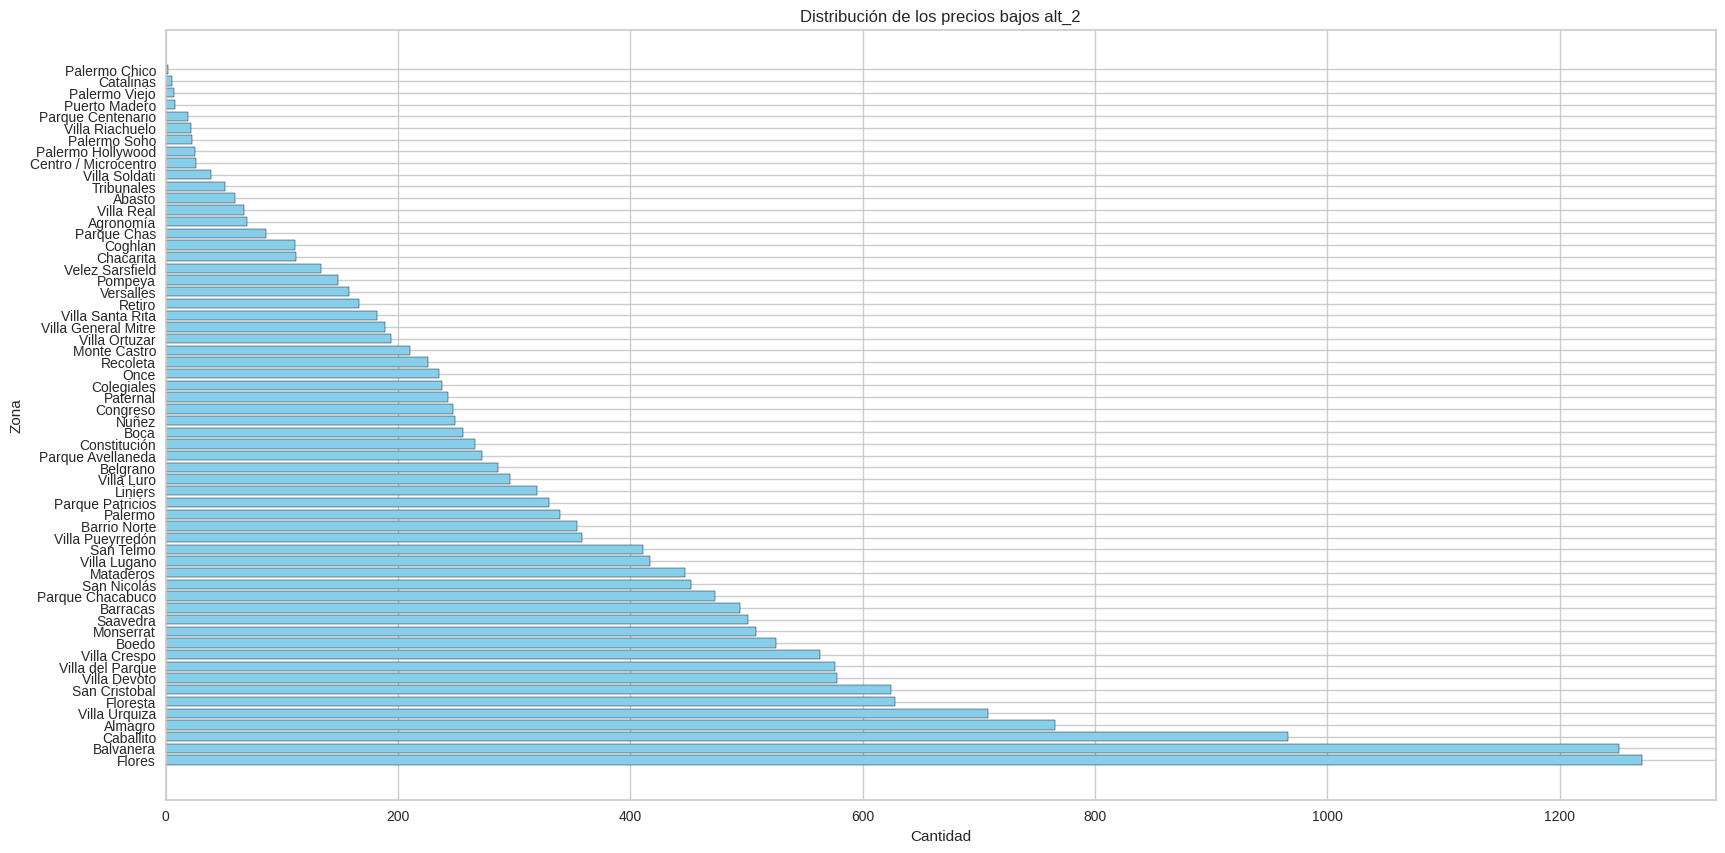

In [279]:
bajo = alt_2[alt_2.copy()['tipo_precio']=='bajo']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = bajo['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios bajos alt_2')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

Por último la alternativa_3:

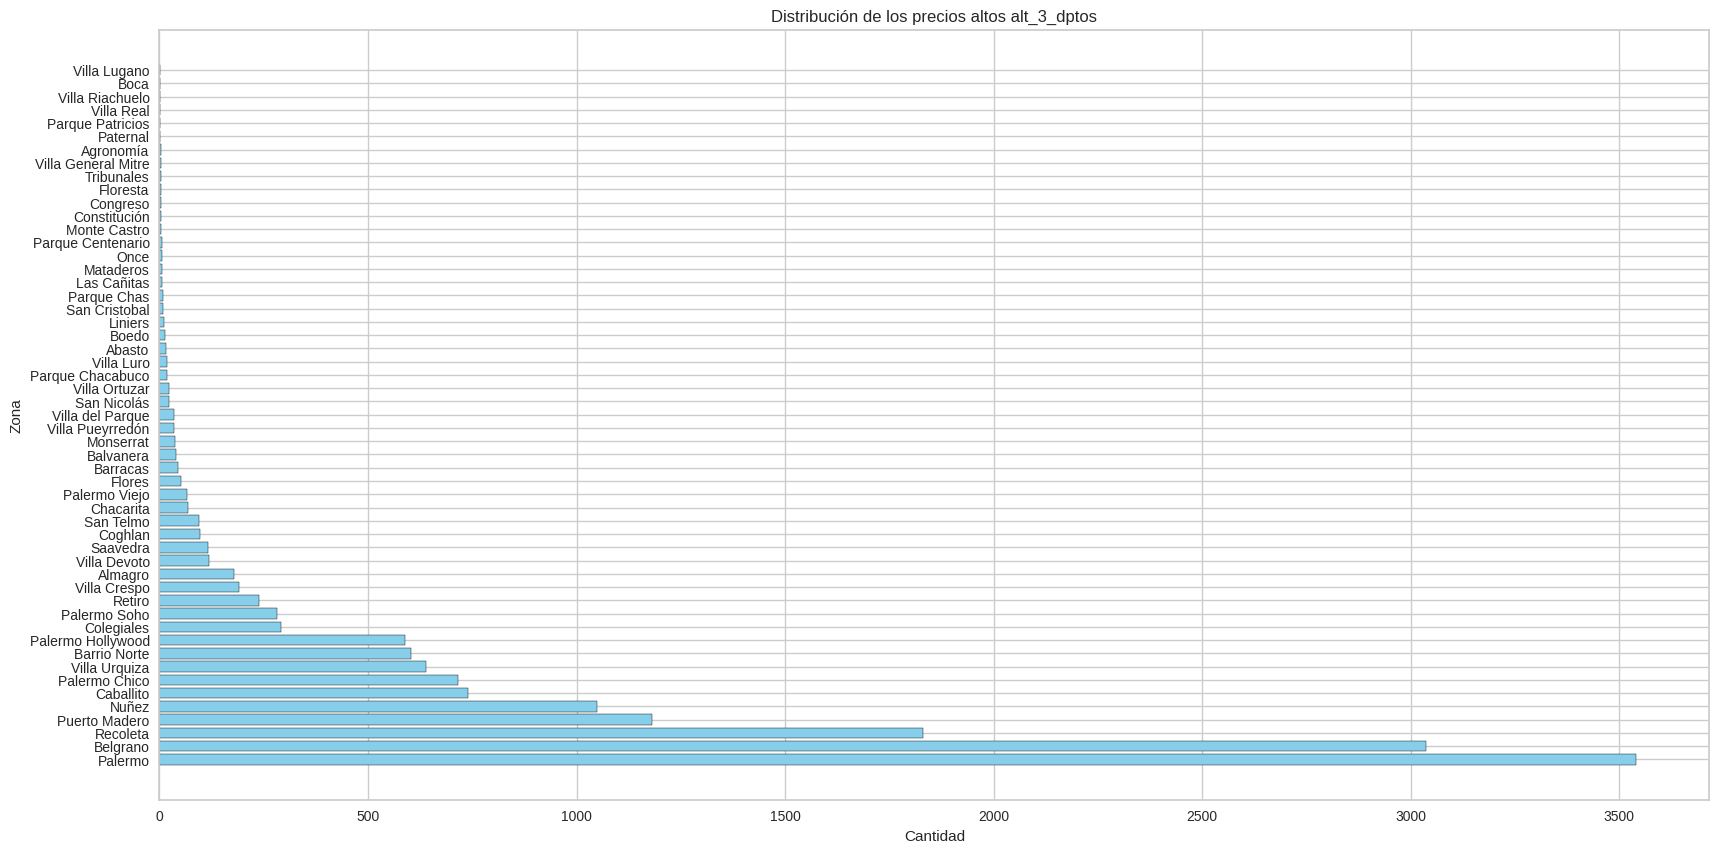

In [280]:
alto = alt_3_dptos[alt_3_dptos.copy()['tipo_precio']=='alto']


plt.figure(figsize=(20, 10))
frecuencia_por_tipo = alto['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios altos alt_3_dptos')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

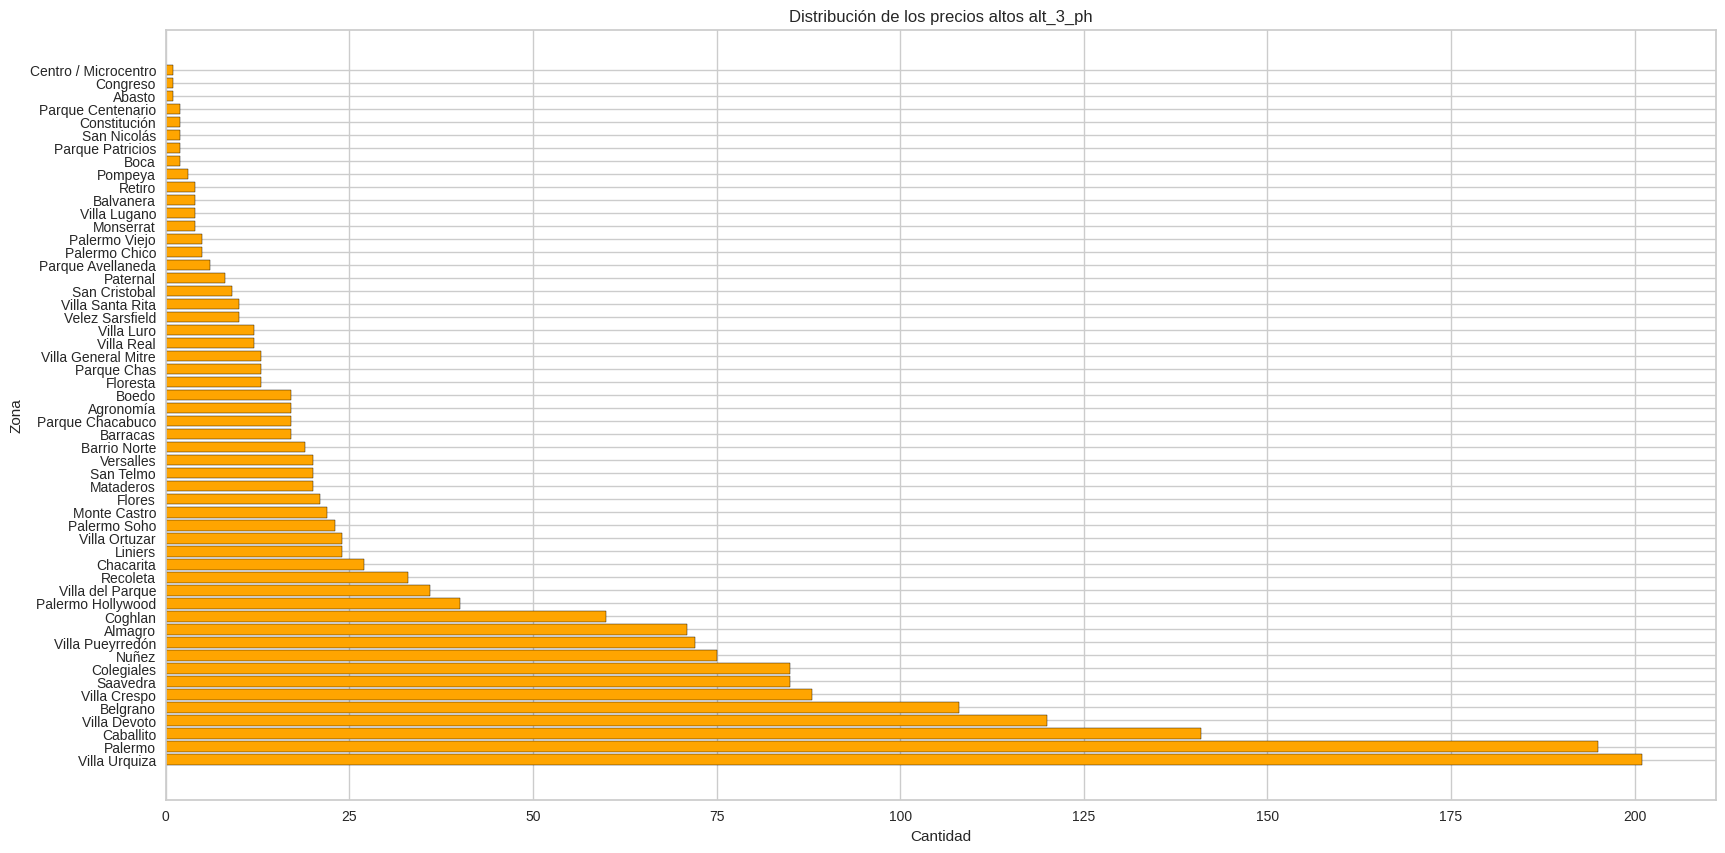

In [281]:
alto = alt_3_ph[alt_3_ph.copy()['tipo_precio']=='alto']


plt.figure(figsize=(20, 10))
frecuencia_por_tipo = alto['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='orange', edgecolor='black')
plt.title('Distribución de los precios altos alt_3_ph')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

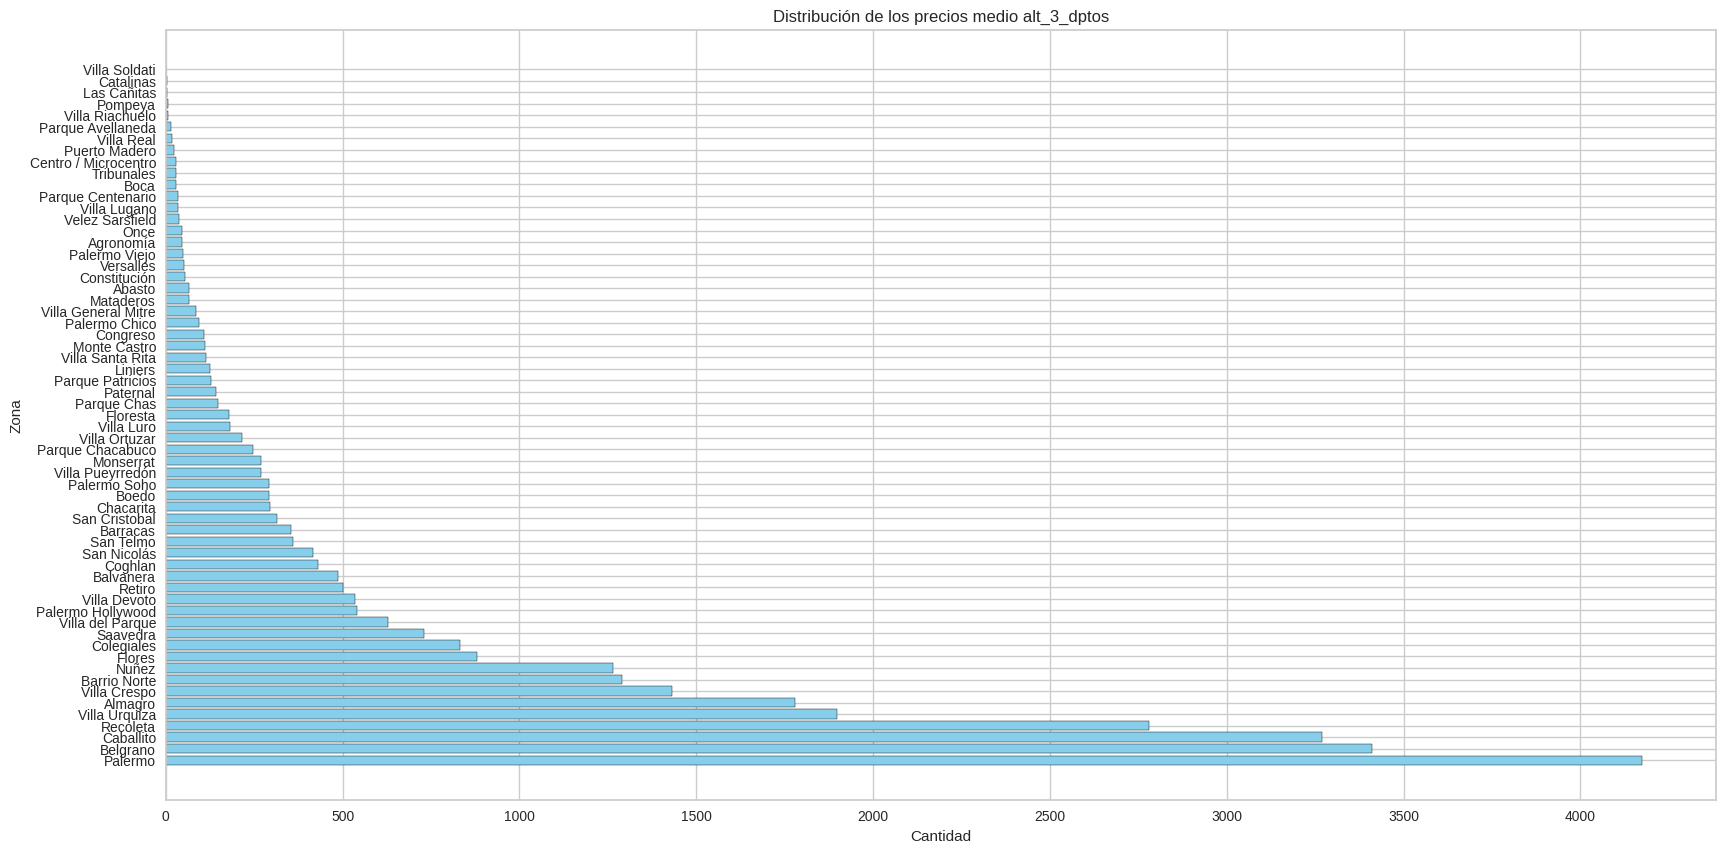

In [282]:
medio = alt_3_dptos[alt_3_dptos.copy()['tipo_precio']=='medio']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = medio['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios medio alt_3_dptos')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

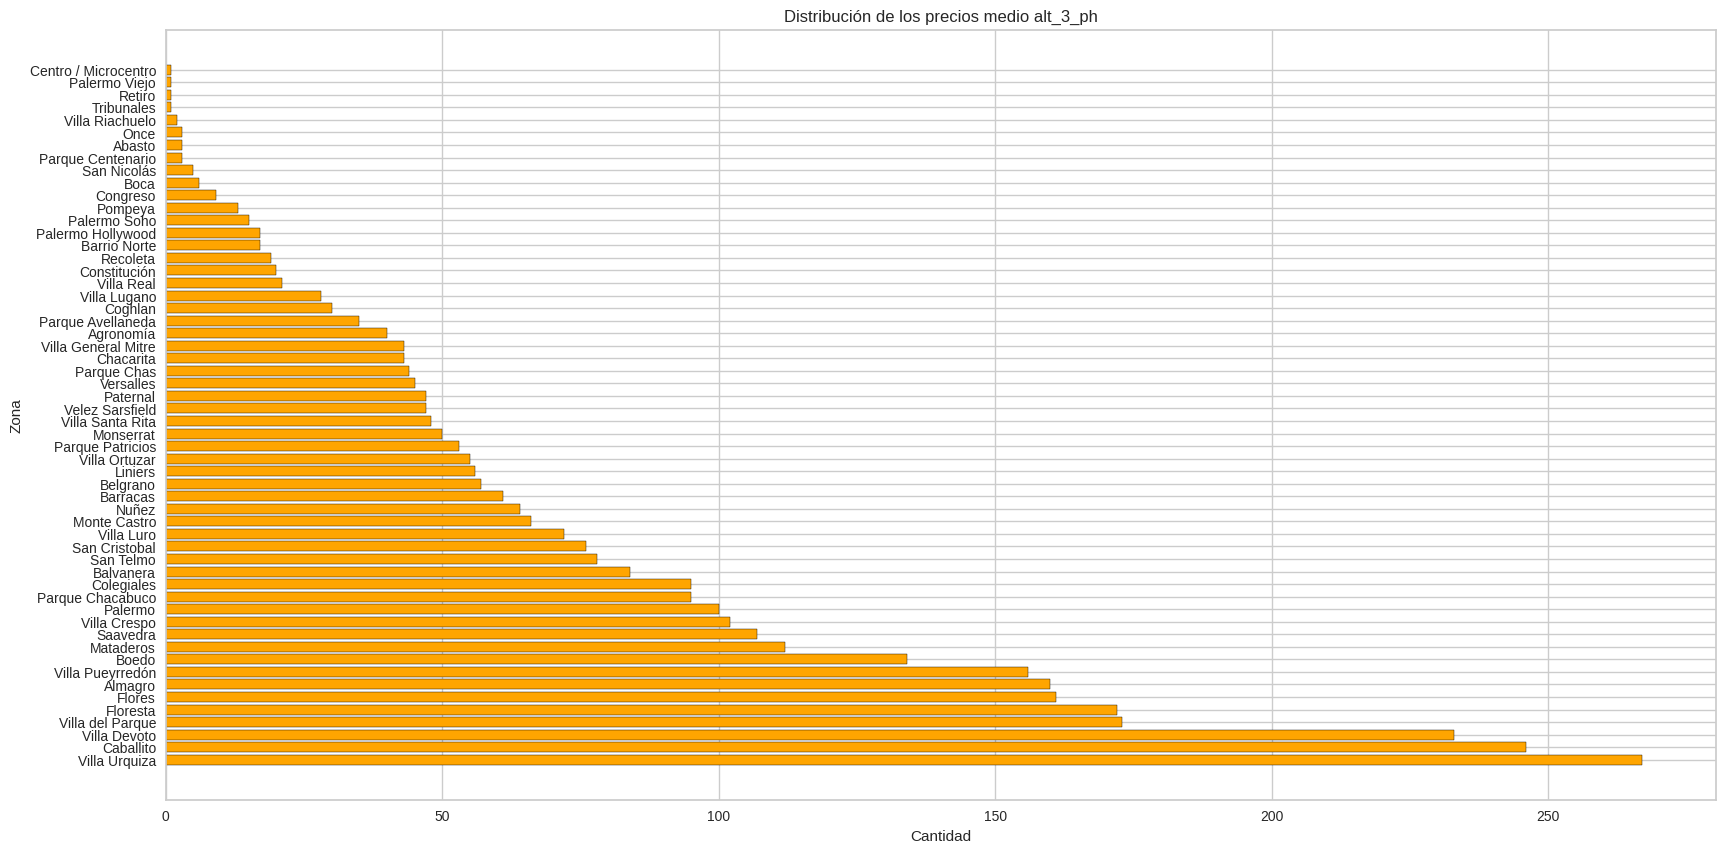

In [283]:
medio = alt_3_ph[alt_3_ph.copy()['tipo_precio']=='medio']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = medio['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='orange', edgecolor='black')
plt.title('Distribución de los precios medio alt_3_ph')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

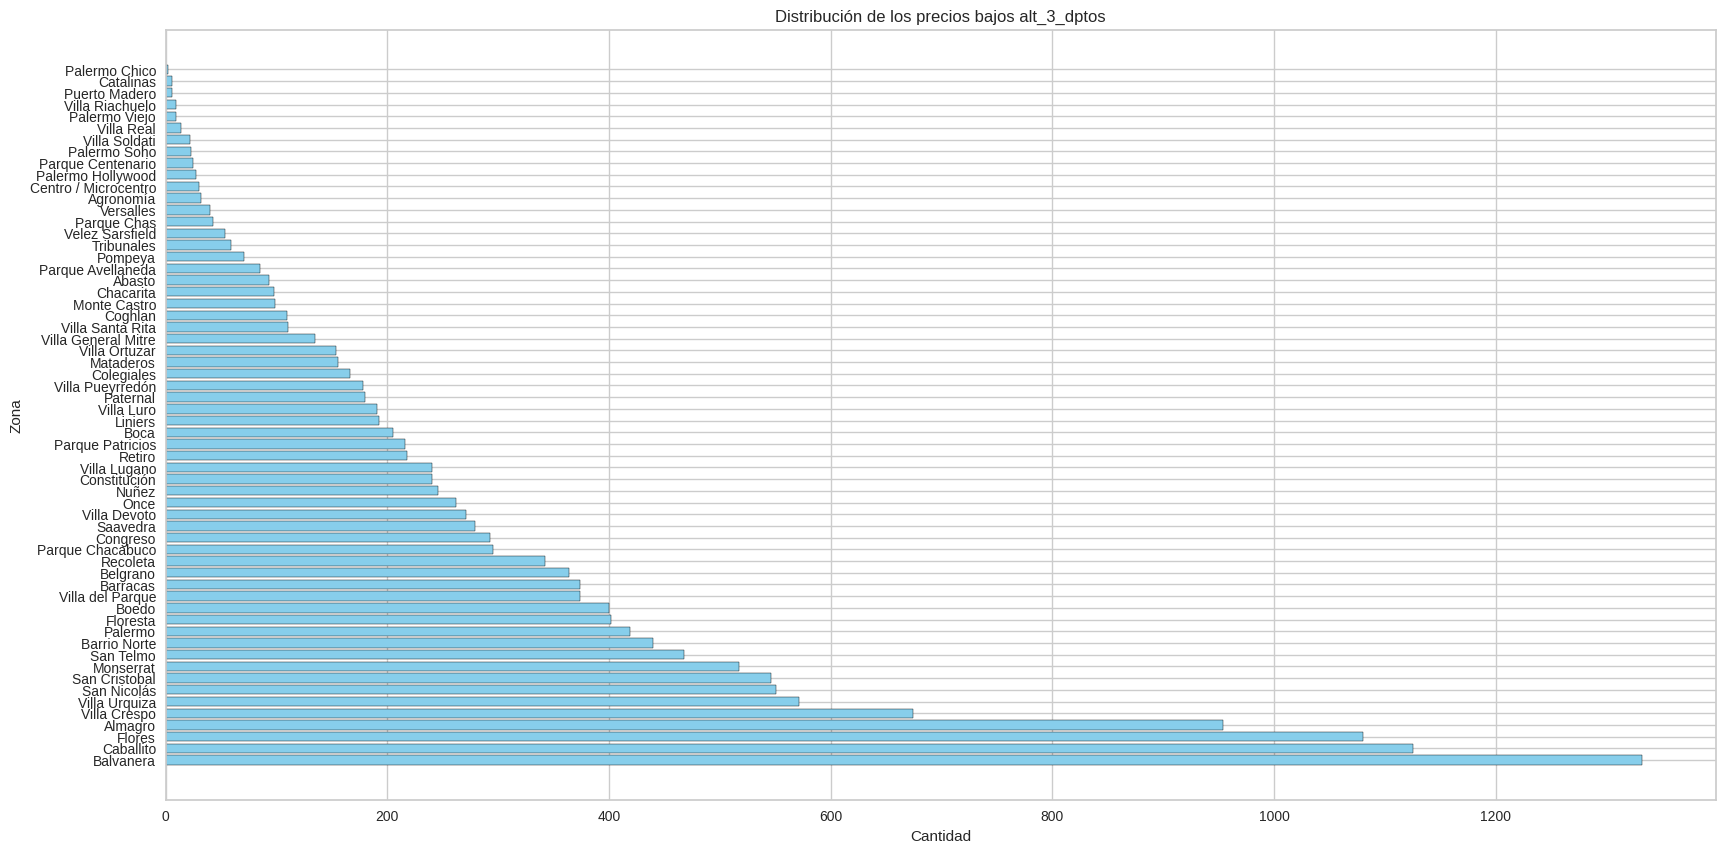

In [284]:
bajo = alt_3_dptos[alt_3_dptos.copy()['tipo_precio']=='bajo']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = bajo['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='skyblue', edgecolor='black')
plt.title('Distribución de los precios bajos alt_3_dptos')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

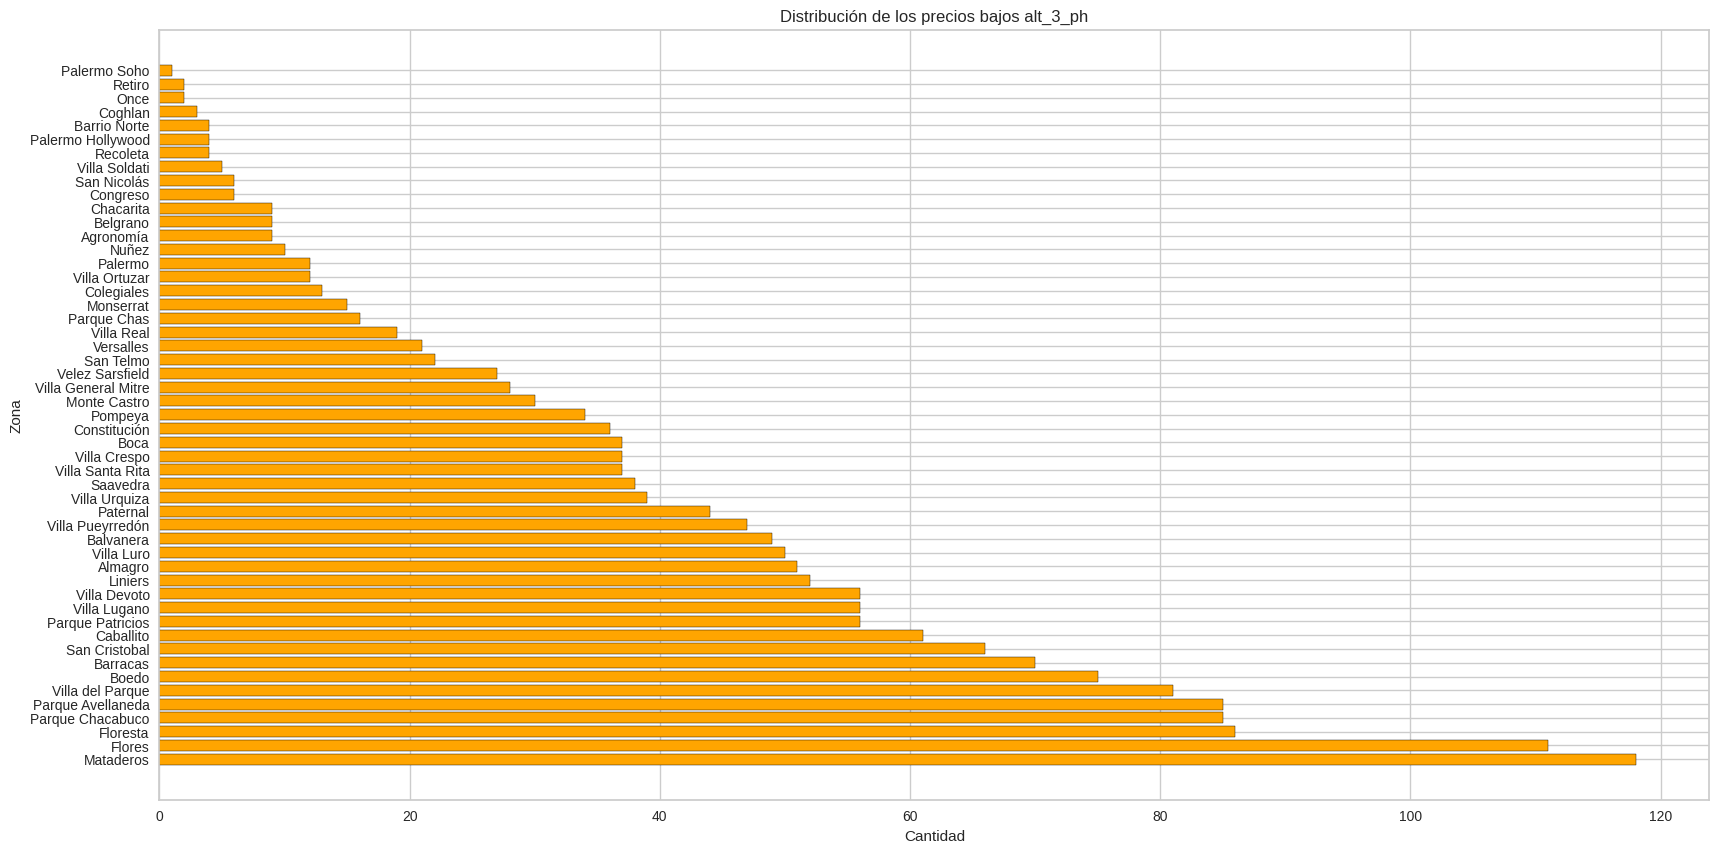

In [285]:
bajo = alt_3_ph[alt_3_ph.copy()['tipo_precio']=='bajo']

plt.figure(figsize=(20, 10))
frecuencia_por_tipo = bajo['zone'].value_counts()
plt.barh(frecuencia_por_tipo.index, frecuencia_por_tipo, color='orange', edgecolor='black')
plt.title('Distribución de los precios bajos alt_3_ph')
plt.xlabel('Cantidad')
plt.ylabel('Zona')
plt.grid(True)
plt.show()

d. Seleccionar una de las alternativas, justificando la misma.

La alternativa elegida es la alternativa 2, una de las razones es que al quedar solo un 25% en bajo y otro en alto, la variacion entre los precios dentro de las categorias es mucho menor que en el caso de la alternariva 1. Esto suena mejor que tener en el mismo grupo valores que tienen diferencias muy grandes entre si.

e. Comparar, si aplica, la alternativa seleccionada con la división en 3 grupos obtenida
utilizando agrupamiento por K Means.

HAY QUE HACER EL 2)f PARA HACER ESTE

f. Mostrar en un mapa de CABA los avisos coloreados por tipo_precio

In [286]:
import geopandas as gpd

Primero importo el shp de CABA

<Axes: >

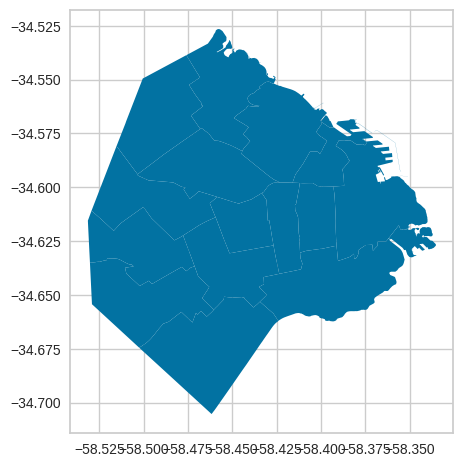

In [287]:
caba_gdf.plot()

Saco los outliers (los puntos fuera de la longitud o latitud de CABA)

In [288]:
alt_2 = alt_2[alt_2["latitud"]>-34.69]
alt_2 = alt_2[alt_2["latitud"]<-34.525]
alt_2.shape

prob = alt_2[alt_2["longitud"]>-58.53]
prob = prob[prob["longitud"]<-58.34]

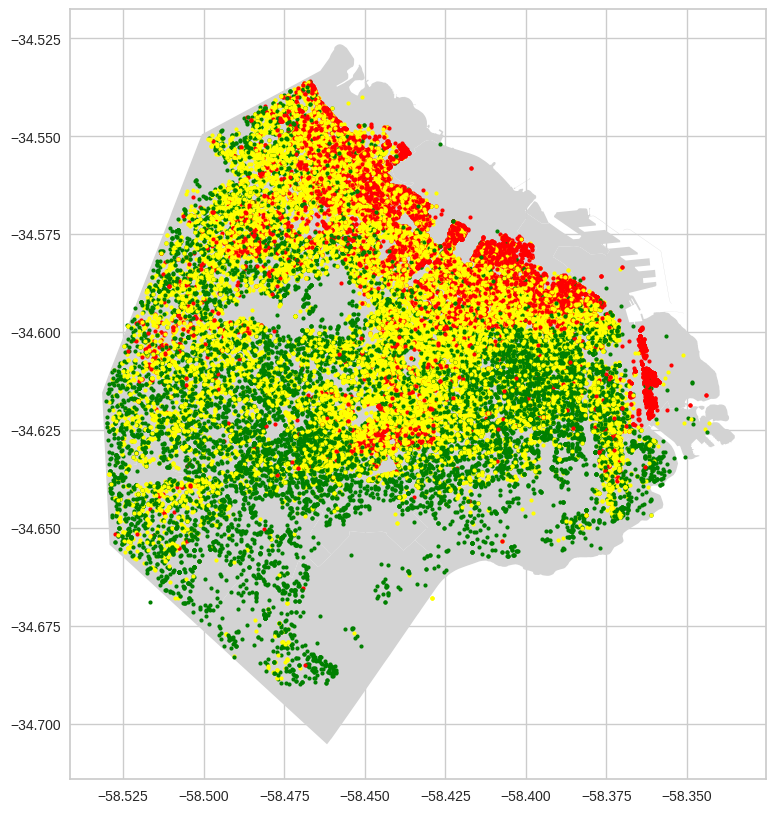

In [289]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
caba_gdf.plot(ax=ax, color='lightgray')

for i in range(0,alt_2.shape[0]):
  prop = alt_2.iloc[i]
  lon = prop['longitud']
  lat = prop['latitud']
  col = 'red'
  if prop['tipo_precio'] == 'medio':
    col = 'yellow'
  if prop['tipo_precio'] == 'bajo':
    col = 'green'

  plt.plot(lon,lat, marker="o", color=col, markersize=3)


Se puede ver como los puntos rojos, es decir precios altos, se concentran mayormente en la parte superios derecha mientras que los verdes y amariilos, precios bajos y medios se distribuyen por todo el mapa

## Entrenamiento y predicción.

Se pide predecir el atributo **tipo_precio** excluyendo del entrenamiento la variable *price*, *pxm2* y cualquier otra que pueda tener el precio de la venta.

In [291]:
reparado.drop(['property_price', 'pxm2'], axis=1, inplace=True)

<ipython-input-291-80ef702756e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reparado.drop(['property_price', 'pxm2'], axis=1, inplace=True)


In [292]:
reparado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75153 entries, 285884 to 75496
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   75153 non-null  float64
 1   longitud                  75153 non-null  float64
 2   city                      75153 non-null  object 
 3   zone                      75153 non-null  object 
 4   operation                 75153 non-null  object 
 5   property_type             75153 non-null  object 
 6   property_rooms            75153 non-null  float64
 7   property_bedrooms         75153 non-null  float64
 8   property_surface_total    75153 non-null  float64
 9   property_surface_covered  75153 non-null  float64
 10  property_title            75153 non-null  object 
dtypes: float64(6), object(5)
memory usage: 8.9+ MB


Se puede apreciar que tenemos varias columnas categoricas, debemos aplicar algún método de ingenería de características.

Decidimos eliminar las columnas de operación y ciudad porque siempre tienen el mismo valor, ya sea Capital Federal y venta.

In [ ]:
reparado.drop(['city', 'operation'], axis=1, inplace=True)

In [395]:
reparado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75153 entries, 285884 to 75496
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   75153 non-null  float64
 1   longitud                  75153 non-null  float64
 2   zone                      75153 non-null  object 
 3   property_type             75153 non-null  object 
 4   property_rooms            75153 non-null  float64
 5   property_bedrooms         75153 non-null  float64
 6   property_surface_total    75153 non-null  float64
 7   property_surface_covered  75153 non-null  float64
 8   property_title            75153 non-null  object 
dtypes: float64(6), object(3)
memory usage: 7.7+ MB


In [400]:
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
ohe = OneHotEncoder()
df_ohe = reparado.copy()

In [443]:
df_dummies = pd.get_dummies(df_ohe, columns=["zone", 'property_type'],drop_first=True, dtype=int)

In [444]:
df_dummies['title_len'] = df_dummies['property_title'].str.len()

In [445]:
df_dummies['title_words'] = df_dummies['property_title'].str.split().str.len()

In [446]:
df_dummies.drop(['property_title'], axis=1, inplace=True)

In [447]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75153 entries, 285884 to 75496
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitud                     75153 non-null  float64
 1   longitud                    75153 non-null  float64
 2   property_rooms              75153 non-null  float64
 3   property_bedrooms           75153 non-null  float64
 4   property_surface_total      75153 non-null  float64
 5   property_surface_covered    75153 non-null  float64
 6   zone_Agronomía              75153 non-null  int64  
 7   zone_Almagro                75153 non-null  int64  
 8   zone_Balvanera              75153 non-null  int64  
 9   zone_Barracas               75153 non-null  int64  
 10  zone_Barrio Norte           75153 non-null  int64  
 11  zone_Belgrano               75153 non-null  int64  
 12  zone_Boca                   75153 non-null  int64  
 13  zone_Boedo                  751

In [449]:
reparado.columns

Index(['latitud', 'longitud', 'zone', 'property_type', 'property_rooms',
       'property_bedrooms', 'property_surface_total',
       'property_surface_covered'],
      dtype='object')